# Introduction

The following notebook is submission for the CORD-19-research-challenge on Kaggle.  
Our goal is to be able to search the dataset and find some answers to the tasks that are defined on Kaggle. We are usind mutiple embbeddings such as Word2Vec, Doc2Vec, BM25 and BERT.  
Apart from Word2Vec we aim to implement a search engine to find papers that are the best possible match for a given query. 

# Setup

## Import packages

In [1]:
import pandas as pd
import numpy as np
import scipy as sc

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpld3
import mplcursors

import json
import os
import glob
import re
import warnings
import random
import spacy
from itertools import chain
from collections import  namedtuple
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from wordcloud import WordCloud

from gensim.models import Word2Vec, doc2vec
from gensim.utils import simple_preprocess

from rank_bm25 import BM25Okapi

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import transformers
from summarizer import Summarizer
import torch
from transformers import BertTokenizer
from transformers import BertForQuestionAnswering


Bad key "text.kerning_factor" on line 4 in
C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Download the stopwords and special characters

In [2]:
nltk.download('stopwords')
stopwords.words('english')
nltk.download('punkt')
warnings.filterwarnings(action='once')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m_lev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\m_lev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data processing

### Collect json files

In [3]:
# get all paths
filepath_biorxiv = '.data/biorxiv_medrxiv/biorxiv_medrxiv/'
filepath_noncomm = '.data/noncomm_use_subset/noncomm_use_subset'
filepath_comm = './data/comm_use_subset/comm_use_subset'
filepath_custom = '.data/custom_license/custom_license'

In [4]:
# enumerate json files
all_json_files = glob.glob(f'data/**/*.json', recursive=True)
biorxiv_json_files = glob.glob(f'data/biorxiv_medrxiv/**/*.json', recursive=True)
noncomm_json_files =  glob.glob(f'data/noncomm_use_subset/**/*.json', recursive=True)
comm_json_files = glob.glob(f'data/comm_use_subset/**/*.json', recursive=True)
custom_json_files = glob.glob(f'data/custom_license/**/*.json', recursive=True)

### Create dictionary
Create a dictionary with the plain texts, indexing all papers with it's ID, store dictionary as json

In [86]:
# read metadata.csv as panda df index by 'cord_uid'
metadata_df = pd.read_csv('data/metadata.csv', keep_default_na=False)

# convert the metadata to a dictionary
paper_dict = {}
for i in range(len(metadata_df)):
    # extract body text from json file if possible
    has_pdf_parse = metadata_df.iloc[i]['has_pdf_parse']
    if has_pdf_parse:
        full_text_file = metadata_df.iloc[i]['full_text_file']
        sha = metadata_df.iloc[i]['sha']

        json_file_glob = 'data/{0}/**/{1}.json'.format(full_text_file, sha)
        paper = glob.glob(json_file_glob, recursive=True)
        
        body_text = ''
        try:
            with open(os.path.join(paper[0])) as json_file:
                paper_json = json.load(json_file)
                body_text = concat_json_properties_as_string(paper_json['body_text'], 'text')
        except:
            pass
        
    # create dict
    paper_dict[metadata_df.iloc[i]['cord_uid']] = {
        'sha': sha,
        'title': metadata_df.iloc[i]['title'],
        'authors': metadata_df.iloc[i]['authors'],
        'abstract': metadata_df.iloc[i]['abstract'],
        'body_text': body_text,
        'publish_date': metadata_df.iloc[i]['publish_time'],
        'journal': metadata_df.iloc[i]['journal'],
        'url': metadata_df.iloc[i]['url'],
    }

# save dictionary to binary file  
save_obj(paper_dict, "paper_dict")

In [22]:
# load dictionary from the binary file
paper_dict = load_obj("paper_dict")

## Helper functions

In [5]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [6]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [7]:
def preprocessing(text, additional_stopwords=[]):
    preprocessed_text = simple_preprocess(text)
    filtered_list = []
    for token in preprocessed_text:
        if token in stopwords.words('english') or token in additional_stopwords  or token.isnumeric():
            continue
    filtered_list.append(token)
    return filtered_list

In [8]:
def get_preprocessed_text_from_files(json_files, attribute):
    preprocessed_text = [] 
    for json_file in json_files:
        with open(os.path.join(json_file)) as json_file:
            json_object = json.load(json_file)

            attribute_object = json_object[attribute]
            text = concat_json_properties_as_string(attribute_object, 'text')

            preprocessed_text_ = preprocessing(str(text))
            preprocessed_text.append(preprocessed_text_)

    return preprocessed_text

In [9]:
def get_preprocessed_text_from_dict(attribute):
    preprocessed_text = []
    for key in paper_dict:
        attribute_string = paper_dict[key][attribute]
        
        if (attribute_string != ''):
            preprocessed_text_ = preprocessing(attribute_string)
            preprocessed_text.append(preprocessed_text_)
        
    return preprocessed_text

In [10]:
def get_preprocessed_sentences_from_files(json_files, attribute):
    preprocessed_tokenized_sentences = []
    for json_file in json_files:
        with open(os.path.join(json_file)) as json_file:
            json_object = json.load(json_file)

            try:
                text = concat_json_properties_as_string(json_object[attribute], 'text')
                all_sentences = nltk.sent_tokenize(text)

                preprocessed_sentences = []
                for sentence in all_sentences:
                    preprocessed_sentences.append(preprocessing(sentence))

                preprocessed_tokenized_sentences.extend(preprocessed_sentences)
            except:
                pass

    return preprocessed_tokenized_sentences

In [11]:
def get_preprocessed_sentences_from_dict(attribute):
    preprocessed_tokenized_sentences = []
    for key in paper_dict:
        attribute_string = paper_dict[key][attribute]
        all_sentences = nltk.sent_tokenize(attribute_string)

        preprocessed_sentences = []
        for sentence in all_sentences:
            if (attribute_string != ''):
                preprocessed_sentences.append(preprocessing(sentence))

        preprocessed_tokenized_sentences.extend(preprocessed_sentences)
        
    return preprocessed_tokenized_sentences

In [12]:
def get_section_text(body_text, section_name_pattern):
    section_text = ''
    for section in body_text:
        section_name = section['section']
        if section_name_pattern in section_name.lower():
            section_text.concat(section['text'])
    print(section_text)
    return section_text

In [13]:
def concat_json_properties(json_list_element, property_name):
    concatenated_content = []
    for item in json_list_element:
        concatenated_content.append(item[property_name])
    return concatenated_content

In [14]:
def concat_json_properties_as_string(json_list_element, property_name):
    concatenated_content = ''
    for item in json_list_element:
        concatenated_content = concatenated_content + item[property_name]
    return concatenated_content

In [15]:
def visualize_word_frequencies(feature):
    fig = plt.figure(figsize=(8,4))
    plot = fig.add_subplot()
    wordcloud = WordCloud()
    frequency_dist = nltk.FreqDist(feature)
    sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50] 
    wordcloud.generate_from_frequencies(frequency_dist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [16]:
def get_dict_element_by_key(element_key):
    text = []
    for key in paper_dict:
        string = paper_dict[key][element_key]
        if (string != 'nan' and string != ''):
            text.append(string)
    return text

In [17]:
def print_result_from_dict(dict_key):
    dict_element = paper_dict[dict_key]
    test = dict_element['publish_date']
    print('\033[1m' + 'Title: ' + dict_element['title'])
    print(f"Published on '{dict_element['publish_date']}' by '{dict_element['authors']}' in '{dict_element['journal']}'")
    print('Url: ' + dict_element['url'])
    print('Abstract: ' + dict_element['abstract'])
    print('\n')

In [18]:
def get_papers_by_authors(authors):
    dict_keys = []
    for key in paper_dict:
        paper_authors = paper_dict[key]['authors'].lower()
        for author in authors:
            if author.lower() in paper_authors:
                dict_keys.append(key)
    return dict_keys

In [19]:
def get_papers_by_title_keyword(title_keyword):
    dict_keys = []
    for key in paper_dict:
        paper_title = paper_dict[key]['title'].lower()
        if title_keyword.lower() in paper_title:
            dict_keys.append(key)
    return dict_keys

In [20]:
def create_df(file_list, filepath):
    contents = pd.DataFrame(columns=['text'])
    json_pattern = os.path.join(filepath, '*.json')
    file_list = glob.glob(json_pattern)
    for file in file_list:
        with open(file) as json_file:
            data = json_file.read()
        
        obj = json.loads(data)
        if len(obj['abstract']) > 0:
            content = obj['abstract'][0]['text']
            contents = contents.append({'text': content}, ignore_index=True)
    return contents

In [21]:
def filter_df(df):
    filtered_list_visualization = []
    filtered_list = []
    for i in range(len(df)):
        filtered_list.append(simple_preprocess(df.text.values[i]))
        for w in simple_preprocess(df.text.values[i]):
            if w in stopwords.words('english') or len(w) < 2 or w.isnumeric():
                continue
        filtered_list_visualization.append(w)
    return filtered_list, filtered_list_visualization

# Dataset analysis
In this section we are doing a small data analysis to get some usefull insight into the data set.
In first sub-section we get an overwiev on the publications of the research papers. We plot the most occuring journals from the data set as well as the distribution of the years of publishing. 

Current data set state:
a total of 51'045 research documents.

We have access to full text PDFs from the following sources:  

biorxiv_medrxiv: 1625 full text PDF  
comm_use_subset: 9524 full text PDF  
custom_license: 26505 full text PDF  
noncomm_use_subset: 2490 full text PDF  

## Publications

### Journals
The dataset contains research papers that have been published in various journals. Below we pot the 20 most frequent journals from the data set. 

In [23]:
journal_names = get_dict_element_by_key('journal')
        
journals, counts = np.unique(journal_names, return_counts=True)
top_journal_indecies = np.argsort(counts)[::-1][0:20]

for top_journal_index in top_journal_indecies:
    print(f"Journal: {journals[top_journal_index]} occured {counts[top_journal_index]} times")

Journal: Journal of Virology occured 1744 times
Journal: PLoS One occured 1569 times
Journal: Virology occured 867 times
Journal: Emerg Infect Dis occured 749 times
Journal: The Lancet occured 621 times
Journal: Viruses occured 569 times
Journal: Arch Virol occured 505 times
Journal: Virus Research occured 496 times
Journal: Sci Rep occured 492 times
Journal: Vaccine occured 484 times
Journal: Veterinary Microbiology occured 443 times
Journal: Journal of Virological Methods occured 393 times
Journal: Journal of Clinical Virology occured 381 times
Journal: The Lancet Infectious Diseases occured 374 times
Journal: PLoS Pathog occured 362 times
Journal: Virol J occured 359 times
Journal: Antiviral Research occured 352 times
Journal: Proceedings of the National Academy of Sciences occured 340 times
Journal: Journal of Clinical Microbiology occured 335 times
Journal: Clin Infect Dis occured 271 times


### Years of publishing
In this plot we show the distribution of years of publishing. 

<IPython.core.display.Javascript object>


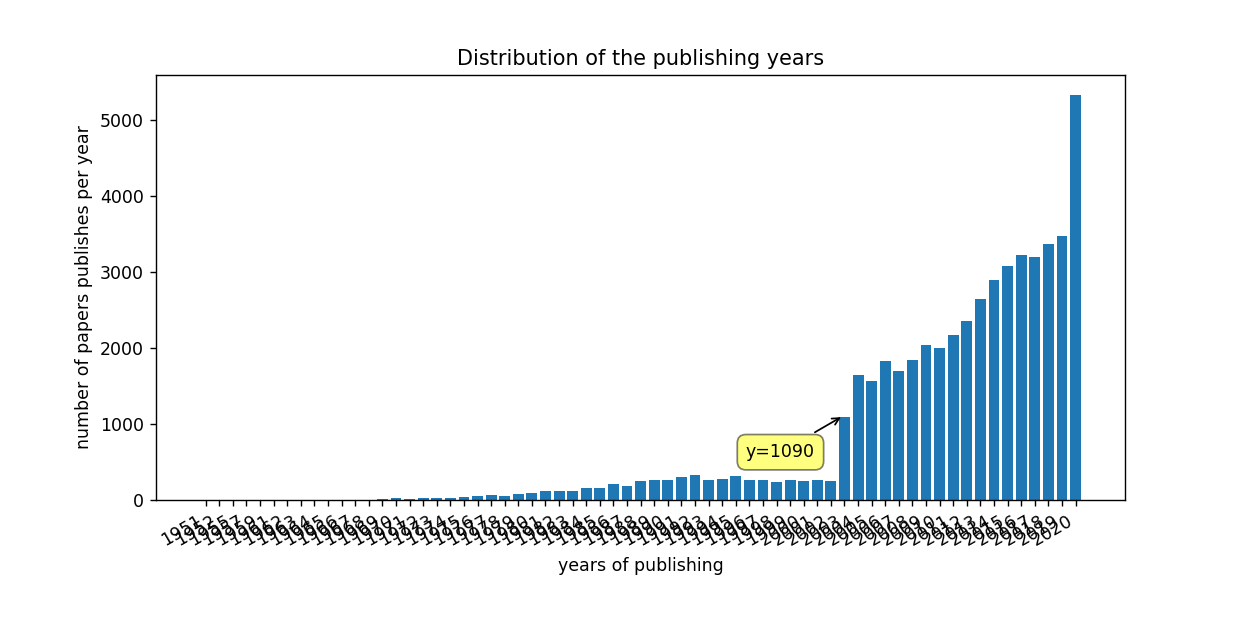

In [24]:
publish_years = []
for key in paper_dict:
    string_date = str(paper_dict[key]['publish_date'])
    if (string_date != 'nan' and string_date != ''):
        match = re.search('[0-9]{4}', string_date)
        
        if match:
            publish_year = match.group(0)
            publish_years.append(publish_year)
        else:
            print(string_date)
            
get_dict_element_by_key('journal')
# plot the distribution of the publishing years
x, y = np.unique(publish_years, return_counts=True)
fig = plt.figure(figsize=(10,5))
plot = fig.add_subplot()
plot.bar(x,y)
plt.gcf().autofmt_xdate()
plt.title("Distribution of years of publishing")
plt.xlabel("years of publishing")
plt.ylabel("number of papers publishes per year")

mplcursors.cursor(hover=True)

plt.show()

The distribution in the plot above shows that this data set is a broad collection of research papers and is most likely not restricted on the corona virus. We also see a first spike in the distribution around the time that SARS was descovered and another spike in the current year.  
In the analysis of the research topics of the data set we can get a better understanding on this distribution. 

## Topics
The dataset is not limited to papers specifically about COVID-19 but also covers topis about multiple other viruses. In this section we inspect the topics of the research papers.  

The first plot shows a visualization of topics across the papers. 

<IPython.core.display.Javascript object>


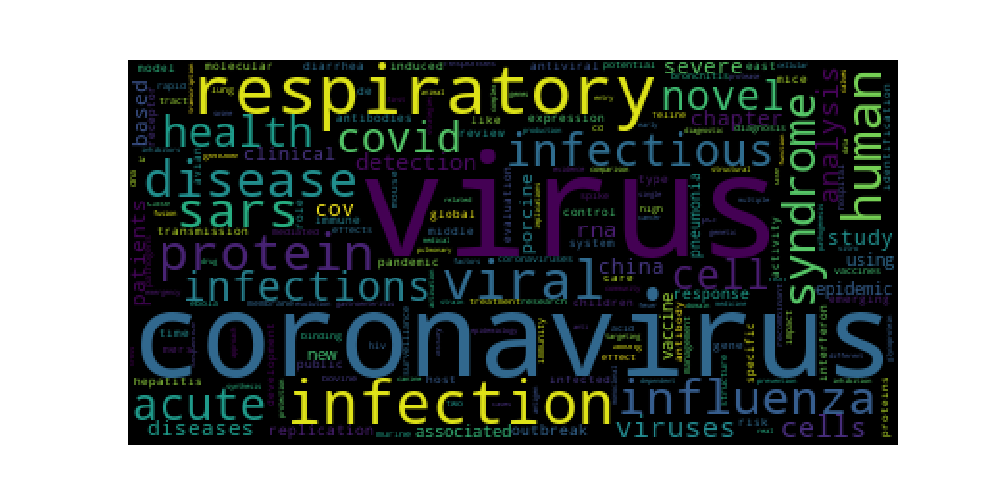

In [26]:
topics = []
for title in titles:
    topics.extend(preprocessing(title))

visualize_word_frequencies(topics)

The plot above emphesizes the different topics of the data set. As we can see the data set is not limited to papers about Coronavirus i.e. COVID-19 but contains papers about mutiple other viruses such as the influenza or SARS.  
To give a slight impression about the dataset we plot 20 random titles from the data set.

In [25]:
# Print random document titles
titles = get_dict_element_by_key('title')
titles_to_print = random.choices(titles, k=20)
print('\n'.join(titles_to_print))

Should this event be notified to the World Health Organization? Reliability of the International Health Regulations notification assessment process
Understanding the legal trade of cattle and camels and the derived risk of Rift Valley Fever introduction into and transmission within Egypt
Performance of the TB-LAMP diagnostic assay in reference laboratories: Results from a multicentre study
Different host cell proteases activate the SARS-coronavirus spike-protein for cell–cell and virus–cell fusion
Immunohistochemical studies on meningoencephalitis in feline infectious peritonitis (FIP)
Single-dose intranasal administration with mDEF201 (adenovirus vectored mouse interferon-alpha) confers protection from mortality in a lethal SARS-CoV BALB/c mouse model
Middle East Respiratory Syndrome (MERS) – An update
A review of the 2019 Novel Coronavirus (COVID-19) based on current evidence
Tat Peptide-Mediated Soluble Expression of the Membrane Protein LSECtin-CRD in Escherichia coli
Infections
Ba

Despite being only a tiny fraction of the data set that was plotted above, we can still see the broad range of topics that are being covered. 

In the next section we plot a clustering of the document titles. We use kMeans in combination with PCA to come up with a 2D representation of the topics. For indexing and comparing the titles we use a simple td-idf. 
Despite having more than 50'000 papers in the data base the collection of titles only still represents a relatively small data set. We therefore are not using a more sophisticated word emmbedding like Word2Vec.  
Note that we are only using a subset of 20'000 randomly selected document titles for the clustering in order to speed up the computation. 

In [35]:
titles = np.array(random.choices(get_dict_element_by_key('title'),k=20000))

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(titles)

In [36]:
num_clusters = 10
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

In [37]:
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

In [38]:
labels = clustering_model.fit_predict(tfidf)
X = tfidf.todense()

In [39]:
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()

## Visualize word frequencies
Visualize word frequencies of the abstracts to get a better insight in the topics covered in the papers.  
This plot visualizes the word frequencies across all abstracts. 

<IPython.core.display.Javascript object>


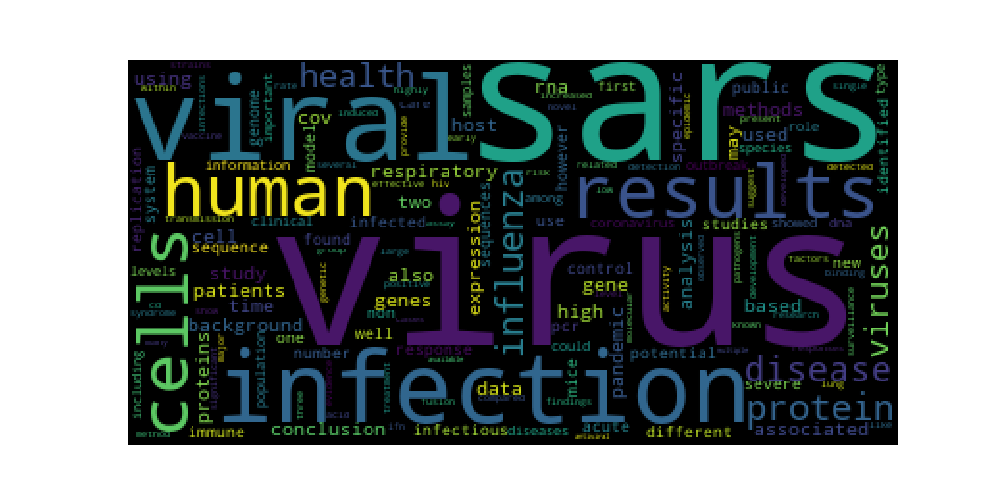

In [119]:
abstract_text = get_preprocessed_text_from_dict('abstract')

visualize_word_frequencies(chain(*abstract_text))

# Search for documents for specific authors or key words in title
Apart from searching the data base using document embeddings we can also search them by simple key words such as the author or the title. 

In [23]:
def find_papers_by_authors(authors_query):
    keys = get_papers_by_authors(authors_query)
    for key in keys:
        print_result_from_dict(key)

In [24]:
find_papers_by_authors(['Chih-Fong'])

Title: Genetic lesions within the 3a gene of SARS-CoV
Published on '2005-06-20' by 'Tan, Timothy HP; Barkham, Timothy; Fielding, Burtram C; Chou, Chih-Fong; Shen, Shuo; Lim, Seng Gee; Hong, Wanjin; Tan, Yee-Joo' in 'Virol J'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1183252/
Abstract: A series of frameshift mutations within the 3a gene has been observed in culture-derived severe acute respiratory syndrome coronavirus (SARS-CoV). We report here that viral RNA from clinical samples obtained from SARS-CoV infected patients also contains a heterogeneous population of wild-type and mutant 3a transcripts.


Title: Inhibition of the interaction between the SARS-CoV Spike protein and its cellular receptor by anti-histo-blood group antibodies
Published on '2008-09-25' by 'Guillon, Patrice; Clément, Monique; Sébille, Véronique; Rivain, Jean-Gérard; Chou, Chih-Fong; Ruvoën-Clouet, Nathalie; Le Pendu, Jacques' in 'Glycobiology'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7108609/
Abs

Abstract: A new coronavirus (severe acute respiratory syndrome coronavirus [SARS-CoV]) has been identified to be the etiological agent of severe acute respiratory syndrome. Given the highly contagious and acute nature of the disease, there is an urgent need for the development of diagnostic assays that can detect SARS-CoV infection. For determination of which of the viral proteins encoded by the SARS-CoV genome may be exploited as diagnostic antigens for serological assays, the viral proteins were expressed individually in mammalian and/or bacterial cells and tested for reactivity with sera from SARS-CoV-infected patients by Western blot analysis. A total of 81 sera, including 67 from convalescent patients and seven pairs from two time points of infection, were analyzed, and all showed immunoreactivity towards the nucleocapsid protein (N). Sera from some of the patients also showed immunoreactivity to U274 (59 of 81 [73%]), a protein that is unique to SARS-CoV. In addition, all of the 

Abstract: Abstract The membrane fusion process mediated by severe acute respiratory syndrome coronavirus (SARS–CoV) S protein and its cellular receptor angiotensin-converting enzyme 2 (ACE2) had been reconstituted using two Chinese hamster ovary (CHO) cell lines that constitutively express these recombinant proteins separately. This system was applied to develop a quantitative measurement of cell–cell fusion using hepatitis C virus (HCV) NS3/4A protease and a secretion-blocked EGFP-4A/4B-SEAP (EGFP: enhanced green fluorescent protein; 4A/4B: a decapeptide substrate of NS3/4A protease; SEAP: secreted alkaline phosphatase) fusion gene. Both genes were transiently expressed in either of the CHO cell lines, followed by fusion treatment. Significant SEAP activity could be detected in the culture medium only after cell–cell fusion occurred. Cell–cell fusion provides an environment in which the protease encounters its substrate 4A/4B, thereby releasing SEAP from the fusion protein. In this st

In [25]:
titles = get_papers_by_title_keyword('sars')
for key in titles:
    print_result_from_dict(key)

Title: A double epidemic model for the SARS propagation
Published on '2003-09-10' by 'Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine' in 'BMC Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC222908/
Abstract: BACKGROUND: An epidemic of a Severe Acute Respiratory Syndrome (SARS) caused by a new coronavirus has spread from the Guangdong province to the rest of China and to the world, with a puzzling contagion behavior. It is important both for predicting the future of the present outbreak and for implementing effective prophylactic measures, to identify the causes of this behavior. RESULTS: In this report, we show first that the standard Susceptible-Infected-Removed (SIR) model cannot account for the patterns observed in various regions where the disease spread. We develop a model involving two superimposed epidemics to study the recent spread of the SARS in Hong Kong and in the region. We explore the situation where these epidemics may be caused either by a virus and one

Abstract: BACKGROUND: Severe acute respiratory syndrome (SARS) has claimed 349 lives with 5,327 probable cases reported in mainland China since November 2002. SARS case fatality has varied across geographical areas, which might be partially explained by air pollution level. METHODS: Publicly accessible data on SARS morbidity and mortality were utilized in the data analysis. Air pollution was evaluated by air pollution index (API) derived from the concentrations of particulate matter, sulfur dioxide, nitrogen dioxide, carbon monoxide and ground-level ozone. Ecologic analysis was conducted to explore the association and correlation between air pollution and SARS case fatality via model fitting. Partially ecologic studies were performed to assess the effects of long-term and short-term exposures on the risk of dying from SARS. RESULTS: Ecologic analysis conducted among 5 regions with 100 or more SARS cases showed that case fatality rate increased with the increment of API (case fatality =

Abstract: BACKGROUND: Despite the passing of more than a year since the first outbreak of Severe Acute Respiratory Syndrome (SARS), efficient counter-measures are still few and many believe that reappearance of SARS, or a similar disease caused by a coronavirus, is not unlikely. For other virus families like the picornaviruses it is known that pathology is related to proteolytic cleavage of host proteins by viral proteinases. Furthermore, several studies indicate that virus proliferation can be arrested using specific proteinase inhibitors supporting the belief that proteinases are indeed important during infection. Prompted by this, we set out to analyse and predict cleavage by the coronavirus main proteinase using computational methods. RESULTS: We retrieved sequence data on seven fully sequenced coronaviruses and identified the main 3CL proteinase cleavage sites in polyproteins using alignments. A neural network was trained to recognise the cleavage sites in the genomes obtaining a 

Abstract: BACKGROUND: The SARS coronavirus is the etiologic agent for the epidemic of the Severe Acute Respiratory Syndrome. The recent emergence of this new pathogen, the careful tracing of its transmission patterns, and the ability to propagate in culture allows the exploration of the mutational dynamics of the SARS-CoV in human populations. METHODS: We sequenced complete SARS-CoV genomes taken from primary human tissues (SIN3408, SIN3725V, SIN3765V), cultured isolates (SIN848, SIN846, SIN842, SIN845, SIN847, SIN849, SIN850, SIN852, SIN3408L), and five consecutive Vero cell passages (SIN2774_P1, SIN2774_P2, SIN2774_P3, SIN2774_P4, SIN2774_P5) arising from SIN2774 isolate. These represented individual patient samples, serial in vitro passages in cell culture, and paired human and cell culture isolates. Employing a refined mutation filtering scheme and constant mutation rate model, the mutation rates were estimated and the possible date of emergence was calculated. Phylogenetic analysi

Abstract: BACKGROUND: Priority setting is one of the most difficult issues facing hospitals because of funding restrictions and changing patient need. A deadly communicable disease outbreak, such as the Severe Acute Respiratory Syndrome (SARS) in Toronto in 2003, amplifies the difficulties of hospital priority setting. The purpose of this study is to describe and evaluate priority setting in a hospital in response to SARS using the ethical framework 'accountability for reasonableness'. METHODS: This study was conducted at a large tertiary hospital in Toronto, Canada. There were two data sources: 1) over 200 key documents (e.g. emails, bulletins), and 2) 35 interviews with key informants. Analysis used a modified thematic technique in three phases: open coding, axial coding, and evaluation. RESULTS: Participants described the types of priority setting decisions, the decision making process and the reasoning used. Although the hospital leadership made an effort to meet the conditions of 

Abstract: BACKGROUND: A recent publication reported that a tyrosine-dependent sorting signal, present in cytoplasmic tail of the spike protein of most coronaviruses, mediates the intracellular retention of the spike protein. This motif is missing from the spike protein of the severe acute respiratory syndrome-coronavirus (SARS-CoV), resulting in high level of surface expression of the spike protein when it is expressed on its own in vitro. PRESENTATION OF THE HYPOTHESIS: It has been shown that the severe acute respiratory syndrome-coronavirus genome contains open reading frames that encode for proteins with no homologue in other coronaviruses. One of them is the 3a protein, which is expressed during infection in vitro and in vivo. The 3a protein, which contains a tyrosine-dependent sorting signal in its cytoplasmic domain, is expressed on the cell surface and can undergo internalization. In addition, 3a can bind to the spike protein and through this interaction, it may be able to cause

Abstract: In the aftermath of the SARS epidemic, there has been significant progress in understanding the molecular and cell biology of SARS-CoV. Some of the milestones are the availability of viral genome sequence, identification of the viral receptor, development of an infectious cDNA clone, and the identification of viral antigens that elicit neutralizing antibodies. However, there is still a large gap in our understanding of how SARS-CoV interacts with the host cell and the rapidly changing viral genome adds another variable to this equation. Now the SARS-CoV story has entered a new phase, a search for preventive strategies and a cure for the disease. This review highlights the progress made in identifying molecular aspects of SARS-CoV biology that is relevant in developing disease prevention strategies. Authors conclude that development of successful SARS-CoV vaccines and antivirals depends on the progress we make in these areas in the immediate future.


Title: A Three-Stemmed mR

Abstract: The −1 ribosomal frameshifting requires the existence of an in cis RNA slippery sequence and is promoted by a downstream stimulator RNA. An atypical RNA pseudoknot with an extra stem formed by complementary sequences within loop 2 of an H-type pseudoknot is characterized in the severe acute respiratory syndrome coronavirus (SARS CoV) genome. This pseudoknot can serve as an efficient stimulator for −1 frameshifting in vitro. Mutational analysis of the extra stem suggests frameshift efficiency can be modulated via manipulation of the secondary structure within the loop 2 of an infectious bronchitis virus-type pseudoknot. More importantly, an upstream RNA sequence separated by a linker 5′ to the slippery site is also identified to be capable of modulating the −1 frameshift efficiency. RNA sequence containing this attenuation element can downregulate −1 frameshifting promoted by an atypical pseudoknot of SARS CoV and two other pseudoknot stimulators. Furthermore, frameshift effic

Abstract: We applied cartographic and geostatistical methods in analyzing the patterns of disease spread during the 2003 severe acute respiratory syndrome (SARS) outbreak in Hong Kong using geographic information system (GIS) technology. We analyzed an integrated database that contained clinical and personal details on all 1,755 patients confirmed to have SARS from 15 February to 22 June 2003. Elementary mapping of disease occurrences in space and time simultaneously revealed the geographic extent of spread throughout the territory. Statistical surfaces created by the kernel method confirmed that SARS cases were highly clustered and identified distinct disease “hot spots.” Contextual analysis of mean and standard deviation of different density classes indicated that the period from day 1 (18 February) through day 16 (6 March) was the prodrome of the epidemic, whereas days 86 (15 May) to 106 (4 June) marked the declining phase of the outbreak. Origin-and-destination plots showed the dir

Abstract: INTRODUCTION: Pneumothorax often complicates the management of mechanically ventilated severe acute respiratory syndrome (SARS) patients in the isolation intensive care unit (ICU). We sought to determine whether pneumothoraces are induced by high ventilatory pressure or volume and if they are associated with mortality in mechanically ventilated SARS patients. METHODS: We conducted a prospective, clinical study. Forty-one mechanically ventilated SARS patients were included in our study. All SARS patients were sedated and received mechanical ventilation in the isolation ICU. RESULTS: The mechanically ventilated SARS patients were divided into two groups either with or without pneumothorax. Their demographic data, clinical characteristics, ventilatory variables such as positive end-expiratory pressure, peak inspiratory pressure, mean airway pressure, tidal volume, tidal volume per kilogram, respiratory rate and minute ventilation and the accumulated mortality rate at 30 days aft

Abstract: BACKGROUND: Cellular localization of severe acute respiratory syndrome coronavirus (SARS-CoV) in the lungs of patients with SARS is important in confirming the etiological association of the virus with disease as well as in understanding the pathogenesis of the disease. To our knowledge, there have been no comprehensive studies investigating viral infection at the cellular level in humans. METHODS AND FINDINGS: We collected the largest series of fatal cases of SARS with autopsy material to date by merging the pathological material from two regions involved in the 2003 worldwide SARS outbreak in Hong Kong, China, and Toronto, Canada. We developed a monoclonal antibody against the SARS-CoV nucleoprotein and used it together with in situ hybridization (ISH) to analyze the autopsy lung tissues of 32 patients with SARS from Hong Kong and Toronto. We compared the results of these assays with the pulmonary pathologies and the clinical course of illness for each patient. SARS-CoV nuc

Published on '2006-07-04' by 'ter Meulen, Jan; van den Brink, Edward N; Poon, Leo L. M; Marissen, Wilfred E; Leung, Cynthia S. W; Cox, Freek; Cheung, Chung Y; Bakker, Arjen Q; Bogaards, Johannes A; van Deventer, Els; Preiser, Wolfgang; Doerr, Hans Wilhelm; Chow, Vincent T; de Kruif, John; Peiris, Joseph S. M; Goudsmit, Jaap' in 'PLoS Med'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1483912/
Abstract: BACKGROUND: Experimental animal data show that protection against severe acute respiratory syndrome coronavirus (SARS-CoV) infection with human monoclonal antibodies (mAbs) is feasible. For an effective immune prophylaxis in humans, broad coverage of different strains of SARS-CoV and control of potential neutralization escape variants will be required. Combinations of virus-neutralizing, noncompeting mAbs may have these properties. METHODS AND FINDINGS: Human mAb CR3014 has been shown to completely prevent lung pathology and abolish pharyngeal shedding of SARS-CoV in infected ferrets

Abstract: BACKGROUND: International health organizations and officials are bracing for a pandemic. Although the 2003 severe acute respiratory syndrome (SARS) outbreak in Toronto did not reach such a level, it created a unique opportunity to identify the optimal use of the Internet to promote communication with the public and to preserve health services during an epidemic. OBJECTIVE: The aim of the study was to explore patients’ attitudes regarding the health services that might be provided through the Internet to supplement those traditionally available in the event of a future mass emergency situation. METHODS: We conducted “mask-to-mask” surveys of patients at three major teaching hospitals in Toronto during the second outbreak of SARS. Patients were surveyed at the hospital entrances and selected clinics. Descriptive statistics and logistic regression models were used for the analysis. RESULTS: In total, 1019 of 1130 patients responded to the survey (90% overall response rate). With

Abstract: BACKGROUND: The SARS outbreak of 2002–2003 presented clinicians with a new, life-threatening disease for which they had no experience in treating and no research on the effectiveness of treatment options. The World Health Organization (WHO) expert panel on SARS treatment requested a systematic review and comprehensive summary of treatments used for SARS-infected patients in order to guide future treatment and identify priorities for research. METHODS AND FINDINGS: In response to the WHO request we conducted a systematic review of the published literature on ribavirin, corticosteroids, lopinavir and ritonavir (LPV/r), type I interferon (IFN), intravenous immunoglobulin (IVIG), and SARS convalescent plasma from both in vitro studies and in SARS patients. We also searched for clinical trial evidence of treatment for acute respiratory distress syndrome. Sources of data were the literature databases MEDLINE, EMBASE, BIOSIS, and the Cochrane Central Register of Controlled Trials (C

Abstract: BACKGROUND: In 2003, severe acute respiratory syndrome coronavirus (SARS-CoV) was identified as the etiological agent of severe acute respiratory syndrome, a disease characterized by severe pneumonia that sometimes results in death. SARS-CoV is a zoonotic virus that crossed the species barrier, most likely originating from bats or from other species including civets, raccoon dogs, domestic cats, swine, and rodents. A SARS-CoV vaccine should confer long-term protection, especially in vulnerable senescent populations, against both the 2003 epidemic strains and zoonotic strains that may yet emerge from animal reservoirs. We report the comprehensive investigation of SARS vaccine efficacy in young and senescent mice following homologous and heterologous challenge. METHODS AND FINDINGS: Using Venezuelan equine encephalitis virus replicon particles (VRP) expressing the 2003 epidemic Urbani SARS-CoV strain spike (S) glycoprotein (VRP-S) or the nucleocapsid (N) protein from the same s

Abstract: No single animal model for severe acute respiratory syndrome (SARS) reproduces all aspects of the human disease. Young inbred mice support SARS-coronavirus (SARS-CoV) replication in the respiratory tract and are available in sufficient numbers for statistical evaluation. They are relatively inexpensive and easily accessible, but their use in SARS research is limited because they do not develop illness following infection. Older (12- to 14-mo-old) BALB/c mice develop clinical illness and pneumonitis, but they can be hard to procure, and immune senescence complicates pathogenesis studies. We adapted the SARS-CoV (Urbani strain) by serial passage in the respiratory tract of young BALB/c mice. Fifteen passages resulted in a virus (MA15) that is lethal for mice following intranasal inoculation. Lethality is preceded by rapid and high titer viral replication in lungs, viremia, and dissemination of virus to extrapulmonary sites accompanied by lymphopenia, neutrophilia, and pathologi

Abstract: The SARS coronavirus (SARS-CoV) spike is the largest known viral spike molecule, and shares a similar function with all class 1 viral fusion proteins. Previous structural studies of membrane fusion proteins have largely used crystallography of static molecular fragments, in isolation of their transmembrane domains. In this study we have produced purified, irradiated SARS-CoV virions that retain their morphology, and are fusogenic in cell culture. We used cryo-electron microscopy and image processing to investigate conformational changes that occur in the entire spike of intact virions when they bind to the viral receptor, angiotensin-converting enzyme 2 (ACE2). We have shown that ACE2 binding results in structural changes that appear to be the initial step in viral membrane fusion, and precisely localized the receptor-binding and fusion core domains within the entire spike. Furthermore, our results show that receptor binding and subsequent membrane fusion are distinct steps, 

Published on '2008-02-29' by 'Wang, Shixin; Wei, Maoti; Han, Yi; Zhang, Keju; He, Li; Yang, Zhen; Su, Bing; Zhang, Zhilun; Hu, Yilan; Hui, Wuli' in 'BMC Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2291466/
Abstract: BACKGROUND: Host genetic factors may play a role in the occurrence and progress of SARS-Cov infection. This study was to investigate the relationship between tumor necrosis factor (TNF)-α gene polymorphisms with the occurrence of SARS-CoV infection and its role in prognosis of patients with lung interstitial fibrosis and femoral head osteonecrosis. METHODS: The association between genetic polymorphisms of TNF-α gene and susceptibility to severe acute respiratory syndromes (SARS) was conducted in a hospital-based case-control study including 75 SARS patients, 41 health care workers and 92 healthy controls. Relationships of TNF-α gene polymorphisms with interstitial lung fibrosis and femoral head osteonecrosis were carried out in two case-case studies in dis

Abstract: BACKGROUND: Severe Acute Respiratory Syndrome (SARS) was first reported in November 2002 in China, and spreads to about 30 countries over the next few months. While the characteristics of epidemic transmission are individually assessed, there are also important implicit associations between them. METHODS: A novel methodological framework was developed to overcome barriers among separate epidemic statistics and identify distinctive SARS features. Individual statistics were pair-wise linked in terms of their common features, and an integrative epidemic network was formulated. RESULTS: The study of associations between important SARS characteristics considerably enhanced the mainstream epidemic analysis and improved the understanding of the relationships between the observed epidemic determinants. The response of SARS transmission to various epidemic control factors was simulated, target areas were detected, critical time and relevant factors were determined. CONCLUSION: It was 

Abstract: Analyses of viral protein-protein interactions are an important step to understand viral protein functions and their underlying molecular mechanisms. In this study, we adopted a mammalian two-hybrid system to screen the genome-wide intraviral protein-protein interactions of SARS coronavirus (SARS-CoV) and therefrom revealed a number of novel interactions which could be partly confirmed by in vitro biochemical assays. Three pairs of the interactions identified were detected in both directions: non-structural protein (nsp) 10 and nsp14, nsp10 and nsp16, and nsp7 and nsp8. The interactions between the multifunctional nsp10 and nsp14 or nsp16, which are the unique proteins found in the members of Nidovirales with large RNA genomes including coronaviruses and toroviruses, may have important implication for the mechanisms of replication/transcription complex assembly and functions of these viruses. Using a SARS-CoV replicon expressing a luciferase reporter under the control of a tr

Abstract: BACKGROUND: During the SARS epidemic, healthcare utilization and medical services decreased significantly. However, the long-term impact of SARS on hospital performance needs to be further discussed. METHODS: A municipal hospital in Taipei City was shut down for a month due to SARS and then became the designated SARS and infectious disease hospital for the city. This study collected the outpatient, inpatient and emergency service volumes for every year from April to March over four years. Average monthly service amount ± standard deviation were used to compare patient volume for the whole hospital, as well as the outpatient numbers accessing different departments. The ARIMA model of outpatient volume in the pre-SARS year was developed. RESULTS: The average monthly service volume of outpatient visits for the base year 2002 was 52317 ± 4204 visits per month, and number for 2003 and the following two years were 55%, 82% and 84% of the base year respectively. The average emergenc

Abstract: Since the outbreak of severe acute respiratory syndrome (SARS) in 2003, the three-dimensional structures of several of the replicase/transcriptase components of SARS coronavirus (SARS-CoV), the non-structural proteins (Nsps), have been determined. However, within the large Nsp3 (1922 amino-acid residues), the structure and function of the so-called SARS-unique domain (SUD) have remained elusive. SUD occurs only in SARS-CoV and the highly related viruses found in certain bats, but is absent from all other coronaviruses. Therefore, it has been speculated that it may be involved in the extreme pathogenicity of SARS-CoV, compared to other coronaviruses, most of which cause only mild infections in humans. In order to help elucidate the function of the SUD, we have determined crystal structures of fragment 389–652 (“SUD(core)”) of Nsp3, which comprises 264 of the 338 residues of the domain. Both the monoclinic and triclinic crystal forms (2.2 and 2.8 Å resolution, respectively) rev

Abstract: PURPOSE: To study the levels of perceived threat, perceived severity, perceived vulnerability, response efficacy, and self-efficacy for severe acute respiratory syndrome (SARS) and eight other diseases in five European and three Asian countries. METHOD: A computer-assisted phone survey was conducted among 3,436 respondents. The questionnaire focused on perceived threat, vulnerability, severity, response efficacy, and self-efficacy related to SARS and eight other diseases. RESULTS: Perceived threat of SARS in case of an outbreak in the country was higher than that of other diseases. Perceived vulnerability of SARS was at an intermediate level and perceived severity was high compared to other diseases. Perceived threat for SARS varied between countries in Europe and Asia with a higher perceived severity of SARS in Europe and a higher perceived vulnerability in Asia. Response efficacy and self-efficacy for SARS were higher in Asia compared to Europe. In multiple linear regressio

Abstract: The extent to which self-adopted or intervention-related changes in behaviors affect the course of epidemics remains a key issue for outbreak control. This study attempted to quantify the effect of such changes on the risk of infection in different settings, i.e., the community and hospitals. The 2002–2003 severe acute respiratory syndrome (SARS) outbreak in Hong Kong, where 27% of cases were healthcare workers, was used as an example. A stochastic compartmental SEIR (susceptible-exposed-infectious-removed) model was used: the population was split into healthcare workers, hospitalized people and general population. Super spreading events (SSEs) were taken into account in the model. The temporal evolutions of the daily effective contact rates in the community and hospitals were modeled with smooth functions. Data augmentation techniques and Markov chain Monte Carlo (MCMC) methods were applied to estimate SARS epidemiological parameters. In particular, estimates of daily reprod

Abstract: Severe acute respiratory syndrome (SARS) is a newly emerging infectious disease caused by a novel coronavirus, SARS-coronavirus (SARS-CoV). The SARS-CoV spike (S) protein is composed of two subunits; the S1 subunit contains a receptor-binding domain that engages with the host cell receptor angiotensin-converting enzyme 2 and the S2 subunit mediates fusion between the viral and host cell membranes. The S protein plays key parts in the induction of neutralizing-antibody and T-cell responses, as well as protective immunity, during infection with SARS-CoV. In this Review, we highlight recent advances in the development of vaccines and therapeutics based on the S protein.


Title: Evasion by Stealth: Inefficient Immune Activation Underlies Poor T Cell Response and Severe Disease in SARS-CoV-Infected Mice
Published on '2009-10-23' by 'Zhao, Jincun; Zhao, Jingxian; Van Rooijen, Nico; Perlman, Stanley' in 'PLoS Pathog'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2762542/
Abstra

Abstract: Severe acute respiratory syndrome coronavirus nsp1 protein suppresses host gene expression, including type I interferon production, by promoting host mRNA degradation and inhibiting host translation, in infected cells. We present evidence that nsp1 uses a novel, two-pronged strategy to inhibit host translation/gene expression. Nsp1 bound to the 40S ribosomal subunit and inactivated the translational activity of the 40S subunits. Furthermore, the nsp1-40S ribosome complex induced the modification of the 5'-region of capped mRNA template and rendered the template RNA translationally incompetent. Nsp1 also induced RNA cleavage in templates carrying the internal ribosome entry site (IRES) from encephalomyocarditis virus, but not in those carrying IRESs from hepatitis C and cricket paralysis viruses, demonstrating that the nsp1-induced RNA modification was template-dependent. We speculate that the mRNAs that underwent the nsp1-mediated modification are marked for rapid turnover by

Published on '2009-12-24' by 'Corver, Jeroen; Broer, Rene; van Kasteren, Puck; Spaan, Willy' in 'Virol J'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2805634/
Abstract: BACKGROUND: The spike protein (S) of SARS Coronavirus (SARS-CoV) mediates entry of the virus into target cells, including receptor binding and membrane fusion. Close to or in the viral membrane, the S protein contains three distinct motifs: a juxtamembrane aromatic part, a central highly hydrophobic stretch and a cysteine rich motif. Here, we investigate the role of aromatic and hydrophobic parts of S in the entry of SARS CoV and in cell-cell fusion. This was investigated using the previously described SARS pseudotyped particles system (SARSpp) and by fluorescence-based cell-cell fusion assays. RESULTS: Mutagenesis showed that the aromatic domain was crucial for SARSpp entry into cells, with a likely role in pore enlargement. Introduction of lysine residues in the hydrophobic stretch of S also resulted in a block 

Abstract: The SARS coronavirus (SARS-CoV) open reading frame 7a (ORF 7a) encodes a 122 amino acid accessory protein. It has no significant sequence homology with any other known proteins. The 7a protein is present in the virus particle and has been shown to interact with several host proteins; thereby implicating it as being involved in several pathogenic processes including apoptosis, inhibition of cellular protein synthesis, and activation of p38 mitogen activated protein kinase. In this study we present data demonstrating that the SARS-CoV 7a protein interacts with human Ap(4)A-hydrolase (asymmetrical diadenosine tetraphosphate hydrolase, EC 3.6.1.17). Ap(4)A-hydrolase is responsible for metabolizing the "allarmone" nucleotide Ap(4)A and therefore likely involved in regulation of cell proliferation, DNA replication, RNA processing, apoptosis and DNA repair. The interaction between 7a and Ap(4)A-hydrolase was identified using yeast two-hybrid screening. The interaction was confirmed 

Abstract: SARS-coronavirus (SARS-CoV) genome expression depends on the synthesis of a set of mRNAs, which presumably are capped at their 5′ end and direct the synthesis of all viral proteins in the infected cell. Sixteen viral non-structural proteins (nsp1 to nsp16) constitute an unusually large replicase complex, which includes two methyltransferases putatively involved in viral mRNA cap formation. The S-adenosyl-L-methionine (AdoMet)-dependent (guanine-N7)-methyltransferase (N7-MTase) activity was recently attributed to nsp14, whereas nsp16 has been predicted to be the AdoMet-dependent (nucleoside-2′O)-methyltransferase. Here, we have reconstituted complete SARS-CoV mRNA cap methylation in vitro. We show that mRNA cap methylation requires a third viral protein, nsp10, which acts as an essential trigger to complete RNA cap-1 formation. The obligate sequence of methylation events is initiated by nsp14, which first methylates capped RNA transcripts to generate cap-0 (7Me)GpppA-RNAs. The

Published on '2010-05-19' by 'Raboud, Janet; Shigayeva, Altynay; McGeer, Allison; Bontovics, Erika; Chapman, Martin; Gravel, Denise; Henry, Bonnie; Lapinsky, Stephen; Loeb, Mark; McDonald, L. Clifford; Ofner, Marianna; Paton, Shirley; Reynolds, Donna; Scales, Damon; Shen, Sandy; Simor, Andrew; Stewart, Thomas; Vearncombe, Mary; Zoutman, Dick; Green, Karen' in 'PLoS One'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2873403/
Abstract: BACKGROUND: In the 2003 Toronto SARS outbreak, SARS-CoV was transmitted in hospitals despite adherence to infection control procedures. Considerable controversy resulted regarding which procedures and behaviours were associated with the greatest risk of SARS-CoV transmission. METHODS: A retrospective cohort study was conducted to identify risk factors for transmission of SARS-CoV during intubation from laboratory confirmed SARS patients to HCWs involved in their care. All SARS patients requiring intubation during the Toronto outbreak were identified. A

Abstract: BACKGROUND: Severe acute respiratory syndrome-associated coronavirus (SARS-CoV) spreads rapidly and has a high case-mortality rate. The nucleocapsid protein (NP) of SARS-CoV may be critical for pathogenicity. This study sought to discover the host proteins that interact with SARS-CoV NP. RESULTS: Using surface plasmon resonance biomolecular interaction analysis (SPR/BIA) and matrix-assisted laser desorption/ionization time of flight (MALDI-TOF) mass spectrometry, we found that only the proteasome subunit p42 from human fetal lung diploid fibroblast (2BS) cells bound to SARS-CoV NP. This interaction was confirmed by the glutathione S-transferase (GST) fusion protein pulldown technique. The co-localization signal of SARS-CoV NP and proteasome subunit p42 in 2BS cells was detected using indirect immunofluorescence and confocal microscopy. p42 is a subunit of the 26S proteasome; this large, multi-protein complex is a component of the ubiquitin-proteasome pathway, which is involve

Abstract: BACKGROUND: The spike (S) protein of SARS-CoV not only mediates receptor-binding but also induces neutralizing antibodies. We previously identified the receptor-binding domain (RBD) of S protein as a major target of neutralizing antibodies in animal models and thus proposed a RBD-based vaccine. However, the antigenicity and immunogenicity of RBD in humans need to be characterized. RESULTS: Two panels of serum samples from recovered SARS patients were included and the antibody responses against the RBD were measured by ELISA and micro-neutralization assays. We found that the RBD of S protein induced potent antibody responses in the recovered SARS patients and RBD-specific antibodies could persist at high titers over three year follow-up. Furthermore, affinity purified anti-RBD antibodies possessed robust neutralizing activity. CONCLUSION: The RBD of SARS-CoV is highly immunogenic in humans and mediates protective responses and RBD-based vaccines and diagnostic approaches can b

Abstract: BACKGROUND: Immunization with the spike protein (S) of severe acute respiratory syndrome (SARS)-coronavirus (CoV) in mice is known to produce neutralizing antibodies and to prevent the infection caused by SARS-CoV. Polyethylenimine 25K (PEI) is a cationic polymer which effectively delivers the plasmid DNA. RESULTS: In the present study, the immune responses of BALB/c mice immunized via intranasal (i.n.) route with SARS DNA vaccine (pci-S) in a PEI/pci-S complex form have been examined. The size of the PEI/pci-S nanoparticles appeared to be around 194.7 ± 99.3 nm, and the expression of the S mRNA and protein was confirmed in vitro. The mice immunized with i.n. PEI/pci-S nanoparticles produced significantly (P < 0.05) higher S-specific IgG1 in the sera and mucosal secretory IgA in the lung wash than those in mice treated with pci-S alone. Compared to those in mice challenged with pci-S alone, the number of B220(+ )cells found in PEI/pci-S vaccinated mice was elevated. Co-stimul

Abstract: Cellular and viral S-adenosylmethionine-dependent methyltransferases are involved in many regulated processes such as metabolism, detoxification, signal transduction, chromatin remodeling, nucleic acid processing, and mRNA capping. The Severe Acute Respiratory Syndrome coronavirus nsp16 protein is a S-adenosylmethionine-dependent (nucleoside-2′-O)-methyltransferase only active in the presence of its activating partner nsp10. We report the nsp10/nsp16 complex structure at 2.0 Å resolution, which shows nsp10 bound to nsp16 through a ∼930 Å(2) surface area in nsp10. Functional assays identify key residues involved in nsp10/nsp16 association, and in RNA binding or catalysis, the latter likely through a SN2-like mechanism. We present two other crystal structures, the inhibitor Sinefungin bound in the S-adenosylmethionine binding pocket and the tighter complex nsp10(Y96F)/nsp16, providing the first structural insight into the regulation of RNA capping enzymes in (+)RNA viruses.


T

Abstract: Genetic background may play an important role in the process of SARS-CoV infection and SARS development. We found several proteins that could interact with the nucleocapsid protein of the SARS coronavirus (SARS-CoV). α-2-Heremans-Schmid Glycoprotein (AHSG), which is required for macrophage deactivation by endogenous cations, is associated with inflammatory regulation. Cytochrome P450 Family 3A (CYP4F3A) is an ω-oxidase that inactivates Leukotriene B4 (LTB4) in human neutrophils and the liver. We investigated the association between the polymorphisms of these two inflammation-associated genes and SARS development. The linkage disequilibrium (LD) maps of these two genes were built with Haploview using data on CHB+JPT (version 2) from the HapMap. A total of ten tag SNPs were selected and genotyped. In the Guangzhou cohort study, after adjusting for age and sex, two AHSG SNPs and one CYP4F3 SNP were found to be associated with SARS susceptibility: rs2248690 (adjusted odds ratio [

Abstract: BACKGROUND: The ORF6 protein is one of the eight accessory proteins of the severe acute respiratory syndrome coronavirus (SARS-CoV). Numerous properties of ORF6 have been documented and this study focuses on two of these, namely, its ability to suppress the expression of co-transfected expression constructs and its subcellular localization to vesicular structures. RESULTS: Using a transient transfection system, ORF6's ability to suppress the expression of co-transfected expression constructs was measured in a quantitative manner. While ORF6 does not have a global effect on protein synthesis, quantitative real-time PCR revealed that it down-regulated the mRNA level of the co-transfected myc-nsp8 gene. Furthermore, alanine substitution of a diacidic cluster motif (aa53-56) in the ORF6 gene caused a reduction in the suppression of expression of co-transfected myc-nsp8 gene. Our previous study revealed that ORF6 localized to vesicular structures in SARS-CoV infected Vero E6 cells

Abstract: BACKGROUND: The causative agent of severe acute respiratory syndrome, SARS coronavirus (SARS-CoV) genome encodes several unique group specific accessory proteins with unknown functions. Among them, accessory protein 3b (also known as ORF4) was lately identified as one of the viral interferon antagonist. Recently our lab uncovered a new role for 3b in upregulation of AP-1 transcriptional activity and its downstream genes. Thus, we believe that 3b might play an important role in SARS-CoV pathogenesis and therefore is of considerable interest. The current study aims at identifying novel host cellular interactors of the 3b protein. METHODOLOGY/PRINCIPAL FINDINGS: In this study, using yeast two-hybrid and co-immunoprecipitation techniques, we have identified a host transcription factor RUNX1b (Runt related transcription factor, isoform b) as a novel interacting partner for SARS-CoV 3b protein. Chromatin immunoprecipitaion (ChIP) and reporter gene assays in 3b expressing jurkat cel

Abstract: Two Canadian urban areas received travelers with severe acute respiratory syndrome (SARS) before the World Health Organization issued its alert. By July 2003, Vancouver had identified 5 cases (4 imported); Toronto reported 247 cases (3 imported) and 43 deaths. Baseline preparedness for pandemic threats may account for the absence of sustained transmission and fewer cases of SARS in Vancouver.


Title: SARS–associated Coronavirus Replication in Cell Lines
Published on '2006-01-10' by 'Kaye, Matthew; Druce, Julian; Tran, Thomas; Kostecki, Renata; Chibo, Doris; Morris, Jessica; Catton, Mike; Birch, Chris' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3291385/
Abstract: Given the potential for laboratory-associated severe acute respiratory syndrome–associated coronavirus (SARS-CoV) infections, we must know which cell lines are susceptible to the virus. We investigated 21 cell lines routinely used for virus isolation or research. After infection with SARS

Abstract: Severe acute respiratory syndrome (SARS) is a zoonotic disease caused by SARS-related coronavirus (SARS-CoV) that emerged in 2002 to become a global health concern. Although the original outbreak was controlled by classical public health measures, there is a real risk that another SARS-CoV could re-emerge from its natural reservoir, either in its original form or as a more virulent or pathogenic strain; in which case, the virus would be difficult to control in the absence of any effective antiviral drugs or vaccines. Using the well-studied SARS-CoV isolate HKU-39849, we developed a vaccinia virus-based SARS-CoV reverse genetic system that is both robust and biosafe. The SARS-CoV genome was cloned in separate vaccinia virus vectors, (vSARS-CoV-5prime and vSARS-CoV-3prime) as two cDNAs that were subsequently ligated to create a genome-length SARS-CoV cDNA template for in vitro transcription of SARS-CoV infectious RNA transcripts. Transfection of the RNA transcripts into permiss

Published on '2005-09-10' by 'Liu, Wei; Tang, Fang; Fontanet, Arnaud; Zhan, Lin; Wang, Tian-Bao; Zhang, Pan-He; Luan, Yi-He; Cao, Chao-Yang; Zhao, Qiu-Min; Wu, Xiao-Ming; Xin, Zhong-Tao; Zuo, Shu-Qing; Baril, Laurence; Vabret, Astrid; Shao, Yi-Ming; Yang, Hong; Cao, Wu-Chun' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3310602/
Abstract: Single nucleotide variations (SNVs) at 5 loci (17564, 21721, 22222, 23823, and 27827) were used to define the molecular epidemiologic characteristics of severe acute respiratory syndrome–associated coronavirus (SARS-CoV) from Beijing patients. Five fragments targeted at the SNV loci were amplified directly from clinical samples by using reverse transcription–polymerase chain reaction (RT-PCR), before sequencing the amplified products. Analyses of 45 sequences obtained from 29 patients showed that the GGCTC motif dominated among samples collected from March to early April 2003; the TGTTT motif predominanted afterwards. The swi

Published on '2004-08-10' by 'Breugelmans, J. Gabrielle; Zucs, Phillip; Porten, Klaudia; Broll, Susanne; Niedrig, Matthias; Ammon, Andrea; Krause, Gérard' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3320400/
Abstract: 


Title: SARS in Three Categories of Hospital Workers, Hong Kong
Published on '2004-08-10' by 'Lau, Joseph T.F.; Yang, Xilin; Leung, Ping-Chung; Chan, Louis; Wong, Eliza; Fong, Carmen; Tsui, Hi-Yi' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3320402/
Abstract: We analyzed attack rates for severe acute respiratory syndrome (SARS) in three categories of hospital workers (nurses, nonmedical support staff, and other technical or medical staff) in all public hospitals in Hong Kong that had admitted SARS patients. Of 16 such hospitals, 14 had cases. The overall attack rate was 1.20%. Nonmedical support staff had the highest attack rate (2.73%). The odds ratios of group nonmedical support staff versus those of nurses and o

Abstract: Acute pneumonia developed in a previously healthy man during the outbreak of severe acute respiratory syndrome (SARS) in southern China in March 2003. Antibiotic treatment was ineffective, and he died 8 days after illness onset. Human metapneumovirus was isolated from lung tissue. No other pathogen was found. Other etiologic agents should thus be sought in apparent SARS cases when coronavirus infection cannot be confirmed.


Title: Early Defervescence and SARS Recovery
Published on '2004-03-10' by 'Wang, Jann-Tay; Wang, Jiun-Ling; Fang, Chi-Tai; Chang, Shan-Chwen' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322783/
Abstract: 


Title: SARS Transmission and Hospital Containment
Published on '2004-03-10' by 'Gopalakrishna, Gowri; Choo, Philip; Leo, Yee Sin; Tay, Boon Keng; Lim, Yean Teng; Khan, Ali S.; Tan, Chorh Chuan' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322797/
Abstract: An outbreak of severe acute respiratory 

Published on '2004-02-10' by 'Zheng, Bo Jian; Guan, Yi; Wong, Ka Hing; Zhou, Jie; Wong, Kin Ling; Young, Betty Wan Y.; Lu, Li Wei; Lee, Shui Shan' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322899/
Abstract: Using immunofluorescence and neutralization assays, we detected antibodies to human severe acute respiratory syndrome–associated coronavirus (SARS-CoV) and/or animal SARS-CoV–like virus in 17 (1.8%) of 938 adults recruited in 2001. This finding suggests that a small proportion of healthy persons in Hong Kong had been exposed to SARS-related viruses at least 2 years before the recent SARS outbreak.


Title: Body Temperature Monitoring and SARS Fever Hotline, Taiwan
Published on '2004-02-10' by 'Kaydos-Daniels, S. Cornelia; Olowokure, Babatunde; Chang, Hong-Jen; Barwick, Rachel S.; Deng, Jou-Fang; Lee, Ming-Liang; Kuo, Steve Hsu-Sung; Su, Ih-Jen; Chen, Kow-Tong; Maloney, Susan A.' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC33

Title: Clinical Description of a Completed Outbreak of SARS in Vietnam, February–May, 2003
Published on '2004-02-10' by 'Vu, Hoang Thu; Leitmeyer, Katrin C.; Le, Dang Ha; Miller, Megge J.; Nguyen, Quang Hien; Uyeki, Timothy M.; Reynolds, Mary G.; Aagesen, Jesper; Nicholson, Karl G.; Vu, Quang Huy; Bach, Huy Anh; Plant, Aileen J.' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322907/
Abstract: We investigated the clinical manifestations and course of all probable severe acute respiratory syndrome (SARS) patients in the Vietnam outbreak. Probable SARS cases were defined by using the revised World Health Organization criteria. We systematically reviewed medical records and undertook descriptive statistical analyses. All 62 patients were hospitalized. On admission, the most prominent symptoms were malaise (82.3%) and fever (79.0%). Cough, chest pain, and shortness of breath were present in approximately one quarter of the patients; 79.0% had lymphopenia; 40.3% ha

Published on '2004-02-10' by 'Tan, Thuan Tong; Tan, Ban Hock; Kurup, Asok; Oon, Lynette Lin Ean; Heng, Derrick; Thoe, Su Yun Se; Bai, Xin Lai; Chan, Kwai Peng; Ling, Ai Ee' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322915/
Abstract: We describe a patient with severe acute respiratory syndrome (SARS) whose clinical symptoms were masked by Escherichia coli bacteremia. SARS developed in a cluster of healthcare workers who had contact with this patient. SARS was diagnosed when a chest infiltrate developed and when the patient’s brother was hospitalized with acute respiratory failure. We highlight problems in atypical cases and offer infection control suggestions.


Title: SARS Preparedness and Response Planning
Published on '2004-02-10' by 'Parashar, Umesh D.; Anderson, Larry J.' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322916/
Abstract: 


Title: SARS-associated Coronavirus Infection in Teenagers
Published on '2004-02-10' by '

Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322924/
Abstract: Performance testing of two brands of surgical helmets indicated that their efficiency at in vivo filtration of sub–micrometer-sized particles is inadequate for their use as respirators. These helmets are not marketed for respiratory protection and should not be used alone for protection against severe acute respiratory syndrome when performing aerosol-generating procedures.


Title: Crisis Prevention and Management during SARS Outbreak, Singapore
Published on '2004-02-10' by 'Quah, Stella R.; Hin-Peng, Lee' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322925/
Abstract: We discuss crisis prevention and management during the first 3 months of the severe acute respiratory syndrome (SARS) outbreak in Singapore. Four public health issues were considered: prevention measures, self-health evaluation, SARS knowledge, and appraisal of crisis management. We conducted telephone interviews with a repre

Abstract: Severe acute respiratory syndrome (SARS) was first described during a 2002–2003 global outbreak of severe pneumonia associated with human deaths and person-to-person disease transmission. The etiologic agent was initially identified as a coronavirus by thin-section electron microscopic examination of a virus isolate. Virions were spherical, 78 nm in mean diameter, and composed of a helical nucleocapsid within an envelope with surface projections. Herein, we show that infection with the SARS-associated coronavirus resulted in distinct ultrastructural features: double-membrane vesicles, nucleocapsid inclusions, and large granular areas of cytoplasm. These three structures and the coronavirus particles were shown to be positive for viral proteins and RNA by using ultrastructural immunogold and in situ hybridization assays. In addition, ultrastructural examination of a bronchiolar lavage specimen from a SARS patient showed numerous coronavirus-infected cells with features similar

Abstract: Severe acute respiratory syndrome (SARS) is an infectious disease caused by a newly identified human coronavirus (SARS-CoV). Currently, no effective drug exists to treat SARS-CoV infection. In this study, we investigated whether a panel of commercially available antiviral drugs exhibit in vitro anti–SARS-CoV activity. A drug-screening assay that scores for virus-induced cytopathic effects on cultured cells was used. Tested were 19 clinically approved compounds from several major antiviral pharmacologic classes: nucleoside analogs, interferons, protease inhibitors, reverse transcriptase inhibitors, and neuraminidase inhibitors. Complete inhibition of cytopathic effects of SARS-CoV in culture was observed for interferon subtypes, β-1b, α-n1, α-n3, and human leukocyte interferon α. These findings support clinical testing of approved interferons for the treatment of SARS.


Title: SARS Transmission, Risk Factors, and Prevention in Hong Kong
Published on '2004-04-10' by 'Lau, Jose

Abstract: The virologic test results of 415 patients with severe acute respiratory syndrome (SARS) were examined. The peak detection rate for SARS-associated coronavirus occurred at week 2 after illness onset for respiratory specimens, at weeks 2 to 3 for stool or rectal swab specimens, and at week 4 for urine specimens. The latest stool sample that was positive by reverse transcription–polymerase chain reaction (RT-PCR) was collected on day 75 while the patient was receiving intensive care. Tracheal aspirate and stool samples had a higher diagnostic yield (RT-PCR average positive rate for first 2 weeks: 66.7% and 56.5%, respectively). Pooled throat and nasal swabs, rectal swab, nasal swab, throat swab, and nasopharyngeal aspirate specimens provided a moderate yield (29.7%–40.0%), whereas throat washing and urine specimens showed a lower yield (17.3% and 4.5%). The collection procedures for stool and pooled nasal and throat swab specimens were the least likely to transmit infection, an

Abstract: The healthcare setting was important in the early spread of severe acute respiratory syndrome (SARS) in both Toronto and Taiwan. Healthcare workers, patients, and visitors were at increased risk for infection. Nonetheless, the ability of individual SARS patients to transmit disease was quite variable. Unrecognized SARS case-patients were a primary source of transmission and early detection and intervention were important to limit spread. Strict adherence to infection control precautions was essential in containing outbreaks. In addition, grouping patients into cohorts and limiting access to SARS patients minimized exposure opportunities. Given the difficulty in implementing several of these measures, controls were frequently adapted to the acuity of SARS care and level of transmission within facilities. Although these conclusions are based only on a retrospective analysis of events, applying the experiences of Toronto and Taiwan to SARS preparedness planning efforts will like

Published on '2004-07-10' by 'Galvani, Alison P.' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3323335/
Abstract: 


Title: Transporting Patient with Suspected SARS
Published on '2004-07-10' by 'Tsai, Shin-Han; Tsang, Chiu-Man; Wu, Hsueh-Ru; Lu, Li-Hua; Pai, Yung-Chia; Olsen, Mark; Chiu, Wen-Ta' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3323337/
Abstract: 


Title: Model Parameters and Outbreak Control for SARS
Published on '2004-07-10' by 'Chowell, Gerardo; Castillo-Chavez, Carlos; Fenimore, Paul W.; Kribs-Zaleta, Christopher M.; Arriola, Leon; Hyman, James M.' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3323341/
Abstract: Control of the 2002–2003 severe acute respiratory syndrome (SARS) outbreak was based on rapid diagnosis coupled with effective patient isolation. We used uncertainty and sensitivity analysis of the basic reproductive number R(0) to assess the role that model parameters play in outbr

Abstract: The 2003 outbreak of severe acute respiratory syndrome (SARS) was contained largely through traditional public health interventions, such as finding and isolating case-patients, quarantining close contacts, and enhanced infection control. The independent effectiveness of measures to "increase social distance" and wearing masks in public places requires further evaluation. Limited data exist on the effectiveness of providing health information to travelers. Entry screening of travelers through health declarations or thermal scanning at international borders had little documented effect on detecting SARS cases; exit screening appeared slightly more effective. The value of border screening in deterring travel by ill persons and in building public confidence remains unquantified. Interventions to control global epidemics should be based on expert advice from the World Health Organization and national authorities. In the case of SARS, interventions at a country's borders should no

Abstract: Bats are source of coronaviruses closely related to the severe acute respiratory syndrome (SARS) virus. Numerous studies have been carried out to identify new bat viruses related to SARS-coronavirus (bat-SARS-like CoVs) using a reverse-transcribed-polymerase chain reaction assay. However, a qualitative PCR could underestimate the prevalence of infection, affecting the epidemiological evaluation of bats in viral ecology. In this work an SYBR Green-real time PCR assay was developed for diagnosing infection with SARS-related coronaviruses from bat guano and was applied as screening tool in a survey carried out on 45 greater horseshoe bats (Rhinolophus ferrumequinum) sampled in Italy in 2009. The assay showed high sensitivity and reproducibility. Its application on bats screening resulted in a prevalence of 42%. This method could be suitable as screening tool in epidemiological surveys about the presence of bat-SARS-like CoVs, consequently to obtain a more realistic scenario of t

Abstract: Developing effective and safe vaccines is urgently needed to prevent infection by severe acute respiratory syndrome (SARS)–associated coronavirus (SARS-CoV). The inactivated SARS-CoV vaccine may be the first one available for clinical use because it is easy to generate; however, safety is the main concern. The spike (S) protein of SARS-CoV is the major inducer of neutralizing antibodies, and the receptor-binding domain (RBD) in the S1 subunit of S protein contains multiple conformational neutralizing epitopes. This suggests that recombinant proteins containing RBD and vectors encoding the RBD sequence can be used to develop safe and effective SARS vaccines.


Title: SARS Coronavirus Detection Methods
Published on '2005-07-10' by 'Lau, Susanna K.P.; Che, Xiao-Yan; Woo, Patrick C.Y.; Wong, Beatrice H.L.; Cheng, Vincent C.C.; Woo, Gibson K.S.; Hung, Ivan F.N.; Poon, Rosana W.S.; Chan, Kwok-Hung; Peiris, J.S. Malik; Yuen, Kwok-Yung' in 'Emerg Infect Dis'
Url: https://www.ncbi.nlm

Abstract: Immune sera from convalescent patients have been shown to be effective in the treatment of patients infected with Severe Acute Respiratory Syndrome Virus (SARS-CoV) making passive immune therapy with human monoclonal antibodies an attractive treatment strategy for SARS. Previously, using Xenomouse (Amgen British Columbia Inc), we produced a panel of neutralizing Human monoclonal antibodies (HmAbs) that could specifically bind to the ectodomain of the SARS-CoV spike (S) glycoprotein. Some of the HmAbs were S1 domain specific, while some were not. In this study, we describe non-S1 binding neutralizing HmAbs that can specifically bind to the conserved S2 domain of the S protein. However, unlike the S1 specific HmAbs, the S2 specific HmAbs can neutralize pseudotyped viruses expressing different S proteins containing receptor binding domain sequences of various clinical isolates. These data indicate that HmAbs which bind to conserved regions of the S protein are more suitable for 

Abstract: In previous studies, differences in the amount of genomic and subgenomic RNA produced by coronaviruses with mutations in the programmed ribosomal frameshift signal of ORF1a/b were observed. It was not clear if these differences were due to changes in genomic sequence, the protein sequence or the frequency of frameshifting. Here, viruses with synonymous codon changes are shown to produce different ratios of genomic and subgenomic RNA. These findings demonstrate that the protein sequence is not the primary cause of altered genomic and subgenomic RNA production. The synonymous codon changes affect both the structure of the frameshift signal and frameshifting efficiency. Small differences in frameshifting efficiency result in dramatic differences in genomic RNA production and TCID(50) suggesting that the frameshifting frequency must stay above a certain threshold for optimal virus production. The data suggest that either the RNA sequence or the ratio of viral proteins resulting f

Title: Identifying SARS-CoV Membrane Protein Amino Acid Residues Linked to Virus-Like Particle Assembly
Published on '2013-05-20' by 'Tseng, Ying-Tzu; Chang, Chia-Hui; Wang, Shiu-Mei; Huang, Kuo-Jung; Wang, Chin-Tien' in 'PLoS One'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3659117/
Abstract: Severe acute respiratory syndrome coronavirus (SARS-CoV) membrane (M) proteins are capable of self-assembly and release in the form of membrane-enveloped vesicles, and of forming virus-like particles (VLPs) when coexpressed with SARS-CoV nucleocapsid (N) protein. According to previous deletion analyses, M self-assembly involves multiple M sequence regions. To identify important M amino acid residues for VLP assembly, we coexpressed N with multiple M mutants containing substitution mutations at the amino-terminal ectodomain, carboxyl-terminal endodomain, or transmembrane segments. Our results indicate that a dileucine motif in the endodomain tail (218LL219) is required for efficient N packag

Abstract: Respiratory infections stemming from influenza viruses and the Severe Acute Respiratory Syndrome corona virus (SARS-CoV) represent a serious public health threat as emerging pandemics. Despite efforts to identify the critical interactions of these viruses with host machinery, the key regulatory events that lead to disease pathology remain poorly targeted with therapeutics. Here we implement an integrated network interrogation approach, in which proteome and transcriptome datasets from infection of both viruses in human lung epithelial cells are utilized to predict regulatory genes involved in the host response. We take advantage of a novel “crowd-based” approach to identify and combine ranking metrics that isolate genes/proteins likely related to the pathogenicity of SARS-CoV and influenza virus. Subsequently, a multivariate regression model is used to compare predicted lung epithelial regulatory influences with data derived from other respiratory virus infection models. We p

Abstract: BACKGROUND: The SARS coronavirus (SARS-CoV) 3a protein functions as an ion channel, induces apoptosis and is important for viral pathogenesis. It is expressed on the cell surface and contains a tyrosine-based sorting motif and a di-acidic motif, which may be crucial for its intracellular trafficking. However the role of these motifs is not fully understood in the case of 3a protein. METHODS: The subcellular distribution of the 3a protein was studied by immunofluorescence staining of cells transfected with wild type and mutant constructs along with markers for different intracellular compartments. Semi-quantitative RT-PCR was performed to estimate the mRNA where as western blotting was carried out to detect protein levels of wild type and mutant 3a proteins. In vitro transcription- translation was performed to estimate cell free protein synthesis. RESULTS: While the wild type 3a protein is efficiently transported to the plasma membrane, the protein with mutations in the tyrosi

Abstract: Previously we revealed that the extra domain of SARS 3CLpro mediated the catalysis via different mechanisms. While the R298A mutation completely abolished the dimerization, thus resulting in the inactive catalytic machinery, N214A inactivated the enzyme by altering its dynamics without significantly perturbing its structure. Here we studied another mutant with S284-T285-I286 replaced by Ala (STI/A) with a 3.6-fold activity increase and slightly enhanced dimerization. We determined its crystal structure, which still adopts the dimeric structure almost identical to that of the wild-type (WT), except for slightly tighter packing between two extra-domains. We then conducted 100-ns molecular dynamics (MD) simulations for both STI/A and WT, the longest reported so far for 3CLpro. In the simulations, two STI/A extra domains become further tightly packed, leading to a significant volume reduction of the nano-channel formed by residues from both catalytic and extra domains. The enhanc

Abstract: Since the first case of severe acute respiratory syndrome (SARS) in Taiwan was identified in March 2003, viral respiratory infections, in particular the influenza virus, have become a national public health concern. Taiwan would face a serious threat of public health problems if another SARS epidemic overlapped with a flu outbreak. After SARS, the Taiwan Centers for Disease Control accelerated and strengthened domestic research on influenza and expanded the exchange of information with international counterparts. The capacity of influenza A to cross species barriers presents a potential threat to human health. Given the mutations of avian flu viruses such as H7N9, H6N1, and H10N8, all countries, including Taiwan, must equip themselves to face a possible epidemic or pandemic. Such preparedness requires global collaboration.


Title: Transmission characteristics of MERS and SARS in the healthcare setting: a comparative study
Published on '2015-09-03' by 'Chowell, Gerardo; Abdir

Abstract: A SARS-CoV lacking the full-length E gene (SARS-CoV-∆E) was attenuated and an effective vaccine. Here, we show that this mutant virus regained fitness after serial passages in cell culture or in vivo, resulting in the partial duplication of the membrane gene or in the insertion of a new sequence in gene 8a, respectively. The chimeric proteins generated in cell culture increased virus fitness in vitro but remained attenuated in mice. In contrast, during SARS-CoV-∆E passage in mice, the virus incorporated a mutated variant of 8a protein, resulting in reversion to a virulent phenotype. When the full-length E protein was deleted or its PDZ-binding motif (PBM) was mutated, the revertant viruses either incorporated a novel chimeric protein with a PBM or restored the sequence of the PBM on the E protein, respectively. Similarly, after passage in mice, SARS-CoV-∆E protein 8a mutated, to now encode a PBM, and also regained virulence. These data indicated that the virus requires a PBM 

Abstract: [Image: see text] The Middle East Respiratory Syndrome coronavirus (MERS-CoV) papain-like protease (PLpro) blocking loop 2 (BL2) structure differs significantly from that of SARS-CoV PLpro, where it has been proven to play a crucial role in SARS-CoV PLpro inhibitor binding. Four SARS-CoV PLpro lead inhibitors were tested against MERS-CoV PLpro, none of which were effective against MERS-CoV PLpro. Structure and sequence alignments revealed that two residues, Y269 and Q270, responsible for inhibitor binding to SARS-CoV PLpro, were replaced by T274 and A275 in MERS-CoV PLpro, making critical binding interactions difficult to form for similar types of inhibitors. High-throughput screening (HTS) of 25 000 compounds against both PLpro enzymes identified a small fragment-like noncovalent dual inhibitor. Mode of inhibition studies by enzyme kinetics and competition surface plasmon resonance (SPR) analyses suggested that this compound acts as a competitive inhibitor with an IC(50) of 

Title: Three-dimensional domain swapping as a mechanism to lock the active conformation in a super-active octamer of SARS-CoV main protease
Published on '2010-04-01' by 'Zhang, Shengnan; Zhong, Nan; Xue, Fei; Kang, Xue; Ren, Xiaobai; Chen, Jiaxuan; Jin, Changwen; Lou, Zhiyong; Xia, Bin' in 'Protein & Cell'
Url: https://link.springer.com/content/pdf/10.1007/s13238-010-0044-8.pdf
Abstract: Proteolytic processing of viral polyproteins is indispensible for the lifecycle of coronaviruses. The main protease (M(pro)) of SARS-CoV is an attractive target for anti-SARS drug development as it is essential for the polyprotein processing. M(pro) is initially produced as part of viral polyproteins and it is matured by autocleavage. Here, we report that, with the addition of an N-terminal extension peptide, M(pro) can form a domain-swapped dimer. After complete removal of the extension peptide from the dimer, the mature M(pro) self-assembles into a novel super-active octamer (AO-M(pro)). The crystal 

Abstract: During the co-evolution of viruses and their hosts, the viruses have evolved numerous strategies to counter and evade host antiviral immune responses in order to establish a successful infection, replicate and persist in the host. Recently, based on our model of immune signaling, the Signaling Chain HOmoOLigomerization (SCHOOL) model, we suggested specific molecular mechanisms used by different viruses such as severe acute respiratory syndrome coronavirus (SARS-CoV) to modulate the host immune response mediated by members of the family of multichain immune recognition receptors (MIRRs). This family includes T cell receptor (TCR) that is critically involved in immune diseases such as autoimmune arthritis. In the present study, we provide compelling experimental in vivo evidence in support of our hypothesis. Using the SCHOOL approach and the SARS-CoV fusion peptide sequence, we rationally designed a novel immunomodulatory peptide that targets TCR. We showed that this peptide am

Abstract: BACKGROUND: The complex interplay between viral replication and host immune response during infection remains poorly understood. While many viruses are known to employ anti-immune strategies to facilitate their replication, highly pathogenic virus infections can also cause an excessive immune response that exacerbates, rather than reduces pathogenicity. To investigate this dichotomy in severe acute respiratory syndrome coronavirus (SARS-CoV), we developed a transcriptional network model of SARS-CoV infection in mice and used the model to prioritize candidate regulatory targets for further investigation. RESULTS: We validated our predictions in 18 different knockout (KO) mouse strains, showing that network topology provides significant predictive power to identify genes that are important for viral infection. We identified a novel player in the immune response to virus infection, Kepi, an inhibitory subunit of the protein phosphatase 1 (PP1) complex, which protects against SAR

Abstract: The global outbreak of SARS in 2002-2003 was caused by the infection of a new human coronavirus SARS-CoV. The infection of SARS-CoV is mediated mainly through the viral surface glycoproteins, which consist of S1 and S2 subunits and form trimer spikes on the envelope of the virions. Here we report the ectodomain structures of the SARS-CoV surface spike trimer in different conformational states determined by single-particle cryo-electron microscopy. The conformation 1 determined at 4.3 Å resolution is three-fold symmetric and has all the three receptor-binding C-terminal domain 1 (CTD1s) of the S1 subunits in “down” positions. The binding of the “down” CTD1s to the SARS-CoV receptor ACE2 is not possible due to steric clashes, suggesting that the conformation 1 represents a receptor-binding inactive state. Conformations 2-4 determined at 7.3, 5.7 and 6.8 Å resolutions are all asymmetric, in which one RBD rotates away from the “down” position by different angles to an “up” positi

Abstract: The epidemic of severe acute respiratory syndrome (SARS) had a significant effect on global society in the early 2000s and the potential of its resurgence exists. Studies on the modes of transmission of SARS are limited though a number of outbreak studies have revealed the possible airborne route. To develop more specific and effective control strategies, we conducted a detailed mechanism-based investigation that explored the role of fomite transmission in the well-known Ward 8A outbreak. We considered three hypothetical transmission routes, i.e., the long-range airborne, fomite and combined routes, in 1,744 scenarios with combinations of some important parameters. A multi-agent model was used to predict the infection risk distributions of the three hypothetical routes. Model selection was carried out for different scenarios to compare the distributions of infection risk with that of the reported attack rates and select the hypotheses with the best fitness. Our results reveal

Abstract: The molecular mechanisms underlying the severe lung pathology that occurs during SARS-CoV infections remain incompletely understood. The largest of the SARS-CoV accessory protein open reading frames (SARS 3a) oligomerizes, dynamically inserting into late endosomal, lysosomal, and trans-Golgi-network membranes. While previously implicated in a non-inflammatory apoptotic cell death pathway, here we extend the range of SARS 3a pathophysiologic targets by examining its effects on necrotic cell death pathways. We show that SARS 3a interacts with Receptor Interacting Protein 3 (Rip3), which augments the oligomerization of SARS 3a helping drive necrotic cell death. In addition, by inserting into lysosomal membranes SARS 3a triggers lysosomal damage and dysfunction. Consequently, Transcription Factor EB (TFEB) translocates to the nucleus increasing the transcription of autophagy- and lysosome-related genes. Finally, SARS 3a activates caspase-1 either directly or via an enhanced potas

Abstract: Small interfering RNA (siRNA) is a class of duplex RNA molecules of 21-25 nt nucleotides in length functioning post-transcriptionally to downregulate targeted gene expression. The membrane (M) protein of severe acute respiratory syndrome-associated coronavirus (SARS-CoV) is highly abundant during viral infections and is a critical element for viral assembly. Nucleotide substitution in the viral genome occurs frequently during SARS-CoV infection. In the current study, we analyzed the M gene sequences derived from 15 SARS-CoV isolates and uncovered six nucleotide substitutions among these isolates. Interestingly, these nucleotide substitutions are all located at the 5’ half of the M gene. Based on this information and previous reports, we created two novel siRNAs targeting two unexplored and well conserved regions in the M gene. The effects of these two siRNAs were tested by semi-quantitative RT-PCR and EGFP-M fusion gene expression. The results demonstrated that both siRNAs ef

Abstract: Previous findings of Middle East Respiratory Syndrome coronavirus (MERS-CoV)-related viruses in bats, and the ability of Tylonycteris-BatCoV HKU4 spike protein to utilize MERS-CoV receptor, human dipeptidyl peptidase 4 hDPP4, suggest a bat ancestral origin of MERS-CoV. We developed 12 primary bat cell lines from seven bat species, including Tylonycteris pachypus, Pipistrellus abramus and Rhinolophus sinicus (hosts of Tylonycteris-BatCoV HKU4, Pipistrellus-BatCoV HKU5, and SARS-related-CoV respectively), and tested their susceptibilities to MERS-CoVs, SARS-CoV, and human coronavirus 229E (HCoV-229E). Five cell lines, including P. abramus and R. sinicus but not T. pachypus cells, were susceptible to human MERS-CoV EMC/2012. However, three tested camel MERS-CoV strains showed different infectivities, with only two strains capable of infecting three and one cell lines respectively. SARS-CoV can only replicate in R. sinicus cells, while HCoV-229E cannot replicate in any bat cells.

Abstract: Following the 2003 the severe acute respiratory syndrome (SARS) and the 2015 Middle East Respiratory Syndrome (MERS) outbreak in South Korea, this research aims to explore and examine the factors influencing the response to infectious diseases, which encompasses both communicable and non-communicable diseases. Through a qualitative research method, this research categorizes the factors as inputs, processes and outputs and applies them into the 2003 SARS and MERS outbreak in South Korea. As the results conducted meta-analyses to comprehensively analyze the correlations of factors influencing disaster response from a Korean context, the findings show that the legislative factor had direct and indirect influence on the overall process of infectious disease response and that Leadership of the central government, establishment of an intergovernmental response system, the need for communication, information sharing and disclosure and onsite response were identified as key factors i

Abstract: There were severe panics caused by Severe Acute Respiratory Syndrome (SARS) and Middle-East Respiratory Syndrome-Coronavirus. Therefore, researches targeting these viruses have been required. Coronaviruses (CoVs) have been rising targets of some flavonoids. The antiviral activity of some flavonoids against CoVs is presumed directly caused by inhibiting 3C-like protease (3CLpro). Here, we applied a flavonoid library to systematically probe inhibitory compounds against SARS-CoV 3CLpro. Herbacetin, rhoifolin and pectolinarin were found to efficiently block the enzymatic activity of SARS-CoV 3CLpro. The interaction of the three flavonoids was confirmed using a tryptophan-based fluorescence method, too. An induced-fit docking analysis indicated that S1, S2 and S3′ sites are involved in binding with flavonoids. The comparison with previous studies showed that Triton X-100 played a critical role in objecting false positive or overestimated inhibitory activity of flavonoids. With the

Abstract: [Image: see text] Severe acute respiratory syndrome (SARS) is caused by a coronavirus (SARS-CoV) and has the potential to threaten global public health and socioeconomic stability. Evidence of antibody-dependent enhancement (ADE) of SARS-CoV infection in vitro and in non-human primates clouds the prospects for a safe vaccine. Using antibodies from SARS patients, we identified and characterized SARS-CoV B-cell peptide epitopes with disparate functions. In rhesus macaques, the spike glycoprotein peptides S(471–503), S(604–625), and S(1164–1191) elicited antibodies that efficiently prevented infection in non-human primates. In contrast, peptide S(597–603) induced antibodies that enhanced infection both in vitro and in non-human primates by using an epitope sequence-dependent (ESD) mechanism. This peptide exhibited a high level of serological reactivity (64%), which resulted from the additive responses of two tandem epitopes (S(597–603) and S(604–625)) and a long-term human B-cel

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7089080/
Abstract: Acquisition of new proteins by viruses usually occurs through horizontal gene transfer or through gene duplication, but another, less common mechanism is the usage of completely or partially overlapping reading frames. A case of acquisition of a completely new protein through introduction of a start codon in an alternative reading frame is the protein encoded by open reading frame (orf) 9b of SARS coronavirus. This gene completely overlaps with the nucleocapsid (N) gene (orf9a). Our findings indicate that the orf9b gene features a discordant codon-usage pattern. We analyzed the evolution of orf9b in concert with orf9a using sequence data of betacoronavirus-lineage b and found that orf9b, which encodes the overprinting protein, evolved largely independent of the overprinted orf9a. We also examined the protein products of these genomic sequences for their structural flexibility and found that it is not necessary for a 

Abstract: Severe acute respiratory syndrome (SARS), a new disease with symptoms similar to those of atypical pneumonia, raised a global alert in March 2003. Because of its relatively high transmissibility and mortality upon infection, probable SARS patients were quarantined and treated with special and intensive care. Therefore, instant and accurate laboratory confirmation of SARS-associated coronavirus (SARS-CoV) infection has become a worldwide interest. For this need, we purified recombinant proteins including the nucleocapsid (N), envelope (E), membrane (M), and truncated forms of the spike protein (S1–S7) of SARS-CoV inEscherichia coli. The six proteins N, E, M, S2, S5, and S6 were used for Western blotting (WB) to detect various immunoglobulin classes in 90 serum samples from 54 probable SARS patients. The results indicated that N was recognized in most of the sera. In some cases, S6 could be recognized as early as 2 or 3 days after illness onset, while S5 was recognized at a lat

Title: Expression and purification of SARS coronavirus membrane protein
Published on '2004' by 'Wuxing, Dai; Mingjun, Lei; Shaoting, Wu; Zhihao, Chen; Liang, Liang; Hujrong, Pan; Li, Qin; Shitong, Gao; Shishan, Yuan; Renli, Zhang' in 'J Huazhong Univ Sci Technolog Med Sci'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7089427/
Abstract: To construct a recombinant plasmid Pet23a-M, the gene encoding severe acute respiratory syndrome (SARS) coronavirus membrane protein was amplified by RT-PCR and cloned into the expression plasmid Pet23a. Results of restriction endonuclease analysis, PCR detection and DNA sequencing analysis revealed that the cloned DNA sequence was the same as that reported. The recombinants were transformed intoEscherichia coli (E. Coli) BL21 (DE3) and induced by Isopropyl-β-D-thiogalactopyranoside (IPTG). The expression of 27 kD (1 kD=0.992 1 ku) protein was detected by SDS-PAGE and pured by metal chelated chromatography. Results of Western-blot showed that this e

Abstract: A group of SARS-like coronaviruses (SL-CoV) have been identified in horseshoe bats. Despite SL-CoVs and SARS-CoV share identical genome structure and high-level sequence similarity, SL-CoV does not bind to the same cellular receptor as for SARS-CoV and the N-terminus of the S proteins only share 64% amino acid identity, suggesting there are fundamental differences between these two groups of coronaviruses. To gain insight into the basis of this difference, we established a recombinant adenovirus system expressing the S protein from SL-CoV (rAd-Rp3-S) to investigate its immune characterization. Our results showed that immunized mice generated strong humoral immune responses against the SL-CoV S protein. Moreover, a strong cellular immune response demonstrated by elevated IFN-γ and IL-6 levels was also observed in these mice. However, the induced antibody from these mice had weaker cross-reaction with the SARS-CoV S protein, and did not neutralize HIV pseudotyped with SARS-CoV 

Abstract: BACKGROUND: The outbreak of severe acute respiratory syndrome in 2003 and the subsequent emergence of the H5N1 virus have highlighted the threat of a global pandemic influenza outbreak. Planning effective public health control measures for such a case will be highly dependent on sound theory-based research on how people perceive the risks involved in such an event. PURPOSE: The present article aims to review theoretical models and concepts underlying current empirical research on pandemic influenza risk perception. METHOD: A review was conducted based on 28 empirical studies from 30 articles which were published between 2003 and 2007. RESULTS: Concepts of risk perception mostly seemed more pragmatic than theory-based and were highly heterogeneous, for instance, in terms of conceptualizing risk perception as an exclusively cognitive or as a cognitive and emotional phenomenon or whether the concept was dominated by expectancy or expectancy and value components. Similarly, the m

Abstract: The main protease (M(pro)) of severe acute respiratory syndrome coronavirus (SARS-CoV) plays an essential role in the extensive proteolytic processing of the viral polyproteins (pp1a and pp1ab), and it is an important target for anti-SARS drug development. SARS-CoV M(pro) is composed of a catalytic N-terminal domain and an α-helical C-terminal domain linked by a long loop. Even though the N-terminal domain of SARS-CoV M(pro) adopts a similar chymotrypsin-like fold as that of piconavirus 3C protease, the extra C-terminal domain is required for SARS-CoV M(pro) to be enzymatically active. Here, we reported the NMR assignments of the SARS-CoV M(pro) N-terminal domain alone, which are essential for its solution structure determination.


Title: Establishment of the eukaryotic cell lines for inducible control of SARS-CoV nucleocapsid gene expression
Published on '2010-10-08' by 'Chang, Guo-hui; Dividson, Andrew; Lin, Lei; Wilson, Matt; Siddell, Stuart G.; Zhu, Qing-yu' in 'Virol Si

Abstract: The health profession faces a new challenge with the emergence of a novel viral disease Severe Acute Respiratory Syndrome (SARS), a form of atypical pneumonia caused by a coronavirus termed SARS-CoV. This highly infectious disease has spread through 32 countries, infecting more than 8,400 patients with over 790 deaths in just over 6 months. Over one quarter of those infected were unsuspecting healthcare workers. The major transmission mode of SARS-coronavirus appears to be through droplet spread with other minor subsidiary modes of transmission such as close contact and fomites although air borne transmission has not been ruled out. There is as yet no definitive treatment protocol. Although the peak period of the outbreak is likely to have passed and the risk of SARS in the UK is therefore assessed to be low, the World Health Organisation has asked all countries to remain vigilant lest SARS re-emerges. Recent laboratory acquired cases of SARS reported from Taiwan and Beijing,

Abstract: The nucleocapsid (N) protein of severe acute respiratory syndrome-coronavirus (SARS-CoV) is a major virion structural protein. In this study, two epitopes (N1 and N2) of the N protein of SARS-CoV were predicted by bioinformatics analysis. After immunization with two peptides, the peptides-specific antibodies were isolated from the immunized rabbits. The further experiments demonstrated that N1 peptide-induced polyclonal antibodies had a high affinity to bind to E. coli expressed N protein of SARS-CoV. Furthermore, it was confirmed that N1 peptide-specific IgG antibodies were detectable in the sera of severe acute respiratory syndrome (SARS) patients. The results indicated that an epitope of the N protein has been identified and N protein specific Abs were produced by peptide immunization, which will be useful for the study of SARS-CoV.


Title: RNAi therapeutics: Can siRNAs conquer SARS?
Published on '2005-11-10' by 'Chang, Z; Hu, J' in 'Gene Ther'
Url: https://www.ncbi.nlm.n

Abstract: Interferon (IFN)-αs bind to and activate their cognate cell surface receptor to invoke an antiviral response in target cells. Well-described receptor-mediated signaling events result in transcriptional regulation of IFN sensitive genes, effectors of this antiviral response. Results from a pilot study to evaluate the clinical efficacy of IFN-α treatment of SARS patients provided evidence for IFN-inducible resolution of disease. In this report we examined the contribution of IFN-inducible phosphorylation-activation of specific signaling effectors to protection from infection by a SARS-related murine coronavirus, MHV-1. As anticipated, the earliest receptor-activation event, Jak1 phosphorylation, is critical for IFN-inducible protection from MHV-1 infection. Additionally, we provide evidence for the contribution of two kinases, the MAP kinase p38MAPK, and protein kinase C (PKC) δ to antiviral protection from MHV-1 infection. Notably, our data suggest that MHV-1 infection, as for

Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7095080/
Abstract: 


Title: Animal studies hint at staying power of SARS
Published on '2003' by 'Pearson, Helen' in 'Nature'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7095245/
Abstract: 


Title: Swift response greets return of SARS in China
Published on '2004' by 'Cyranoski, David' in 'Nature'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7095252/
Abstract: 


Title: US Army joins hunt for SARS drug
Published on '2003' by 'Abbott, Alison' in 'Nature'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7095265/
Abstract: 


Title: China and Germany join forces over SARS
Published on '2003' by 'Abbott, Alison' in 'Nature'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7095333/
Abstract: 


Title: Koch's postulates fulfilled for SARS virus
Published on '2003' by 'Fouchier, Ron A. M.; Kuiken, Thijs; Schutten, Martin; van Amerongen, Geert; van Doornum, Gerard J. J.; van den Hoogen, Bernadette G.; Peiris, Malik; Lim, Wilina; St

Published on '2005-08-21' by 'Li, Bao-jian; Tang, Qingquan; Cheng, Du; Qin, Chuan; Xie, Frank Y; Wei, Qiang; Xu, Jun; Liu, Yijia; Zheng, Bo-jian; Woodle, Martin C; Zhong, Nanshan; Lu, Patrick Y' in 'Nat Med'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7095788/
Abstract: Development of therapeutic agents for severe acute respiratory syndrome (SARS) viral infection using short interfering RNA (siRNA) inhibitors exemplifies a powerful new means to combat emerging infectious diseases. Potent siRNA inhibitors of SARS coronavirus (SCV) in vitro were further evaluated for efficacy and safety in a rhesus macaque (Macaca mulatta) SARS model using clinically viable delivery while comparing three dosing regimens. Observations of SARS-like symptoms, measurements of SCV RNA presence and lung histopathology and immunohistochemistry consistently showed siRNA-mediated anti-SARS efficacy by either prophylactic or therapeutic regimens. The siRNAs used provided relief from SCV infection–induced fev

Abstract: Coronavirus replication and transcription machinery involves multiple virus-encoded nonstructural proteins (nsp). We report the crystal structure of the hexadecameric nsp7–nsp8 supercomplex from the severe acute respiratory syndrome coronavirus at 2.4-Å resolution. nsp8 has a novel 'golf-club' fold with two conformations. The supercomplex is a unique hollow, cylinder-like structure assembled from eight copies of nsp8 and held tightly together by eight copies of nsp7. With an internal diameter of ∼30 Å, the central channel has dimensions and positive electrostatic properties favorable for nucleic acid binding, implying that its role is to confer processivity on RNA-dependent RNA polymerase. SUPPLEMENTARY INFORMATION: The online version of this article (doi:10.1038/nsmb999) contains supplementary material, which is available to authorized users.


Title: SARS-like virus reignites ownership feuds
Published on '2013-08-08' by 'Laursen, Lucas' in 'Nat Biotechnol'
Url: https://www.

Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7099697/
Abstract: BACKGROUND: The World Health Organization (WHO) has recommended that a severe acute respiratory syndrome (SARS) alert should be raised when two or more healthcare workers (HCW) in the same health care unit fulfil the SARS clinical criteria, with onset of illness in the same 10-day period. However, in a number of European countries (including Italy) data on reasons for sickness absence are not routinely collected within current HCW worker sickness reporting systems, because of concerns about privacy. To help plan for the implementation of the proposed alert system in Italy, we aimed to determine the minimum number of alert cases defining a cluster. PATIENTS AND METHODS: Sickness absences longer than 7 days in HCW employed in three hospitals in 2003, were identified by checking the hospitals’ administrative databases. HCW with onset of illness in the same 10-day period were contacted and asked whether they have been dia

Published on '2020-03-18' by '' in 'MMW Fortschr Med'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7102325/
Abstract: 


Title: Development of a SARS vaccine: an industrial perspective on the global race against a global disease
Published on '2014-01-09' by 'Viret, Jean-Francois; Glück, Reinhard; Moser, Christian' in 'Expert Rev Vaccines'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7103677/
Abstract: 


Title: Potential antivirals and antiviral strategies against SARS coronavirus infections
Published on '2014-01-10' by 'De Clercq, Erik' in 'Expert Rev Anti Infect Ther'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7105749/
Abstract: There are a number of antivirals as well as antiviral strategies that could be envisaged to prevent or treat severe acute respiratory syndrome (SARS) (or similar) coronavirus (CoV) infections. Targets for the prophylactic or therapeutic interventions include interaction of the spike (S) glycoprotein (S1 domain) with the host cell receptor, fu

Abstract: Effective surveillance is necessary for the successful management of emerging infection. It allows public health protection measures such as contact tracing and isolation to be put in place. This study aimed to find the most appropriate surveillance method for a disease like SARS. Existing surveillance methods were evaluated against a set of new criteria in a qualitative manner. Influenza and tuberculosis (TB) surveillance were used as models. A literature search was undertaken to find relevant evidence. The results show that TB surveillance is more appropriate than influenza surveillance as a model because it is more complete in its reporting. Clinician‐based reporting is better than laboratory‐based because it is more timely. The results suggest a clinician‐based notification system would be the most appropriate form of surveillance for a disease like SARS for public health purposes.


Title: In-flight transmission of Severe Acute Respiratory Syndrome (SARS): A Case Report


Title: Detection of SARS Coronavirus in Patients with Severe Acute Respiratory Syndrome by Conventional and Real-Time Quantitative Reverse Transcription-PCR Assays
Published on '2004-01-01' by 'Poon, Leo L M; Chan, Kwok Hung; Wong, On Kei; Cheung, Timothy K W; Ng, Iris; Zheng, Bojian; Seto, Wing Hong; Yuen, Kwok Yung; Guan, Yi; Peiris, Joseph S M' in 'Clin Chem'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7108136/
Abstract: Background: A novel coronavirus (CoV) was recently identified as the agent for severe acute respiratory syndrome (SARS). We compared the abilities of conventional and real-time reverse transcription-PCR (RT-PCR) assays to detect SARS CoV in clinical specimens. Methods: RNA samples isolated from nasopharyngeal aspirate (NPA; n = 170) and stool (n = 44) were reverse-transcribed and tested by our in-house conventional RT-PCR assay. We selected 98 NPA and 37 stool samples collected at different times after the onset of disease and tested them in a real-time quanti

Published on '2005-01-01' by 'Mazzulli, Tony; Low, Donald E; Poutanen, Susan M' in 'Clin Chem'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7108173/
Abstract: 


Title: Comprehensive Antibody Epitope Mapping of the Nucleocapsid Protein of Severe Acute Respiratory Syndrome (SARS) Coronavirus: Insight into the Humoral Immunity of SARS
Published on '2005-08-01' by 'Liang, Yunfei; Wan, Ying; Qiu, Li-wen; Zhou, Jingran; Ni, Bing; Guo, Bo; Zou, Qiang; Zou, Liyun; Zhou, Wei; Jia, Zhengcai; Che, Xiao-yan; Wu, Yuzhang' in 'Clin Chem'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7108199/
Abstract: Background: The epidemic outbreak of severe acute respiratory syndrome (SARS) posed a worldwide threat to public health and economic stability. Although the pandemic has been contained, concerns over its recurrence remain. It is essential to identify specific diagnostic agents and antiviral vaccine candidates to fight this highly contagious disease. Methods: We generated 14 monoclonal antibod

Published on '2005-06-17' by 'Deurenberg-Yap, M.; Foo, L. L.; Low, Y. Y.; Chan, S. P.; Vijaya, K.; Lee, M.' in 'Health Promot Int'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7108623/
Abstract: During the outbreak of severe acute respiratory syndrome (SARS) in Singapore from 1 March to 11 May 2003, various national prevention and control measures were undertaken to control and eliminate the transmission of the infection. During the initial period of the epidemic, public communication was effected through press releases and media coverage of the epidemic. About a month into the epidemic, a public education campaign was mounted to educate Singaporeans on SARS and adoption of appropriate behaviours to prevent the spread of the disease. A survey was conducted in late April 2003 to assess Singaporeans' knowledge about SARS and infection control measures, and their concerns and anxiety in relation to the outbreak. The survey also sought to assess their confidence in the ability of vari

Abstract: Stepping acquired immunodeficiency syndrome (AIDS), severe acute respiratory syndrome (SARS) as another type of disease has been threatening mankind since late last year. Many scientists worldwide are making great efforts to study the etiology of this disease with different approaches. 13 species of SARS virus have been sequenced. However, most people still largely rely on the traditional methods with some disadvantages. In this work, we used Wolfram approach to study the relationship among SARS viruses and between SARS viruses and other types of viruses, the effect of variations on the whole genome and the advantages in the analysis of SARS based on this novel approach. As a result, the similarities between SARS viruses and other coronaviruses are not really higher than those between SARS viruses and non-coronaviruses.


Title: The management of coronavirus infections with particular reference to SARS
Published on '2008-06-18' by 'Wong, Samson S. Y.; Yuen, Kwok-Yung' in 'J A

Abstract: The severe acute respiratory syndrome–associated coronavirus (SARS-CoV) is reported to have deletions of various sizes. Recently, the large 386-nucleotide deletion (L386del) comprising nucleotide positions 27719-28104 and spanning open reading frames 9–11 has been reported in the genomes of some human isolates from Hong Kong. In this study, archived specimens from 71 patients with SARS who were admitted to the New Territory East Cluster Hospitals in Hong Kong were analyzed to determine whether the L386del variant of SARS-CoV was present. There was no clear relationship between the presence of the L386del variant and SARS clinical severity as defined either by the need for intensive-care therapy and/or ventilation or by death. One patient had evidence of both the L386del variant and the wild-type variant in the same clinical specimen, supporting the idea that SARS-CoV exists as a quasispecies in some patients, although the clinical significance of these quasispecies remains un

Abstract: Severe acute respiratory syndrome (SARS) is caused by SARS-coronavirus (SARS-CoV). Infection of Vero E6 cells with SARS-CoV inhibits cell proliferation. Our previous study indicated that Akt, which is poorly phosphorylated in confluent cultures of Vero E6 cells, is phosphorylated and then dephosphorylated upon infection by SARS-CoV. In the present study, we showed that a serine residue of Akt was phosphorylated in Vero E6 cells in subconfluent culture and that Akt was dephosphorylated rapidly after SARS-CoV infection without up-regulation of its phosphorylation. Phosphorylation of glycogen synthase kinase-3β, which is one of the downstream targets of Akt, was prevented in SARS-CoV-infected cells. However, treatment with glycogen synthase kinase-3β small interfering RNA indicated that the glycogen synthase kinase-3β signaling pathway was not related to inhibition of cell proliferation. Treatment of Vero E6 cells with the phosphatidylinositol 3′-kinase/Akt inhibitor, LY294002, 

Published on '2007-11-28' by 'Peiris, J.S. Malik; Poon, Leo L.M.' in 'SARS- and Other Coronaviruses'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7120234/
Abstract: Severe acute respiratory syndrome is a novel human disease caused by a coronavirus of animal origin. Soon after the discovery SARS-CoV, several molecular assays were described for the detection of this virus. Of these, conventional and quantitative RT-PCR approaches were the primary tools for SARS-CoV RNA detection. In this chapter we describe a two-step conventional RT-PCR and a one-step quantitative RT-PCR that were used routinely in our laboratories during the SARS outbreak.


Title: Establishment and Characterization of Monoclonal Antibodies Against SARS Coronavirus
Published on '2007-11-28' by 'Ohnishi, Kazuo' in 'SARS- and Other Coronaviruses'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7120479/
Abstract: Immunological detection of viruses and their components by monoclonal antibodies is a powerful method f

Published on '2020-03-17' by 'van Doremalen, Neeltje; Bushmaker, Trenton; Morris, Dylan H.; Holbrook, Myndi G.; Gamble, Amandine; Williamson, Brandi N.; Tamin, Azaibi; Harcourt, Jennifer L.; Thornburg, Natalie J.; Gerber, Susan I.; Lloyd-Smith, James O.; de Wit, Emmie; Munster, Vincent J.' in 'N Engl J Med'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7121658/
Abstract: 


Title: Development of Mouse Hepatitis Virus and SARS-CoV Infectious cDNA Constructs
Published on '2005' by 'Baric, R. S.; Sims, A. C.' in 'Coronavirus Replication and Reverse Genetics'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7122489/
Abstract: The genomes of transmissible gastroenteritis virus (TGEV) and mouse hepatitis virus (MHV) have been generated with a novel construction strategy that allows for the assembly of very large RNA and DNA genomes from a panel of contiguous cDNA subclones. Recombinant viruses generated from these methods contained the appropriate marker mutations and replicated as effi

Abstract: Fundamental step of an adaptive immune response to pathogen or vaccine is the binding of short peptides (also called epitopes) to major histocompatibility complex (MHC) molecules. The various prediction algorithms are being used to capture the MHC peptide binding preference, allowing the rapid scan of entire pathogen proteomes for peptide likely to bind MHC, saving the cost, effort, and time. However, the number of known binders/non-binders (BNB) to a specific MHC molecule is limited in many cases, which still poses a computational challenge for prediction. The training data should be adequate to predict BNB using any machine learning approach. In this study, variable learning rate has been demonstrated for training artificial neural network and predicting BNB for small datasets. The approach can be used for large datasets as well. The dataset for different MHC class I alleles for SARS Corona virus (Tor2 Replicase polyprotein 1ab) has been used for training and prediction of 


Title: Immunogenicity of SARS-CoV: the Receptor-Binding Domain of S Protein is a Major Target of Neutralizing Antibodies
Published on '2006' by 'He, Yuxian' in 'The Nidoviruses'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7124001/
Abstract: 


Title: Attachment Factor and Receptor Engagement of Sars Coronavirus and Human Coronavirus NL63
Published on '2006' by 'Hofmann, Heike; Marzi, Andrea; Gramberg, Thomas; Geier, Martina; Pyrc, Krzysztof; van der Hoek, Lia; Berkhout, Ben; Pöhlmann, Stefan' in 'The Nidoviruses'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7124012/
Abstract: 


Title: Deubiquitinating Activity of the SARS-CoV Papain-Like Protease
Published on '2006' by 'Barretto, Naina; Jukneliene, Dalia; Ratia, Kiira; Chen, Zhongbin; Mesecar, Andrew D.; Baker, Susan C.' in 'The Nidoviruses'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7124015/
Abstract: 


Title: Sars Coronavirus Vaccine Development
Published on '2006' by 'Baric, Ralph S.; Sheahan, Timothy; Deming, D

Abstract: In 2003, severe acute respiratory syndrome coronavirus (SARS-CoV) caused one of the most devastating epidemics known to the developed world. There were two important lessons from this epidemic. Firstly, coronaviruses, in addition to influenza viruses, can cause severe and rapidly spreading human infections. Secondly, bats can serve as the origin and natural animal reservoir of deadly human viruses. Since then, researchers around the world, especially those in Asia where SARS-CoV was first identified, have turned their focus to find novel coronaviruses infecting humans, bats, and other animals. Two human coronaviruses, HCoV-HKU1 and HCoV-NL63, were identified shortly after the SARS-CoV epidemic as common causes of human respiratory tract infections. In 2012, a novel human coronavirus, now called Middle East respiratory syndrome coronavirus (MERS-CoV), has emerged in the Middle East to cause fatal human infections in three continents. MERS-CoV human infection is similar to SARS

Published on '2004-05-25' by 'Ingallinella, Paolo; Bianchi, Elisabetta; Finotto, Marco; Cantoni, Giovanna; Eckert, Debra M.; Supekar, Vinit M.; Bruckmann, Chiara; Carfi, Andrea; Pessi, Antonello' in 'Proceedings of the National Academy of Sciences'
Url: https://www.pnas.org/content/pnas/101/23/8709.full.pdf
Abstract: The causative agent of a recent outbreak of an atypical pneumonia, known as severe acute respiratory syndrome (SARS), has been identified as a coronavirus (CoV) not belonging to any of the previously identified groups. Fusion of coronaviruses with the host cell is mediated by the envelope spike protein. Two regions within the spike protein of SARS-CoV have been identified, showing a high degree of sequence conservation with the other CoV, which are characterized by the presence of heptad repeats (HR1 and HR2). By using synthetic and recombinant peptides corresponding to the HR1 and HR2 regions, we were able to characterize the fusion-active complex formed by this novel CoV

Title: Ten years after SARS: where was the virus from?
Published on '2013-08-10' by 'Chen, Feng; Cao, Si; Xin, Junqing; Luo, Xiaohua' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3747529/
Abstract: 


Title: Antibody to severe acute respiratory syndrome (SARS)-associated coronavirus spike protein domain 2 cross-reacts with lung epithelial cells and causes cytotoxicity
Published on '2005-09-01' by 'Lin, Y S; Lin, C F; Fang, Y T; Kuo, Y M; Liao, P C; Yeh, T M; Hwa, K Y; Shieh, C C K; Yen, J H; Wang, H J; Su, I J; Lei, H Y' in 'Clinical and Experimental Immunology'
Url: https://onlinelibrary.wiley.com/doi/pdfdirect/10.1111/j.1365-2249.2005.02864.x
Abstract: Both viral effect and immune-mediated mechanism are involved in the pathogenesis of severe acute respiratory syndrome-associated coronavirus (SARS-CoV) infection. In this study, we showed that in SARS patient sera there were autoantibodies (autoAbs) that reacted with A549 cells, the type-2 pneumocytes, and that these autoAbs

Abstract: One of the hallmark findings in patients suffering from SARS (severe acute respiratory syndrome) is lymphopenia, which is the result of massive lymphocyte death. SARS-CoV (SARS coronavirus), a novel coronavirus that has been etiologically associated with SARS cases, is homologous with MHV (murine hepatitis coronavirus), and MHV small envelope E protein is capable of inducing apoptosis. We hypothesized that SARS-CoV encodes a small envelope E protein that is homologous with MHV E protein, thus inducing T-cell apoptosis. To test this hypothesis, a cDNA encoding SARS-CoV E protein was created using whole gene synthesis. Our results showed that SARS-CoV E protein induced apoptosis in the transfected Jurkat T-cells, which was amplified to higher apoptosis rates in the absence of growth factors. However, apoptosis was inhibited by overexpressed antiapoptotic protein Bcl-xL. Moreover, we found that SARS-CoV E protein interacted with Bcl-xL in vitro and endogenous Bcl-xL in vivo and 

Abstract: Severe acute respiratory syndrome coronavirus (SARS-CoV) moved into humans from a reservoir species and subsequently caused an epidemic in its new host. We know little about the processes that allowed the cross-species transfer of this previously unknown virus. I discuss what we have learned about the movement of viruses into humans from studies of influenza A, both how it crossed from birds to humans and how it subsequently evolved within the human population. Starting with a brief review of severe acute respiratory syndrome to highlight the kinds of problems we face in learning about this viral disease, I then turn to influenza A, focusing on three topics. First, I present a reanalysis of data used to test the hypothesis that swine served as a "mixing vessel" or intermediate host in the transmission of avian influenza to humans during the 1918 "Spanish flu" pandemic. Second, I review studies of archived viruses from the three recent influenza pandemics. Third, I discuss cur

Url: http://europepmc.org/articles/pmc2883479?pdf=render
Abstract: Development of vaccines is essential for the prevention of future recurrences of severe acute respiratory syndrome (SARS), caused by the SARS coronavirus (SARS-CoV). The spike (S) protein, especially receptor-binding domain (RBD) of SARS-CoV, plays important roles in the prevention of SARS infection, and is thus an important component in SARS vaccine development. In this study, we expressed a 219-mer (residues 318–536) RBD protein in Chinese hamster ovary (CHO)-K1 cells (RBD219-CHO), and tested its immune responses and protective immunity in a mouse model. The results showed that this recombinant protein was correctly folded, being able to maintain intact conformation and authentic antigenicity. It could induce strong humoral and cellular immune responses and high titers of neutralizing antibodies in the vaccinated mice. RBD219-CHO protein elicited potent protective immunity that protected all vaccinated mice from SARS-

Abstract: AIM: To assess the possible effect of integrated traditional Chinese and Western medicine on severe acute respiratory syndromes. METHODS: The current available randomized controlled trials of integrated traditional Chinese and Western medicine on SARS were identified through systematically searching literature in any languages or any types of publications. Additional studies of gray literature were also collected. The quality of studies was evaluated by two investigators independently based largely on the quality criteria specified CONSORT. Statistical analysis of the results was performed using RevMan 4.2.0 software developed by the Cochrane Collaboration. RESULTS: Six studies (n = 366) fulfilling the inclusion criteria were found, of which the quality of one study was graded as B, the remaining five were graded as C. Two studies were performed with meta-analysis, the other four studies existed some heterogeneity for which meta-analysis could not be performed, a significant 

Abstract: Study Objective: To report the evolution in perceptions and behaviours of the general public in response to the severe acute respiratory syndrome (SARS) epidemic in Hong Kong. Design: Ten similar and sequential telephone surveys were conducted during outbreak of SARS, which are classified as belonging to the first and second phases of the epidemic. Setting: Hong Kong, China. Participants: 1397 Hong Kong residents between 18 and 60 years of age. Main outcome measures: Perceptions and behaviours to SARS and its prevention. Results: Most of the respondents believed that SARS could be transmitted via direct body contact and droplets. About half of respondents believed that SARS was curable, which increased in the initial phase and decreased in the second phase. Perceived chance of infection was low (9%) but fear of infection in public places was high (48%). Perceived efficacy of hygiene measures (wearing a mask: 82%, hand washing: 93%, and home disinfection: 75%) remained high in

Abstract: In 2002, severe acute respiratory syndrome-associated coronavirus (SARS-CoV) emerged in humans, causing a global epidemic. By phylogenetic analysis, SARS-CoV is distinct from known CoVs and most closely related to group 2 CoVs. However, no antigenic cross-reactivity between SARS-CoV and known CoVs was conclusively and consistently demonstrated except for group 1 animal CoVs. We analyzed this cross-reactivity by an enzyme-linked immunosorbent assay (ELISA) and Western blot analysis using specific antisera to animal CoVs and SARS-CoV and SARS patient convalescent-phase or negative sera. Moderate two-way cross-reactivity between SARS-CoV and porcine CoVs (transmissible gastroenteritis CoV [TGEV] and porcine respiratory CoV [PRCV]) was mediated through the N but not the spike protein, whereas weaker cross-reactivity occurred with feline (feline infectious peritonitis virus) and canine CoVs. Using Escherichia coli-expressed recombinant SARS-CoV N protein and fragments, the cross-r

Title: Participation of both Host and Virus Factors in Induction of Severe Acute Respiratory Syndrome (SARS) in F344 Rats Infected with SARS Coronavirus
Published on '2006-12-06' by 'Nagata, Noriyo; Iwata, Naoko; Hasegawa, Hideki; Fukushi, Shuetsu; Yokoyama, Masaru; Harashima, Ayako; Sato, Yuko; Saijo, Masayuki; Morikawa, Shigeru; Sata, Tetsutaro' in 'Journal of Virology'
Url: https://jvi.asm.org/content/jvi/81/4/1848.full.pdf
Abstract: To understand the pathogenesis and develop an animal model of severe acute respiratory syndrome (SARS)-associated coronavirus (SARS-CoV), the Frankfurt 1 SARS-CoV isolate was passaged serially in young F344 rats. Young rats were susceptible to SARS-CoV but cleared the virus rapidly within 3 to 5 days of intranasal inoculation. After 10 serial passages, replication and virulence of SARS-CoV were increased in the respiratory tract of young rats without clinical signs. By contrast, adult rats infected with the passaged virus showed respiratory symptoms and

Abstract: Both the nucleocapsid (N) and the spike (S) proteins of severe acute respiratory syndrome (SARS)-associated coronavirus (SARS-CoV) are able to induce strong humoral responses in humans following an infection. To compare the immunoglobulin G (IgG) responses to the S and N proteins of SARS-CoV in SARS patients during the manifestation/convalescent period with those during the postinfection period, serum samples were collected from hospitalized SARS patients within 6 weeks after the onset of illness (set 1; 57 sequential samples from 19 patients) or 2 to 3 months after their recovery (set 2; 33 postinfection samples from 33 subjects). Serum samples from 100 healthy blood donors (set 3), collected in 2002, were also included. The specific IgG response to whole virus, the fragment from positions 450 to 650 of the S protein (S450-650), and the full-length N protein of SARS-CoV were measured by enzyme-linked immunosorbent assays (ELISAs). Western blot assays were carried out to conf

Abstract: BACKGROUND: A study was undertaken to investigate the aerobic capacity and pulmonary function of children 6 and 15 months after the diagnosis of severe acute respiratory syndrome (SARS). METHODS: Thirty four patients of mean age 14.7 years completed both pulmonary function and maximal aerobic capacity tests at 6 months. All had normal clinical examination and were asymptomatic. Their exercise responses were compared with a group of healthy controls. Complete data were collected on 27 of the original 34 cases at 15 months. RESULTS: Compared with normal controls, the patient group had significantly lower absolute and mass related peak oxygen consumption (peak V̇o(2) (p<0.01)), higher ventilatory equivalent for oxygen (p<0.01), lower oxygen pulse (p<0.01), and a lower oxygen uptake efficiency slope (p<0.01) at 6 months. This impairment was unexpected and out of proportion with the degree of lung function abnormality. Residual high resolution computed tomography of thorax (HRCT) 

Abstract: Aims: To develop a quantitative reverse transcriptase polymerase chain reaction (Q-RT-PCR) for severe acute respiratory syndrome coronavirus (SARS-CoV) detection and explore the potential of using glyceraldehyde-3-phosphate dehydrogenase (GAPDH) mRNA as an internal control to exclude false negative results. Methods: SARS-CoV and GAPDH mRNA were both measured in 26 specimens from 16 patients with SARS, 40 follow up specimens from the same batch of patients, and appropriate control subjects. The relation between SARS positivity and GAPDH mRNA concentration was investigated using the χ(2) test. Increasing the sensitivity for SARS-CoV and GAPDH mRNA detection was investigated in follow up specimens in which SARS-CoV and GAPDH mRNA were not detected initially. Results: Varying amounts of SARS-CoV were found in the 26 SARS-CoV positive specimens and SARS-CoV was not detected in the 40 follow up specimens and controls. In addition, concentrations of GAPDH mRNA were significantly dif

Abstract: Severe acute respiratory syndrome-associated coronavirus (SARS-CoV) is a rapidly emerging pathogen with potentially serious consequences for public health. Here we describe conditions that result not only in the efficient expression of the SARS-CoV spike (S) protein on the surface of cells, but in its incorporation into lentiviral particles that can be used to transduce cells in an S glycoprotein-dependent manner. We found that although some primate cell lines, including Vero E6, 293T and Huh-7 cells, could be efficiently transduced by SARS-CoV S glycoprotein pseudoviruses, other cells lines were either resistant or very poorly permissive to virus entry. Infection by pseudovirions could be inhibited by several lysosomotropic agents, suggesting a requirement for acidification of endosomes for efficient S-mediated viral entry. In addition, we were able to develop a cell–cell fusion assay that could be used to monitor S glycoprotein-dependent membrane fusion. Although proteolysi

Abstract: Coronavirus replication is facilitated by a number of highly conserved viral proteins. The viruses also encode accessory genes, which are virus group specific and believed to play roles in virus replication and pathogenesis in vivo. Of the eight putative accessory proteins encoded by the severe acute respiratory distress syndrome associated coronavirus (SARS-CoV), only two—open reading frame 3a (ORF3a) and ORF7a—have been identified in virus-infected cells to date. The ORF7b protein is a putative viral accessory protein encoded on subgenomic (sg) RNA 7. The ORF7b initiation codon overlaps the ORF7a stop codon in a −1 shifted ORF. We demonstrate that the ORF7b protein is expressed in virus-infected cell lysates and from a cDNA encoding the gene 7 coding region, indicating that the sgRNA7 is bicistronic. The translation of ORF7b appears to be mediated by ribosome leaky scanning, and the protein has biochemical properties consistent with that of an integral membrane protein. ORF

Url: https://academic.oup.com/nar/article-pdf/31/24/7117/9492004/gkg916.pdf
Abstract: The causative agent of severe acute respiratory syndrome (SARS) is a previously unidentified coronavirus, SARS-CoV. The RNA-dependent RNA polymerase (RdRp) of SARS-CoV plays a pivotal role in viral replication and is a potential target for anti-SARS therapy. There is a lack of structural or biochemical data on any coronavirus polymerase. To provide insights into the structure and function of SARS-CoV RdRp, we have located its conserved motifs that are shared by all RdRps, and built a three-dimensional model of the catalytic domain. The structural model permits us to discuss the potential functional roles of the conserved motifs and residues in replication and their potential interactions with inhibitors of related enzymes. We predict important structural attributes of potential anti-SARS-CoV RdRp nucleotide analog inhibitors: hydrogen-bonding capability for the 2′ and 3′ groups of the sugar ring and C

Abstract: With outbreaks of infectious disease emerging from animal sources, we have learnt to expect the unexpected. We were, and are, expecting a new influenza A pandemic, but no one predicted the emergence of an unknown coronavirus (CoV) as a deadly human pathogen. Thanks to the preparedness of the international network of influenza researchers and laboratories, the cause of severe acute respiratory syndrome (SARS) was rapidly identified, but there is no complacency over the global or local management of the epidemic in terms of public health logistics. The human population was lucky that only a small proportion of infected persons proved to be highly infectious to others, and that they did not become so before they felt ill. These were the features that helped to make the outbreak containable. The next outbreak of another kind of transmissible disease may well be quite different.


Title: Mutation of Asn28 disrupts the dimerization and enzymatic activity of SARS 3CL(pro)
Published 

Abstract: Several infectious disease outbreaks with high mortality in humans have been attributed to viruses that are thought to have evolved from bat viruses. In this study from Luxembourg, the genetic diversity and epidemiology of paramyxoviruses and coronaviruses shed by the bat species Rhinolophus ferrumequinum and Myotis emarginatus were evaluated. Feces collection (n = 624) was performed longitudinally in a mixed-species colony in 2015 and 2016. In addition, feces (n = 254) were collected cross-sectionally from six Myotis emarginatus colonies in 2016. By use of degenerate primers in a nested format, overall prevalences of 1.1% (10/878) and 4.9% (43/878) were determined for paramyxoviruses and coronaviruses. Sequences of the partial RNA-dependent RNA polymerase and spike glycoprotein genes of coronaviruses, as well as sequences of the partial L gene of paramyxoviruses, were obtained. Novel paramyxovirus and Alphacoronavirus strains were identified in different Myotis emarginatus c

Abstract: Live virus vaccines provide significant protection against many detrimental human and animal diseases, but reversion to virulence by mutation and recombination has reduced appeal. Using severe acute respiratory syndrome coronavirus as a model, we engineered a different transcription regulatory circuit and isolated recombinant viruses. The transcription network allowed for efficient expression of the viral transcripts and proteins, and the recombinant viruses replicated to WT levels. Recombinant genomes were then constructed that contained mixtures of the WT and mutant regulatory circuits, reflecting recombinant viruses that might occur in nature. Although viable viruses could readily be isolated from WT and recombinant genomes containing homogeneous transcription circuits, chimeras that contained mixed regulatory networks were invariantly lethal, because viable chimeric viruses were not isolated. Mechanistically, mixed regulatory circuits promoted inefficient subgenomic trans

Abstract: Despite the identification of horseshoe bats as the reservoir of severe acute respiratory syndrome (SARS)-related coronaviruses (SARSr-CoVs), the origin of SARS-CoV ORF8, which contains the 29-nucleotide signature deletion among human strains, remains obscure. Although two SARS-related Rhinolophus sinicus bat CoVs (SARSr-Rs-BatCoVs) previously detected in Chinese horseshoe bats (Rhinolophus sinicus) in Yunnan, RsSHC014 and Rs3367, possessed 95% genome identities to human and civet SARSr-CoVs, their ORF8 protein exhibited only 32.2 to 33% amino acid identities to that of human/civet SARSr-CoVs. To elucidate the origin of SARS-CoV ORF8, we sampled 348 bats of various species in Yunnan, among which diverse alphacoronaviruses and betacoronaviruses, including potentially novel CoVs, were identified, with some showing potential interspecies transmission. The genomes of two betacoronaviruses, SARSr-Rf-BatCoV YNLF_31C and YNLF_34C, from greater horseshoe bats (Rhinolophus ferrumequin

Abstract: The study sought to identify factors involved in the emergence, prevention and elimination of severe acute respiratory syndrome (SARS) in Hong Kong during 11 March to 22 May 2003. A structured multiphase regression analysis was used to estimate the potential effects of weather, time and interaction effect of hospital infection. In days with a lower air temperature during the epidemic, the risk of increased daily incidence of SARS was 18·18-fold (95% confidence interval 5·6–58·8) higher than in days with a higher temperature. The total daily new cases might naturally decrease by an average of 2·8 patients for every 10 days during the epidemic. The multiplicative effect of infected hospital staff with patients in an intensive care unit (ICU) and the proportion of SARS patients in ICUs might respectively increase the risk of a larger SARS epidemic in the community. The provision of protective gear in hospitals was also a very important factor for the prevention of SARS infection

Abstract: Severe acute respiratory syndrome (SARS) is an acute respiratory disease caused by the SARS-coronavirus (SARS-CoV). SARS-CoV entry is facilitated by the spike protein (S), which consists of an N-terminal domain (S1) responsible for cellular attachment and a C-terminal domain (S2) that mediates viral and host cell membrane fusion. The SARS-CoV S2 is a potential drug target, as peptidomimetics against S2 act as potent fusion inhibitors. In this study, site-directed mutagenesis and thermal stability experiments on electrostatic, hydrophobic, and polar residues to dissect their roles in stabilizing the S2 postfusion conformation was performed. It was shown that unlike the pH-independent retroviral fusion proteins, SARS-CoV S2 is stable over a wide pH range, supporting its ability to fuse at both the plasma membrane and endosome. A comprehensive SARS-CoV S2 analysis showed that specific hydrophobic positions at the C-terminal end of the HR2, rather than electrostatics are critical

Title: Cellular Immune Responses to Severe Acute Respiratory Syndrome Coronavirus (SARS-CoV) Infection in Senescent BALB/c Mice: CD4(+) T Cells Are Important in Control of SARS-CoV Infection
Published on '2009-11-11' by 'Chen, Jun; Lau, Yuk Fai; Lamirande, Elaine W.; Paddock, Christopher D.; Bartlett, Jeanine H.; Zaki, Sherif R.; Subbarao, Kanta' in 'Journal of Virology'
Url: https://jvi.asm.org/content/jvi/84/3/1289.full.pdf
Abstract: We characterized the cellular immune response to severe acute respiratory syndrome coronavirus (SARS-CoV) infection in 12- to 14-month-old BALB/c mice, a model that mimics features of the human disease. Following intranasal administration, the virus replicated in the lungs, with peak titers on day 2 postinfection. Enhanced production of cytokines (tumor necrosis factor alpha [TNF-α] and interleukin-6 [IL-6]) and chemokines (CXCL10, CCL2, CCL3, and CCL5) correlated with migration of NK cells, macrophages, and plasmacytoid dendritic cells (pDC) into the lu

Url: http://journals.iucr.org/f/issues/2005/11/00/sw5004/sw5004.pdf
Abstract: The 34 kDa main proteinase (M(pro)) from the severe acute respiratory syndrome coronavirus (SARS-CoV) plays an important role in the virus life cycle through the specific processing of viral polyproteins. As such, SARS-CoV M(pro) is a key target for the identification of specific inhibitors directed against the SARS virus. With a view to facilitating the development of such compounds, crystals were obtained of the enzyme at pH 6.5 in the orthorhombic space group P2(1)2(1)2 that diffract to a resolution of 1.9 Å. These crystals contain one monomer per asymmetric unit and the biologically active dimer is generated via the crystallographic twofold axis. The conformation of the catalytic site indicates that the enzyme is active in the crystalline form and thus suitable for structure-based inhibition studies.


Title: Detection of Severe Acute Respiratory Syndrome (SARS) Coronavirus Nucleocapsid Protein in SARS Pa

Abstract: The coronavirus that causes severe acute respiratory syndrome (SARS) is transmitted mainly via respiratory droplets. Typical presenting symptoms are akin to those of ordinary pneumonia. Young patients start with fever, chills, malaise, headache, or myalgia; cough and dyspnoea follow. Older persons and those taking corticosteroids may have neither fever nor respiratory symptoms. Exceptional suspicion is needed to identify SARS early in the illness. During an outbreak, even patients with low suspicion of SARS should be promptly isolated, and all contacts quarantined. Health workers need training in the use of appropriate barriers against droplets and other body fluids. Any fever cluster in patients or carers requires immediate action: discharges, visits, and transfers between wards and hospitals should be stopped. Halting hospital admissions and ten-day quarantine of suspected cases create wide buffer zones. To counter a possible resurgence of SARS, a system of prepared isolati

Url: http://europepmc.org/articles/pmc1693390?pdf=render
Abstract: Severe acute respiratory syndrome (SARS) emerged as a new disease in Guangdong Province, People's Republic of China in late 2002. Within weeks it had spread to Hong Kong and thence globally to affect over 25 countries across five continents. The disease had the propensity to cause clusters of pneumonia, particularly in healthcare workers or close family contacts. A global effort coordinated by the World Health Organization successfully defined the aetiology, epidemiology and clinical characteristics of the disease, and the implementation of case identification, isolation and infection control measures led to the interruption of the global outbreak by July 2003. The pattern of disease emergence and strategies for control of SARS provides lessons for coping with future emerging infectious disease threats.


Title: Tracking the Evolution of the SARS Coronavirus Using High-Throughput, High-Density Resequencing Arrays
Publis

Title: Children's vaccines do not induce cross reactivity against SARS‐CoV
Published on '2006-06-02' by 'Yu, Yang; Jin, Huali; Chen, Ze; Yu, Qingling L; Ma, Yijie J; Sun, Xiaolin L; Wang, Bin' in 'Journal of Clinical Pathology'
Url: http://europepmc.org/articles/pmc1860633?pdf=render
Abstract: In contrast with adults, children infected by severe acute respiratory syndrome‐corona virus (SARS‐CoV) develop milder clinical symptoms. Because of this, it is speculated that children vaccinated with various childhood vaccines might develop cross immunity against SARS‐CoV. Antisera and T cells from mice immunised with various vaccines were used to determine whether they developed cross reactivity against SARS‐CoV. The results showed no marked cross reactivity against SARS‐CoV, which implies that the reduced symptoms among children infected by SARS‐CoV may be caused by other factors.


Title: A new infectious disease challenge: Urbani severe acute respiratory syndrome (SARS) associated coronavir

Abstract: To evaluate the reactivity of the recombinant proteins expressed in Escherichia coli strain BL21(DE3), a Western blot assay was performed by using a panel of 78 serum samples obtained, respectively, from convalescent-phase patients infected with severe acute respiratory syndrome-associated coronavirus (SARS-CoV) (30 samples) and from healthy donors (48 samples). As antigen for detection of SARS-CoV, the nucleocapsid protein (N) showed high sensitivity and strong reactivity with all samples from SARS-CoV patients and cross-reacted with all serum samples from healthy subjects, with either those obtained from China (10 samples) or those obtained from France (38 serum samples), giving then a significant rate of false positives. Specifically, our data indicated that the two subunits, S1 (residues 14 to 760) and S2 (residues 761 to 1190), resulted from the divided spike reacted with all samples from SARS-CoV patients and without any cross-reactivity with any of the healthy serum sa

Published on '2004-09-24' by 'Surjit, Milan; Liu, Boping; Jameel, Shahid; Chow, Vincent T. K.; Lal, Sunil K.' in 'Biochemical Journal'
Url: https://portlandpress.com/biochemj/article-pdf/383/1/13/713860/bj3830013.pdf
Abstract: In March 2003, a novel coronavirus was isolated from patients exhibiting atypical pneumonia, and was subsequently proven to be the causative agent of the disease now referred to as SARS (severe acute respiratory syndrome). The complete genome of the SARS-CoV (SARS coronavirus) has since been sequenced. The SARS-CoV nucleocapsid (SARS-CoV N) protein shares little homology with other members of the coronavirus family. In the present paper, we show that SARS-CoV N is capable of inducing apoptosis of COS-1 monkey kidney cells in the absence of growth factors by down-regulating ERK (extracellular-signal-regulated kinase), up-regulating JNK (c-Jun N-terminal kinase) and p38 MAPK (mitogen-activated protein kinase) pathways, and affecting their downstream effectors. SARS

Abstract: We have previously developed two potent chemical classes that inhibit the essential papain-like protease (PLpro) of severe acute respiratory syndrome coronavirus (SARS-CoV). In this study, we applied a novel approach to identify small fragments that act synergistically with these inhibitors. A fragment library was screened in combination with four previously developed lead inhibitors by fluorescence-based enzymatic assays. Several fragment compounds synergistically enhanced the inhibitory activity of the lead inhibitors by approximately an order of magnitude. Surface plasmon resonance (SPR) measurements showed that three fragments bind specifically to the PLpro enzyme. Mode of inhibition, computational solvent mapping, and molecular docking studies suggest that these fragments bind adjacent to the binding site of the lead inhibitors and further stabilize the inhibitor-bound state. We propose potential next generation compounds based upon a computational, fragment-merging appr

Abstract: Among the multiple organ disorders caused by the severe acute respiratory syndrome coronavirus (SARS-CoV), acute lung failure following atypical pneumonia is the most serious and often fatal event. We hypothesized that two of the hydrophilic structural coronoviral proteins (S and E) would regulate alveolar fluid clearance by decreasing the cell surface expression and activity of amiloride-sensitive epithelial sodium (Na(+)) channels (ENaC), the rate-limiting protein in transepithelial Na(+) vectorial transport across distal lung epithelial cells. Coexpression of either S or E protein with human α-, β-, and γ-ENaC in Xenopus oocytes led to significant decreases of both amiloride-sensitive Na(+) currents and γ-ENaC protein levels at their plasma membranes. S and E proteins decreased the rate of ENaC exocytosis and either had no effect (S) or decreased (E) rates of endocytosis. No direct interactions among SARS-CoV E protein with either α- or γ-ENaC were indentified. Instead, th

Abstract: Foreign viral proteins expressed by rabies virus (RV) have been shown to induce potent humoral and cellular immune responses in immunized animals. In addition, highly attenuated and, therefore, very safe RV-based vectors have been constructed. Here, an RV-based vaccine vehicle was utilized as a novel vaccine against severe acute respiratory syndrome coronavirus (SARS-CoV). For this approach, the SARS-CoV nucleocapsid protein (N) or envelope spike protein (S) genes were cloned between the RV glycoprotein G and polymerase L genes. Recombinant vectors expressing SARS-CoV N or S protein were recovered and their immunogenicity was studied in mice. A single inoculation with the RV-based vaccine expressing SARS-CoV S protein induced a strong SARS-CoV-neutralizing antibody response. The ability of the RV-SARS-CoV S vector to confer immunity after a single inoculation makes this live vaccine a promising candidate for eradication of SARS-CoV in animal reservoirs, thereby reducing the r

Abstract: The immunogenicity of HLA-A2-restricted T-cell epitopes in the S protein of the Severe acute respiratory syndrome coronavirus (SARS-CoV) and of human coronavirus strain 229e (HCoV-229e) was analyzed for the elicitation of a T-cell immune response in donors who had fully recovered from SARS-CoV infection. We employed online database analysis to compare the differences in the amino acid sequences of the homologous T epitopes of HCoV-229e and SARS-CoV. The identified T-cell epitope peptides were synthesized, and their binding affinities for HLA-A2 were validated and compared in the T2 cell system. The immunogenicity of all these peptides was assessed by using T cells obtained from donors who had fully recovered from SARS-CoV infection and from healthy donors with no history of SARS-CoV infection. HLA-A2 typing by indirect immunofluorescent antibody staining showed that 51.6% of SARS-CoV-infected patients were HLA-A2 positive. Online database analysis and the T2 cell binding test

Published on '2011-11-01' by 'Celigoy, Jessica; Ramirez, Benjamin; Caffrey, Michael' in 'Protein Science'
Url: https://onlinelibrary.wiley.com/doi/pdfdirect/10.1002/pro.736
Abstract: In severe acute respiratory syndrome coronavirus, the envelope heptad repeat 2 (HR2) plays a critical role in viral entry. Moreover, HR2 is both the target for novel antiviral therapies and, as an isolated peptide, presents a potential antiviral therapeutic. The structure of HR2, as determined by NMR spectroscopy in the presence of the co-solvent trifluoroethanol (TFE), is a trimer of parallel helices, whereas the structure of HR2, as determined by X-ray crystallography, is a tetramer of anti-parallel helices. In this work, we added a nitroxide spin label to the N-terminal region of HR2 and used paramagnetic relaxation enhancement to assess the orientation of the HR2 helices under different solution conditions. We find that the relaxation effects are consistent with an orientation corresponding to a trimer

Url: http://www.jbc.org/content/285/36/28134.full.pdf
Abstract: The 3C-like proteinase (3CL(pro)) of the severe acute respiratory syndrome (SARS) coronavirus plays a vital role in virus maturation and is proposed to be a key target for drug design against SARS. Various in vitro studies revealed that only the dimer of the matured 3CL(pro) is active. However, as the internally encoded 3CL(pro) gets matured from the replicase polyprotein by autolytic cleavage at both the N-terminal and the C-terminal flanking sites, it is unclear whether the polyprotein also needs to dimerize first for its autocleavage reaction. We constructed a large protein containing the cyan fluorescent protein (C), the N-terminal flanking substrate peptide of SARS 3CL(pro) (XX), SARS 3CL(pro) (3CLP), and the yellow fluorescent protein (Y) to study the autoprocessing of 3CL(pro) using fluorescence resonance energy transfer. In contrast to the matured 3CL(pro), the polyprotein, as well as the one-step digested product,

Abstract: The N7-methylguanosine (m7G) cap is the defining structural feature of eukaryotic mRNAs. Most eukaryotic viruses that replicate in the cytoplasm, including coronaviruses, have evolved strategies to cap their RNAs. In this report, we used a yeast genetic system to functionally screen for the cap-forming enzymes encoded by severe acute respiratory syndrome (SARS) coronavirus and identified the nonstructural protein (nsp) 14 of SARS coronavirus as a (guanine-N7)-methyltransferase (N7-MTase) in vivo in yeast cells and in vitro using purified enzymes and RNA substrates. Interestingly, coronavirus nsp14 was previously characterized as a 3′-to-5′ exoribonuclease, and by mutational analysis, we mapped the N7-MTase domain to the carboxy-terminal part of nsp14 that shows features conserved with cellular N7-MTase in structure-based sequence alignment. The exoribonuclease active site was dispensable but the exoribonuclease domain was required for N7-MTase activity. Such combination of th

Published on '2008-05-17' by 'Røder, Gustav; Kristensen, Ole; Kastrup, Jette S.; Buus, Søren; Gajhede, Michael' in 'Acta Crystallographica Section F Structural Biology and Crystallization Communications'
Url: http://journals.iucr.org/f/issues/2008/06/00/en5298/en5298.pdf
Abstract: The human leukocyte antigen (HLA) class I system comprises a highly polymorphic set of molecules that specifically bind and present peptides to cytotoxic T cells. HLA-B*1501 is a prototypical member of the HLA-B62 supertype and only two peptide–HLA-B*1501 structures have been determined. Here, the crystal structure of HLA-B*1501 in complex with a SARS coronavirus-derived nonapeptide (VQQESSFVM) has been determined at high resolution (1.87 Å). The peptide is deeply anchored in the B and F pockets, but with the Glu4 residue pointing away from the floor in the peptide-binding groove, making it available for interactions with a potential T-cell receptor.


Title: Post-SARS: more protection needed for health care 

Abstract: Severe acute respiratory syndrome (SARS) was the first natural disaster that challenged the Chinese people at the beginning of the twenty-first century. It was caused by a novel animal coronavirus, never recognized or characterized before. This SARS coronavirus (SARS-CoV) exploited opportunities provided by ‘wet markets’ in southern China to adapt to the palm civet and human. Under the positive selection pressure of human host, certain mutated lineages of the virus became readily transmissible between humans and thus caused the epidemic of 2002–2003. This review will provide first-hand information, particularly from Guangdong, China, about the initial epidemiology, the identification of the aetiological agent of the disease, the molecular evolution study of the virus, the finding of SARS-like CoV in horseshoe bats and the mechanistic analysis for the cross-host tropism transition. The substantial scientific contributions made by the Chinese scientists towards understanding th

Abstract: Background: Severe acute respiratory syndrome (SARS) was diagnosed in Hong Kong in over 1700 patients between March and early June 2003. Methods: 115 patients diagnosed with SARS were admitted to Queen Elizabeth Hospital, a large regional hospital in Hong Kong, from March 2003, of whom 100 were either discharged or were dead at 31 May. The patients were prospectively studied after admission to assess their short term outcomes and the risk factors associated with adverse outcomes, defined as death or the need for mechanical ventilation Results: At the time of writing 18 patients had died, with a crude mortality rate of 15.7% and a 21 day mortality of 10% (standard error 3%). Thirty nine patients (34%) were admitted to the intensive care unit, 30 of whom (26%) required mechanical ventilation. Multivariate analysis showed that age above 60 (hazards ratio (HR) 3.5, 95% CI 1.2 to 10.2; p=0.02), presence of diabetes mellitus or heart disease (HR 9.1, 95% CI 2.8 to 29.1; p<0.001), a

Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1808101/
Abstract: 


Title: SARS: How a global epidemic was stopped
Published on '2006-10-31' by 'Peck, Kyong Ran' in 'J Korean Med Sci'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2722016/
Abstract: 


Title: Correction: In Vitro Reconstitution of SARS-Coronavirus mRNA Cap Methylation
Published on '2010-05-12' by 'Bouvet, Mickaël; Debarnot, Claire; Imbert, Isabelle; Selisko, Barbara; Snijder, Eric J.; Canard, Bruno; Decroly, Etienne' in 'PLoS Pathog'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2869341/
Abstract: 


Title: The RNA polymerase activity of SARS-coronavirus nsp12 is primer dependent
Published on '2011-11-16' by 'te Velthuis, Aartjan J. W.; Arnold, Jamie J.; Cameron, Craig E.; van den Worm, Sjoerd H. E.; Snijder, Eric J.' in 'Nucleic Acids Res'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3241673/
Abstract: 


Title: Investigation of Antibody-Dependent Enhancement (ADE) of SARS coronavirus infection and its

Title: Immunotherapy of SARS based on combinations of neutralizing human monoclonal antibodies
Published on '2010-03-01' by 'Du, Lanying; Jiang, Shibo' in 'Future Virol'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7079818/
Abstract: Evaluation of: Coughlin MM, Babcook J, Prabhakar BS: Human monoclonal antibodies to SARS-coronavirus inhibit infection by different mechanisms. Virology 394(1), 39–46 (2009). This work discusses passive immunotherapy based on neutralizing human monoclonal antibodies (mAbs) with different mechanisms of action. The authors have demonstrated that combining such mAbs, which target distinct epitopes, may greatly increase inhibition of virus infection and suppress the generation of neutralization escape mutants. The inhibition of human mAbs to SARS-coronavirus (CoV) may also act through different mechanisms of action, depending on their target epitopes or regions. Therefore, this approach could provide fast and effective prophylaxis and treatment of SARS-Co

Abstract: The 2003 global outbreak of severe acute respiratory syndrome (SARS) was a wake-up call for health systems in Canada, with realization of occupational health risks faced by health care workers and first responders in public health emergency response. The need for investment in critical social infrastructure—including explicitly articulated plans—became a priority for managing future pandemics. Over the past 15 years, pandemic planning has evolved with the adoption of a whole-of-society approach to disaster risk reduction. There is recognition of the social gradient of risk, which emerges from the interaction between social determinants of health, risk of exposure, and adverse impacts from a pandemic. Additionally, there is better understanding of the benefits of planning according to functional needs, rather than deficit-oriented labelling. In this paper, we reflect on how the framing of vulnerable or high-risk populations has evolved since SARS. Looking to the future, we pre

Abstract: Objective: To observe the clinical effect of integrative Chinese and western medicine (IC-WM) in treatment of patients with severe acute respiratory syndrome (SARS) and its influence on their T-lymphocyte subsets.Methods: Fifty-one patients with SARS of severe type were observed with synchronous non-randomized controlled method. They were divided into the ICWM group (29 patients) and the western medicine (WM) group (22 patients). Western medical treatment was applied to both groups, but to the ICWM group, Chinese medicine was given additionally. The therapeutic course was 2–3 weeks for both groups. Clinical effect and changes of T-lymphocyte subsets (CD4(+)) after treatment were observed.Results: In the ICWM group, 26 patients (89. 66%) were cured and 3 (10. 34%) died, while in the WM group, 12 (54. 55%) cured and 10 (45. 45%) died, thus comparison of the cure rate between the two groups showing significant difference (P <0.01). The score of clinical symptoms in the ICWM grou

Published on '2003' by 'Qiang, Jiao; Biao, Wang; Rui-lin, Zhang; Bao-guo, Wang; Li-min, Feng; Hai-jian, Wang; Yan-nan, Luo; Xiong, Yan; Hong-qiang, Shen; Ying-min, Ma; Yun, Xiong; Wei-heng, Chen; Da, Ma; Ting, Cheng; Wei, Zhou' in 'Chin J Integr Med'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7089047/
Abstract: Objective: To evaluate the efficacy of integrative Chinese and western medicine (ICWM) in treating severe acute respiratory syndrome (SARS) patients.Methods: Through parallel control design, 49 SARS patients were observed. Used as control, there were in the western medicine (WM) group 29 patients, who were treated with Ribavirin, Levofloxacin, Thymopentin, Azithromycin, methylprednisolone, etc., on the basis of “Recommended Protocol for Infectious Atypical Pneumonia” (abbreviated as “Recommended Protocol”) issueed by Ministry of Health. As the treated group, there were in the ICWM 20 cases. The protocol for treatment of SARS in “Special Science and Technological Action to

Abstract: A novel coronavirus has been identified as the causative agent of the severe acute respiratory syndrome (SARS). For all the SARS-CoV associated proteins derivated from the SARS-CoV genome, the physiochemical properties such as the molecular weight, isoelectric point and extinction coefficient of each protein were calculated. The transmembrane segments and subcellular localization (SubLocation) prediction and conserved protein motifs search against database were employed to analyze the function of SARS-CoV proteins. Also, the homology protein sequence alignment and evolutionary distance matrix calculation between SARS-CoV associated proteins and the corresponding proteins of other coronaviruses were employed to identify the classification and phylogenetic relationship between SARS-CoV and other coronaviruses. The results showed that SARS-CoV is a novel coronavirus which is different from any of the three previously known groups of coronviruses, but it is closer to Bo-CoV and M

Abstract: Based upon the simulation of the stochastic process of infection, onset and spreading of each SARS patient, a system dynamic model of SRAS spreading is constructed. Data from Vietnam is taken as an example for Monte Carlo test. The preliminary results indicate that the time-dependent infection rate is the most inportant control factor for SARS spreading. The model can be applied to prediction of the course with fluctuations of the epidemics, if the previous history of the epidemics and the future infection rate under control measures are known.


Title: SARS epidemical forecast research in mathematical model
Published on '2013-03-22' by 'Guanghong, Ding; Chang, Liu; Jianqiu, Gong; Ling, Wang; Ke, Cheng; Di, Zhang' in 'Chin Sci Bull'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7089478/
Abstract: The SIJR model, simplified from the SEIJR model, is adopted to analyze the important parameters of the model of SARS epidemic such as the transmission rate, basic reproductive nu

Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7090955/
Abstract: SARS-CoV is a newly discovery pathogen causing severe acute respiratory problems. It has been established that the S protein in this pathogen plays an important rule in the adsorption and penetration of SARS-CoV into the host cell by interaction with the ACE2 receptor. To determinant which functional motif of the S protein was involved in the interaction with ACE2, seven truncated S proteins deleted from the N or C terminal were obtained by an E.coli expression system and purified by column chromatography to homogeneity. Each truncated S protein was fixed on to the well of an ELISA plate and an interaction was initiated with the ACE2 protein. The adsorption were quantified by ELISA, and the results indicated that amino acids from 388 to 496 of the S protein was responsible for the interaction with the ACE2 receptor, and the interaction could be completely disrupted by an antibody specific to these amino acids. Deletio

Abstract: A selection of evaluations from Faculty of 1000 covering the identification of antigens involved in an autoimmune reseponse, the difference between false positive and false discovery rate, a mouse full-length cDNA encylopedia, analysis of bristle number in Drosophila mutants to identify neural development genes and an analysis of the proteome of SARS-coronavirus.


Title: A Simple and Multiplex Loop-Mediated Isothermal Amplification (LAMP) Assay for Rapid Detection of SARS-CoV
Published on '2019-11-11' by 'Kim, Jin Hwa; Kang, Minhee; Park, Eunkyoung; Chung, Doo Ryeon; Kim, Jiyeon; Hwang, Eung Soo' in 'Biochip J'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7097549/
Abstract: The current diagnosis of severe acute respiratory syndrome-associated coronavirus (SARS-CoV) relies on laboratory-based tests since its clinical features are nonspecific, unlike other respiratory pathogens. Therefore, the development of a rapid and simple method for on-site detection of SARS-CoV is c

Abstract: As a city famous for tourism, the public healthcare system of Macau SAR has been under great pressure during the outbreak of the Coronavirus Disease 2019 (COVID-19). In this study, we report clinical and microbiological features of ten COVID-19 patients enrolled in the Centro Hospitalar Conde de São Januário (CHCSJ) between January 21 to February 16, 2020. Clinical samples from all patients including nasopharyngeal swab (NPS)/sputum, urine, and feces were collected for serial virus RNA testing by standard qRT-PCR assay. In total, seven were imported cases and three were local cases. The median duration from Macau arrival to admission in imported cases was 3 days. Four patients required oxygen therapy but none of them needed machinal ventilation. No fatal cases were noted. The most common symptoms were fever (80%) and diarrhea (80%). In the "Severe" group, there was significantly more elderly patients (p=0.045), higher lactate dehydrogenase levels (p=0.002), and elevated C-Rea

Abstract: Studying spatio-temporal evolution of epidemics can uncover important aspects of interaction among people, infectious diseases, and the environment, providing useful insights and modeling support to facilitate public health response and possibly prevention measures. This paper presents an empirical spatio-temporal analysis of epidemiological data concerning 2321 SARS-infected patients in Beijing in 2003. We mapped the SARS morbidity data with the spatial data resolution at the level of street and township. Two smoothing methods, Bayesian adjustment and spatial smoothing, were applied to identify the spatial risks and spatial transmission trends. Furthermore, we explored various spatial patterns and spatio-temporal evolution of Beijing 2003 SARS epidemic using spatial statistics such as Moran’s I and LISA. Part of this study is targeted at evaluating the effectiveness of public health control measures implemented during the SARS epidemic. The main findings are as follows. (1) 

Abstract: This article studies a conflict over two competing norms in which the actors demonstrated incompatible positions not through arguments, but through actions. During the SARS crisis, China and the World Health Organization (WHO) entered a norm conflict over the precedence of sovereignty or global health security. Both resorted to behavioural, not discursive contestation: while the WHO practically but not rhetorically challenged the sovereignty norm by acting according to the norm of global health security, China—without openly acknowledging it—contravened the basic principles of global health security by acting according to the overlapping sovereignty norm. Why and with what consequences do actors choose to contest norms through actions rather than words? The article accounts for the resort to behavioural contestation by pointing to the strategic advantages it offers for furthering a contentious norm understanding without facing the social costs of making it explicit. It furthe

Abstract: Why do some countries more effectively respond to crises than others? This paper compares China’s relatively effective response to the 2002–3 SARS outbreak with Taiwan’s relatively ineffective response, focusing on three variables that constitute China’s ‘authoritarian advantage’ - centralized decision making powers; public support; and, relations with the mass media. The paper rejects a fourth explanatory variable specific to the Taiwan case – membership in international organizations. Drawing heavily on the Taiwan example, the paper concludes by suggesting options for overcoming the authoritarian advantage in pandemic response.


Title: Modelling of potentially promising SARS protease inhibitors
Published on '2007-07-18' by 'Plewczynski, Dariusz; Hoffmann, Marcin; von Grotthuss, Marcin; Knizewski, Lukasz; Rychewski, Leszek; Eitner, Krystian; Ginalski, Krzysztof' in 'J Phys Condens Matter'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7115750/
Abstract: In many cases, at

Title: Novel Blue- and Red-Shifted Internally Quenched Fluorogenic Substrates for Continuous Monitoring of SARS-CoV 3CL(pro)
Published on '2006' by 'Hamill, Pamela; Richer, Martin; Hudson, Derek; Xu, Hongyan; Jean, François' in 'Understanding Biology Using Peptides'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7120450/
Abstract: 


Title: Design and Study of Novel Peptide Inhibitors against the SARS-Coronavirus Spike Protein
Published on '2006' by 'Yan, Zhe; Tripet, Brian; Hodges, Robert S.' in 'Understanding Biology Using Peptides'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7120452/
Abstract: 


Title: Impact of Disasters and Disaster Risk Management in Singapore: A Case Study of Singapore’s Experience in Fighting the SARS Epidemic
Published on '2014-06-13' by 'Lai, Allen Yu-Hung; Tan, Seck L.' in 'Resilience and Recovery in Asian Disasters'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7120670/
Abstract: Singapore is vulnerable to both natural and man-made disasters a

Abstract: An in-depth case study of the authentic scientific research during the severe acute respiratory syndrome (SARS) crisis revealed a rich list of features of nature of science (NOS). Among these features, model building stands as a prominent activity of scientists for understanding, explaining, and making sense of some of puzzling observations. In this chapter, we present a detailed analysis of four key episodes of the scientific inquiries during the SARS epidemic, namely, (1) the identification of the transmission mode, (2) the hunt for the causative agent of SARS, (3) the search for the natural host of the SARS-related coronavirus, and (4) the explanation of the mysterious infection pattern in the tragic outbreak at Amoy Gardens (a residential complex), to highlight the important roles and characteristics of models, modeling, and multiple levels of representations of science. We also describe how these scientific models developed were intricately related to social, cultural, a

Abstract: In epidemiology, contact tracing is a process to control the spread of an infectious disease and identify individuals who were previously exposed to patients with the disease. After the emergence of AIDS, Social Network Analysis (SNA) was demonstrated to be a good supplementary tool for contact tracing. Traditionally, social networks for disease investigations are constructed only with personal contacts. However, for diseases which transmit not only through personal contacts, incorporating geographical contacts into SNA has been demonstrated to reveal potential contacts among patients. In this research, we use Taiwan SARS data to investigate the differences in connectivity between personal and geographical contacts in the construction of social networks for these diseases. According to our results, geographical contacts, which increase the average degree of nodes from 0 to 108.62 and decrease the number of components from 961 to 82, provide much higher connectivity than perso

Title: SARS coronavirus main proteinase 3.4.22.69
Published on '2013' by 'Schomburg, Dietmar; Schomburg, Ida' in 'Class 3.4-6 Hydrolases, Lyases, Isomerases, Ligases'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7123336/
Abstract: EC number 3.4.22.69 Recommended name SARS coronavirus main proteinase Synonyms 3C-like protease <2,3> [9,16,38,49,51] 3CL protease <2> [14,48] 3cLpro <1,2,3> [7,11,13,16,19,28,38,49,51] C30.004 (Merops-ID) Mpro SARS 3C-like protease <2> [17] SARS 3C-like proteinase <2> [15,18,27] SARS 3CL protease <2> [31] SARS 3CLpro <2> [49] SARS CoV main proteinase <2> [1,2,4,5] SARS CoVMpro <2> [33] SARS Mpro <2> [25] SARS coronavirus 3C-like protease <2> [48] SARS coronavirus 3C-like proteinase <2> [50] SARS coronavirus 3CL protease <2> [20] SARS coronavirus main peptidase <2> [23] SARS coronavirus main protease <2> [25] SARS coronavirus main proteinase <2> [5,33] SARS main protease <2> [12,25] SARS-3CL protease <2> [48] SARS-3CLpro <2> [29,50] SARS-CoV 3C-like pept

Published on '2005' by 'Preiser, Wolfgang; Drosten, Christian; Doerr, Hans Wilhelm' in 'Coronaviruses with Special Emphasis on First Insights Concerning SARS'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7124000/
Abstract: 


Title: Identification of Essential Genes as a Strategy to Select a Sars Candidate Vaccine Using a SARS-CoV Infectious cDNA
Published on '2006' by 'Almazán, Fernando; De Diego, Marta L.; Galán, Carmen; Álvarez, Enrique; Enjuanes, Luis' in 'The Nidoviruses'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7124057/
Abstract: 


Title: Expression and Functions of SARS Coronavirus Replicative Proteins
Published on '2009-07-22' by 'Ulferts, Rachel; Imbert, Isabelle; Canard, Bruno; Ziebuhr, John' in 'Molecular Biology of the SARS-Coronavirus'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7124140/
Abstract: The discovery of a previously unknown coronavirus as the causative agent of the SARS epidemic in 2002/2003 stimulated a large number of studies into the mole

Abstract: Abstract In order to complete the fusion process of SARS-CoV virus, several regions of the S2 virus envelope glycoprotein are necessary. Recent studies have identified three membrane-active regions in the S2 domain of SARS-CoV glycoprotein, one situated downstream of the minimum furin cleavage, which is considered the fusion peptide (SARSFP), an internal fusion peptide located immediately upstream of the HR1 region (SARSIFP) and the pre-transmembrane domain (SARSPTM). We have explored the capacity of these selected membrane-interacting regions of the S2 SARS-CoV fusion protein, alone or in equimolar mixtures, to insert into the membrane as well as to perturb the dipole potential of the bilayer. We show that the three peptides interact with lipid membranes depending on lipid composition and experiments using equimolar mixtures of these peptides show that different segments of the protein may act in a synergistic way suggesting that several membrane-active regions could partici

Abstract: Summary Background The model of infectious disease prevention and control changed significantly in China after the outbreak in 2003 of severe acute respiratory syndrome (SARS), but trends and epidemiological features of infectious diseases are rarely studied. In this study, we aimed to assess specific incidence and mortality trends of 45 notifiable infectious diseases from 2004 to 2013 in China and to investigate the overall effectiveness of current prevention and control strategies. Methods Incidence and mortality data for 45 notifiable infectious diseases were extracted from a WChinese public health science data centre from 2004 to 2013, which covers 31 provinces in mainland China. We estimated the annual percentage change in incidence of each infectious disease using joinpoint regression. Findings Between January, 2004, and December, 2013, 54 984 661 cases of 45 infectious diseases were reported (average yearly incidence 417·98 per 100 000). The infectious diseases with th

Abstract: Within weeks of the first cases, a series of papers were released detailing the epidemiology of the disease (now termed COVID‐19) [1-3]. By early January 2020 the virus was identified and the sequence determined. The virus (termed SARS‐CoV‐2) shares 88% sequence identity to two coronaviruses found in bats, bat‐SLCoVZC45 and bat‐SL‐CoVZXC21, 79% identity with the Severe Acute Respiratory Syndrome (SARS) coronavirus and 50% identity with Middle Eastern Respiratory Syndrome (MERS) coronavirus [4]. From the first cohort of patients, 8 complete genomes were 99.9% identical in sequence. Given that the typical RNA coronavirus evolves at a rate of 104 nucleotide substitutions per year, this suggests a recent single source emergence in early December or late November 2019 [4]. SARS‐CoV‐2 is thought to be transmitted via contaminated hands, surfaces and aerosolised droplets; extensive human‐to‐human transmission is evident, with clusters of infected families and medical staff [5]. The 

Abstract: BACKGROUND: SARS-CoV-2 is an emerging disease with fatal outcomes. In this study, a fundamental knowledge gap question is to be resolved by evaluating the differences in biological and pathogenic aspects of SARS-CoV-2 and the changes in SARS-CoV-2 in comparison with the two prior major COV epidemics, SARS and MERS coronaviruses. METHODS: The genome composition, nucleotides analysis, codon usage indices, relative synonymous codons usage (RESU) and effective number of codons (ENc) were analysed in the four structural genes; Spike (S), Envelope (E), membrane (M), and Nucleocapsid (N) genes, and two of the most important non-structural genes comprising RNA-dependent RNA polymerase (RdRP) and main protease (Mpro) of SARS-CoV-2, Beta-CoV from pangolins, bat SARS, MERS and SARS CoVs. These genes include Spike (S), nucleocapsid (N), Envelop(E) and membrane (M) genes. RESULTS: SARS-CoV-2 prefers pyrimidine rich codons to purines. Most high-frequency codons were ending with A or T, whi

Abstract: BACKGROUND: Coronavirus Disease 2019 (COVID-19) caused by Severe Acute Respiratory Syndrome Coronavirus -2 (SARS-CoV-2) infection has been widely spread. We aim to investigate the clinical characteristic and allergy status of patients infected by SARS-CoV-2. METHODS: Electronical medical records including demographics, clinical manifestation, comorbidities, laboratory data and radiological materials of 140 hospitalized COVID-19 patients, with confirmed result of SARS-CoV-2 viral infection were extracted and analysed. RESULTS: An approximately 1:1 ratio of male (50.7%) and female COVID-19 patients was found, with an overall median age of 57.0 years. All patients were community acquired cases. Fever (91.7%), cough (75.0%), fatigue (75.0%) and gastrointestinal symptoms (39.6%) were the most common clinical manifestations, whereas hypertension (30.0%) and diabetes mellitus (12.1%) were the most common comorbidities. Drug hypersensitivity (11.4%) and urticaria (1.4%) were self-rep

Published on '2020' by 'Biondi-Zoccai, Giuseppe; Landoni, Giovanni; Carnevale, Roberto; Cavarretta, Elena; Sciarretta, Sebastiano; Frati, Giacomo' in 'Minerva Cardioangiol'
Url: https://doi.org/10.23736/s0026-4725.20.05250-0
Abstract: 


Title: Novel coronavirus 2019-nCoV: prevalence, biological and clinical characteristics comparison with SARS-CoV and MERS-CoV
Published on '2020' by 'Meo, S. A.; Alhowikan, A. M.; Al-Khlaiwi, T.; Meo, I. M.; Halepoto, D. M.; Iqbal, M.; Usmani, A. M.; Hajjar, W.; Ahmed, N.' in 'European review for medical and pharmacological sciences'
Url: https://doi.org/10.26355/eurrev_202002_20379
Abstract: OBJECTIVE: Human infections with zoonotic coronavirus contain emerging and reemerging pathogenic characteristics which have raised great public health concern. This study aimed at investigating the global prevalence, biological and clinical characteristics of novel coronavirus, Wuhan China (2019-nCoV), Severe Acute Respiratory Syndrome Coronavirus (SARS-CoV), and 

Abstract: Coronaviruses (CoVs) are RNA viruses that have become a major public health concern since the Severe Acute Respiratory Syndrome-CoV (SARS-CoV) outbreak in 2002. The continuous evolution of coronaviruses was further highlighted with the emergence of the Middle East Respiratory Syndrome-CoV (MERS-CoV) outbreak in 2012. Currently, the world is concerned about the 2019 novel CoV (SARS-CoV-2) that was initially identified in the city of Wuhan, China in December 2019. Patients presented with severe viral pneumonia and respiratory illness. The number of cases has been mounting since then. As of late February 2020, tens of thousands of cases and several thousand deaths have been reported in China alone, in addition to thousands of cases in other countries. Although the fatality rate of SARS-CoV-2 is currently lower than SARS-CoV, the virus seems to be highly contagious based on the number of infected cases to date. In this review, we discuss structure, genome organization, entry of C

Abstract: The severe acute respiratory coronavirus 2 (SARS-CoV-2), which emerged in December 2019 in Wuhan, China, has spread rapidly to over a dozen countries. Especially, the spike of case numbers in South Korea sparks pandemic worries. This virus is reported to spread mainly through personto- person contact via respiratory droplets generated by coughing and sneezing, or possibly through surface contaminated by people coughing or sneezing on them. More critically, there have been reports about the possibility of this virus to transmit even before a virus-carrying person to show symptoms. Therefore, a low-cost, easy-access protocol for early detection of this virus is desperately needed. Here, we have established a real-time reverse-transcription PCR (rtPCR)-based assay protocol composed of easy specimen self-collection from a subject via pharyngeal swab, Trizolbased RNA purification, and SYBR Green-based rtPCR. This protocol shows an accuracy and sensitivity limit of 1-10 virus parti

Abstract: Severe acute respiratory syndrome (SARS) is a new human disease caused by an animal coronavirus that adapted to efficient human-to-human transmission. The disease first emerged in November 2002 in Guangdong Province, China and spread globally within months. The SARS coronavirus (SARS CoV) affects multiple organ systems with severe viral pneumonia as its main clinical manifestation but with diarrhea, lymphopenia, and mild liver dysfunction being common extra-pulmonary manifestations. Increasing age and the presence of underlying respiratory diseases worsens the prognosis. Unlike other respiratory viral infections, transmission of SARS was less frequent in the first 5days of illness and correlated with low viral load in the upper respiratory tract at this stage of the illness. This fortuitous feature of the disease allowed the public health measures of case detection and patient isolation to interrupt virus transmission in the community and abort the SARS outbreak. Bats are a r

Abstract: Abstract The Severe Acute Respiratory Syndrome (SARS) coronavirus was first identified in 2003 when it caused an epidemic of fatal human pneumonia cases that rapidly spread to multiple countries from an epicenter in Hong Kong. The outbreak was eventually controlled by quarantine measures but not before it had caused many fatalities. The original zoonotic source of the SARS virus that caused the outbreak is still unknown but is suspected to be bats. Attempts were made to develop a prophylactic vaccine but the SARS epidemic was over before any vaccines could be tested for human efficacy. As will be discussed in this chapter, coronavirus vaccines present many challenges including low and rapidly waning immunity and the fact that coronavirus vaccines, particularly when formulated with Th2-biased alum adjuvants, can exacerbate coronavirus infection-associated eosinophilic lung immunopathology. Fortunately, this problem can be avoided by formulation of coronavirus vaccines with Th1

Abstract: Abstract Severe acute respiratory syndrome (SARS) first appeared in November 2002 and ultimately resulted in 8096 probable human infections and 774 deaths worldwide. By July 2003, the global outbreak was declared over. A new coronavirus, SARS-associated coronavirus (SARS-CoV), was identified as the causative agent; this virus appeared to have a zoonotic origin, as genetically similar coronaviruses have been identified in several animal species. The global response to the outbreak was extensive. Within a short period, the pathogen had been identified, new diagnostic tests were developed, surveillance systems were created, infection control and prevention measures were instituted, and transmission among humans stopped. It is unclear if and when person-to-person SARS-CoV transmission will reappear. However, procedures have been established by public health organizations, including the World Health Organization (WHO) and the Centers for Disease Control and Prevention (CDC), to he

Title: Assurer les soins aux patients souffrant de troubles psychiques en France pendant l’épidémie à SARS-CoV-2
Published on '2020-04-02' by 'Chevance, A; Gourion, D; Hoertel, N; Llorca, P-M; Thomas, P; Bocher, R; Moro, M-R; Laprévote, V; Benyamina, A; Fossati, P; Masson, M; Leaune, E; Leboyer, M; Gaillard, R' in 'L'Encéphale'
Url: https://doi.org/10.1016/j.encep.2020.03.001
Abstract: Résumé Objectif: L’absence de préparation du système de soins psychiatriques à l’épidémie de virus SARS-CoV-2 fait redouter fait redouter un scénario pessimiste pour la santé physique et mentale des patients suivis en psychiatrie. L’objectif de cet article est de proposer des éléments de guidance pour réorganiser les soins psychiatriques dans le contexte de pandémie COVID-19. Méthode: Les auteurs ont réalisé une synthèse de la littérature internationale combinée au partage des expériences locales françaises. Résultats: Les patients souffrant de troubles psychiques semblent particulièrement vulnérables à 

Abstract: Abstract Aims A new human coronavirus (HCoV), which has been designated SARS-CoV-2, began spreading in December 2019 in Wuhan City, China causing pneumonia called COVID-19. The spread of SARS-CoV-2 has been faster than any other coronaviruses that have succeeded in crossing the animal-human barrier. There is concern that this new virus will spread around the world as did the previous two HCoVs—Severe Acute Respiratory Syndrome (SARS) and Middle East Respiratory Syndrome (MERS)—each of which caused approximately 800 deaths in the years 2002 and 2012, respectively. Thus far, 11,268 deaths have been reported from the 258,842 confirmed infections in 168 countries. Main methods In this study, the RNA-dependent RNA polymerase (RdRp) of the newly emerged coronavirus is modeled, validated, and then targeted using different anti-polymerase drugs currently on the market that have been approved for use against various viruses. Key findings The results suggest the effectiveness of Ribavi

Abstract: Abstract Since its identification in December 2019, SARS-CoV-2 has infected 125,048 persons globally with cases identified in 118 countries across all continents 1 . We report on the Scottish index case of SARS-CoV-2 infection, the virus causing COVID-19.


Title: Structural similarity between HIV-1 gp41 and SARS-CoV S2 proteins suggests an analogous membrane fusion mechanism
Published on '2004-05-31' by 'Wu Zhang, Xue; Leng Yap, Yee' in 'Journal of Molecular Structure: THEOCHEM'
Url: https://doi.org/10.1016/j.theochem.2004.02.018
Abstract: Abstract SARS-associated coronavirus (SARS-CoV) has been identified as the causal agent of a new emerging disease: severe acute respiratory syndrome (SARS). Its spike protein S2 is responsible for mediating fusion of viral and cellular membrane. In this study, we modeled the 3D structure of S2 subunit and compared this model with the core structure of gp41 from HIV-1. We found that SARS-CoV S2 and gp41 share the same two α helices, suggest

Published on '2020-03-19' by 'Colaneri, Marta; Seminari, Elena; Piralla, Antonio; Zuccaro, Valentina; Filippo, Alessandro Di; Baldanti, Fausto; Bruno, Raffaele; Mondelli, Mario U.; Bruno, Raffaele; Mondelli, Mario U.; Brunetti, Enrico; Di Matteo, Angela; Seminari, Elena; Maiocchi, Laura; Zuccaro, Valentina; Pagnucco, Layla; Mariani, Bianca; Ludovisi, Serena; Lissandrin, Raffaella; Parisi, Aldo; Sacchi, Paolo; Patruno, Savino FA.; Michelone, Giuseppe; Gulminetti, Roberto; Zanaboni, Domenico; Novati, Stefano; Maserati, Renato; Orsolini, Paolo; Vecchia, Marco; Sciarra, Marco; Asperges, Erika; Colaneri, Marta; Di Filippo, Alessandro; Sambo, Margherita; Biscarini, Simona; Lupi, Matteo; Roda, Silvia; Pieri, Teresa Chiara; Gallazzi, Ilaria; Sachs, Michele; Valsecchi, Pietro; Perlini, Stefano; Alfano, Claudia; Bonzano, Marco; Briganti, Federica; Crescenzi, Giuseppe; Falchi, Anna Giulia; Guarnone, Roberta; Guglielmana, Barbara; Maggi, Elena; Martino, Ilaria; Pettenazza, Pietro; Pioli di Marco, 

Abstract: RESUMEN La epidemia de SARS-CoV-2 representa un riesgo especial para los pacientes renales por su condición de personas con comorbilidades y edad avanzada, y por la realización del tratamiento de hemodiálisis en salas colectivas. La información específica en el momento actual al respecto es muy limitada. El presente manuscrito recoge una propuesta de actuación para prevenir la infección en los Servicios de Nefrología, y en particular en las Unidades de Hemodiálisis, con el objetivo de identificar precozmente aquellos pacientes que cumplan con la definición de caso sospechoso de infección por el SARS-CoV-2 y proponer circuitos y mecanismos para administrarles el tratamiento con hemodiálisis. Son recomendaciones en continua revisión y podrán ser modificadas si la situación epidemiológica y las opciones diagnóstico-terapéuticas así lo requieren. SUMMARY The current outbreak of SARS-CoV-2 represents a special risk for renal patients due to their comorbidities and advanced age. Th

Published on '2020-03-30' by 'Gómez, César Cinesi; Rodríguez, Óscar Peñuelas; Torné, Manel Luján; Santaolalla, Carlos Egea; Jiménez, Juan Fernando Masa; Fernández, Javier García; Manuel Carratalá Perales, José; Heili-Frades, Sarah Béatrice; Monreal, Miquel Ferrer; de Andrés Nilsson, José M; Arias, Eva Lista; Rocamora, Juan Luis Sánchez; Ignacio Garrote, José; Serrano, Miguel J. Zamorano; Martínez, Mónica González; Muñoz, Eva Farrero; Andrés, Olga Mediano San; Cervera, Gemma Rialp; Serra, Arantxa Mas; Martínez, Gonzalo Hernández; de Haro López, Candelaria; Gas, Oriol Roca; Roca, Ricard Ferrer; Berrocal, Antonio Romero; Ortola, Carlos Ferrando' in 'Archivos de Bronconeumología'
Url: https://doi.org/10.1016/j.arbres.2020.03.005
Abstract: Resumen La enfermedad por coronavirus 2019 (COVID-19) es una infección del tracto respiratorio causada por un nuevo coronavirus emergente, que se reconoció por primera vez en Wuhan, China, en diciembre de 2019. Actualmente, la Organización Mundial de la S

Abstract: Abstract The coronavirus (CoV) family consists of viruses that infects a variety of animals including humans with various levels of respiratory and fecal-oral transmission levels depending on the behavior of the viruses' natural hosts and optimal viral fitness. A model to classify and predict the levels of respective respiratory and fecal-oral transmission potentials of the various viruses was built before the outbreak of MERS-CoV using AI and empirically-based molecular tools to predict the disorder level of proteins. Using the percentages of intrinsic disorder (PID) of the nucleocapsid (N) and membrane (M) proteins of CoV, the model easily clustered the viruses into three groups with the SARS-CoV (M PID=8%, N PID = 50%) falling into Category B, in which viruses have intermediate levels of both respiratory and fecal-oral transmission potentials. Later, MERS-CoV (M PID=9%, N PID =44%) was found to be in Category C, which consists of viruses with lower respiratory transmission

Abstract: Abstract Introduction Since the beginning of COVID-19 pandemics, it is known that the severe course of the disease occurs mostly among elderly, whereas it is rare among children and young adults. Comorbidities, in particular diabetes and hypertension, clearly associated with age, besides obesity and smoke are strongly associated with the need of intensive treatment and a dismal outcome. A weaker immunity of the elderly has been proposed as a possible explanation of this uneven age distribution. Along the same line, anecdotal information from Wuhan, China mentioned a severe course of COVID-19 in a child treated for leukemia. Aim and methods We made a flash survey on COVID19 incidence and severity among children on anticancer treatment. Respondents were asked by email to fill in a short web based survey. Results We received reports from 25 countries, where approximately 10,000 patients at risk are followed. At the time of the survey, over 200 of these children were tested, nine

Published on '2020-03-27' by 'Capobianchi, M.R.; Rueca, M.; Messina, F.; Giombini, E.; Carletti, F.; Colavita, F.; Castilletti, C.; Lalle, E.; Bordi, L.; Vairo, F.; Nicastri, E.; Ippolito, G.; Gruber, C.E.M.; Bartolini, B.' in 'Clinical Microbiology and Infection'
Url: https://doi.org/10.1016/j.cmi.2020.03.025
Abstract: 


Title: COVID-19, SARS and MERS: are they closely related?
Published on '2020-03-28' by 'Petrosillo, Nicola; Viceconte, Giulio; Ergonul, Onder; Ippolito, Giuseppe; Petersen, Eskild' in 'Clinical Microbiology and Infection'
Url: https://doi.org/10.1016/j.cmi.2020.03.026
Abstract: Abstract Background The 2019 novel coronavirus (SARS-CoV-2) is a new human coronavirus which is spreading with epidemic features in China and other Asian countries with cases reported worldwide. This novel Coronavirus Disease (COVID-19) is associated with a respiratory illness that may cause severe pneumonia and acute respiratory distress syndrome (ARDS). Although related to the Severe Acute R

Abstract: Abstract Purpose To investigate the epidemiological, clinical characteristics of COVID-19 patients with abnormal imaging findings. Methods Patients confirmed with SARS-CoV-2 infection of Zhejiang province from Jan 17 to Feb 8 underwent CT or x-ray were enrolled. Epidemiological, clinical data were analyzed between those with abnormal or normal imaging findings. Results Excluding 72 patients with normal images, 230 of 573 patients affected more than two lobes. The median radiograph score was 2.0 and there’s negative correlation between the score and oxygenation index (ρ=-0.657,P < 0.001). Patients with abnormal images were older (46.65 ± 13.82), with higher rate of coexisting condition(28.8%), lower rate of exposure history and longer time between onset and confirmation(5d) than non-pneumonia patients(all P < 0.05). Higher rate of fever, cough, expectoration, and headache, lower lymphocytes, albumin, serum sodium levels and higher total bilirubin, creatine kinase, lactate dehy

Url: https://doi.org/10.1016/j.envsoft.2009.07.015
Abstract: Abstract This paper compares the impacts of SARS and human deaths arising from Avian Flu on international tourist arrivals to Asia. The effects of SARS and human deaths from Avian Flu are compared directly according to the number of human deaths. The nature of the short run and long run relationship is examined empirically by estimating a static line fixed effect model and a difference transformation dynamic model, respectively. Empirical results from the static fixed effect and difference transformation dynamic models are consistent, and indicate that both the short run and long run SARS effect have a more significant impact on international tourist arrivals than does Avian Flu. In addition, the effects of deaths arising from both SARS and Avian Flu suggest that SARS is more important to international tourist arrivals than is Avian Flu. Thus, while Avian Flu is here to stay, its effect is currently not as significant as that

Abstract: Summary Background Since the coronavirus disease 2019 outbreak began in the Chinese city of Wuhan on Dec 31, 2019, 68 imported cases and 175 locally acquired infections have been reported in Singapore. We aimed to investigate options for early intervention in Singapore should local containment (eg, preventing disease spread through contact tracing efforts) be unsuccessful. Methods We adapted an influenza epidemic simulation model to estimate the likelihood of human-to-human transmission of severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) in a simulated Singaporean population. Using this model, we estimated the cumulative number of SARS-CoV-2 infections at 80 days, after detection of 100 cases of community transmission, under three infectivity scenarios (basic reproduction number [R 0] of 1·5, 2·0, or 2·5) and assuming 7·5% of infections are asymptomatic. We first ran the model assuming no intervention was in place (baseline scenario), and then assessed the effect 

Published on '2020-04-01' by 'Zhao, Hua; Shen, Dingding; Zhou, Haiyan; Liu, Jun; Chen, Sheng' in 'The Lancet Neurology'
Url: https://doi.org/10.1016/s1474-4422(20)30109-5
Abstract: 


Title: Viral loads of SARS-CoV, MERS-CoV and SARS-CoV-2 in respiratory specimens: What have we learned?
Published on '2020-03-13' by 'Al-Tawfiq, Jaffar A.' in 'Travel Medicine and Infectious Disease'
Url: https://doi.org/10.1016/j.tmaid.2020.101629
Abstract: 


Title: Sars-Cov-2: Underestimated damage to nervous system
Published on '2020-03-24' by 'Zhou, Lingyan; Zhang, Meng; Wang, Jing; Gao, Jing' in 'Travel Medicine and Infectious Disease'
Url: https://doi.org/10.1016/j.tmaid.2020.101642
Abstract: 


Title: Development of Reverse Transcription Loop-mediated Isothermal Amplification (RT-LAMP) Assays Targeting SARS-CoV-2
Published on '2020-04-07' by 'Park, Gun-Soo; Ku, Keunbon; Baek, Seung-Hwa; Kim, Seong-Jun; Kim, Seung Il; Kim, Bum-Tae; Maeng, Jin-Soo' in 'The Journal of Molecular Diagnostics'
Url: http

Title: Could Sars-coronavirus-2 trigger autoimmune and/or autoinflammatory mechanisms in genetically predisposed subjects?
Published on '2020-03-24' by 'Caso, Francesco; Costa, Luisa; Ruscitti, Piero; Navarini, Luca; Del Puente, Antonio; Giacomelli, Roberto; Scarpa, Raffaele' in 'Autoimmunity Reviews'
Url: https://doi.org/10.1016/j.autrev.2020.102524
Abstract: 


Title: El SARS-CoV-2, una nueva zoonosis pandémica que amenaza al mundo
Published on '2020-04-04' by 'Reina, J.' in 'Vacunas'
Url: https://doi.org/10.1016/j.vacun.2020.03.001
Abstract: Resumen El 31 de diciembre de 2019 se detectó en la ciudad de Wuhan (China) un brote de neumonía de etiología desconocida. Una semana después se aisló en estos pacientes un nuevo coronavirus, designado inicialmente como 2019-nCoV y posteriormente, SARS-CoV-2. Este es un nuevo virus que está mucho más próximo genéticamente a los coronavirus de los murciélagos que del SARS humano. El nuevo virus infecta y se replica en los neumocitos y macrófagos 

Published on '2020-04-06' by 'Kim, Young-Il; Kim, Seong-Gyu; Kim, Se-Mi; Kim, Eun-Ha; Park, Su-Jin; Yu, Kwang-Min; Chang, Jae-Hyung; Kim, Eun Ji; Lee, Seunghun; Casel, Mark Anthony B.; Um, Jihye; Song, Min-Suk; Jeong, Hye Won; Lai, Van Dam; Kim, Yeonjae; Chin, Bum Sik; Park, Jun-Sun; Chung, Ki-Hyun; Foo, Suan-Sin; Poo, Haryoung; Mo, In-Pil; Lee, Ok-Jun; Webby, Richard J.; Jung, Jae U.; Choi, Young Ki' in 'Cell Host & Microbe'
Url: https://doi.org/10.1016/j.chom.2020.03.023
Abstract: Summary The outbreak of coronavirus disease 2019 (COVID-19) caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) emerged in China and rapidly spread worldwide. To prevent SARS-CoV-2 dissemination, understanding the in vivo characteristics of SARS-CoV-2 is a high priority. We report a ferret model of SARS-CoV-2 infection and transmission that recapitulates aspects of human disease. SARS-CoV-2-infected ferrets exhibit elevated body temperatures and virus replication. Although fatalities were

Url: https://doi.org/10.1016/j.jtcms.2020.04.001
Abstract: Abstract Background In a few discharged patients with coronavirus disease 2019 (COVID-19), the nucleic acid test shows positive results again. Whether this is due to relapse of the disease, reinfection by the virus, or a false-positive result at hospital discharge is worth exploring. Case presentation A woman with COVID-19 was discharged from the hospital after integrative treatment with traditional Chinese and Western medicine because she met the discharge standards. However, she obtained positive results on a nucleic acid test 22 days later. Conclusion Based on this positive test result in a discharged patient with COVID-19, anal tests and coronavirus antibody tests should be combined with throat swab tests to further develop the diagnosis and discharge standards for patients with COVID-19.


Title: Do chronic respiratory diseases or their treatment affect the risk of SARS-CoV-2 infection?
Published on '2020-04-03' by 'Halpin

Abstract: Abstract This article provides an overview of the severe acute respiratory syndrome (SARS) epidemics in mainland China and of what we have learned since the outbreak. The epidemics spanned a large geographical extent but clustered in two regions: first in Guangdong Province, and about 3 months later in Beijing and its surrounding areas. The resulting case fatality ratio of 6.4% was less than half of that in other SARS-affected countries and regions, partly due to younger-aged patients and a higher proportion of community-acquired infections. Strong political commitment and a centrally coordinated response were most important for controlling SARS. The long-term economic consequence of the epidemic was limited. Many recovered patients suffered from avascular osteonecrosis, as a consequence of corticosteroid usage during their infection. The SARS epidemic provided valuable experience and lessons relevant in controlling outbreaks of emerging infectious diseases, and has led to fu

Abstract: Résumé Un nouveau coronavirus (SARS-CoV-2) mis en évidence en fin d’année 2019 en Chine se diffuse à travers tous les continents. Le plus souvent à l’origine d’un syndrome infectieux sans gravité, associant à différents degrés des symptômes bénins (fièvre, toux, myalgies, céphalées et éventuels troubles digestifs) le SARS-Covid-2 peut être à l’origine de pathologies pulmonaires graves et parfois de décès. Les données sur les conséquences pendant la grossesse sont limitées. Les premières données chinoises publiées semblent montrer que les symptômes chez la femme enceinte sont les mêmes que ceux de la population générale. mais il y a un risque qu'il y ai plus de formes graves. Il n’y a pas de cas de transmission maternofœtale intra utérine mais des cas de nouveau-nés infectés précocement font penser qu’il pourrait y avoir transmission verticale per-partum ou néonatale. Une prématurité induite et des cas de détresses respiratoires chez les nouveau-nés de mères infectées ont été 

Title: Novel decoy cellular vaccine strategy utilizing transgenic antigen-expressing cells as immune presenter and adjuvant in vaccine prototype against SARS-CoV-2 virus
Published on '2020-03-31' by 'Ji, Henry; Yan, Ying; Ding, Beibei; Guo, Wenzhong; Brunswick, Mark; Niethammer, Andreas; SooHoo, Williams; Smith, Robin; Nahama, Alexis; Zhang, Yanliang' in 'Medicine in Drug Discovery'
Url: https://doi.org/10.1016/j.medidd.2020.100026
Abstract: Abstract A novel approach modifying cells to express viral markers to elicit protective immunity responses (decoy cellular vaccination) in the prevention of COVID-19 disease is currently being explored. Our approach entails utilizing SARS-CoV-2 Spike antigen-expressing, non-replicating cells as carriers and presenters of immunogenic antigens, so called “I-cells”. By using irradiated cells as presenting vehicles of SARS-CoV-2 viral antigens(s) in a cellular context, these presented viral proteins can be recognized by the host immune system, thus, an

Abstract: A novel coronavirus (SARS-CoV-2) has recently emerged as a global threat. As the epidemic progresses, many disease modelers have focused on estimating the basic reproductive number Ro -- the average number of secondary cases caused by a primary case in an otherwise susceptible population. The modeling approaches and resulting estimates of Ro vary widely, despite relying on similar data sources. Here, we present a novel statistical framework for comparing and combining different estimates of Ro across a wide range of models by decomposing the basic reproductive number into three key quantities: the exponential growth rate $r$, the mean generation interval $\bar G$, and the generation-interval dispersion $\kappa$. We then apply our framework to early estimates of Ro for the SARS-CoV-2 outbreak. We show that many early Ro estimates are overly confident. Our results emphasize the importance of propagating uncertainties in all components of Ro, including the shape of the generatio

Abstract: AbstractSevere acute respiratory syndrome CoV-2 (SARS-CoV-2) caused the Corona Virus Disease 2019 (COVID-19) cases in China has become a public health emergency of international concern (PHEIC). Based on angiotensin converting enzyme 2 (ACE2) as cell entry receptor of SARS-CoV, we used the hACE2 transgenic mice infected with SARS-CoV-2 to study the pathogenicity of the virus. Weight loss and virus replication in lung were observed in hACE2 mice infected with SARS-CoV-2. The typical histopathology was interstitial pneumonia with infiltration of significant lymphocytes and monocytes in alveolar interstitium, and accumulation of macrophages in alveolar cavities. Viral antigens were observed in the bronchial epithelial cells, alveolar macrophages and alveolar epithelia. The phenomenon was not found in wild type mice with SARS-CoV-2 infection. The pathogenicity of SARS-CoV-2 in hACE2 mice was clarified and the Koch’s postulates were fulfilled as well, and the mouse model may facil

Abstract: BACKGROUND: The ongoing worldwide outbreak of the 2019-nCoV is markedly similar to the severe acute respiratory syndrome (SARS) outbreak 17 years ago. During the 2002-2003 SARS outbreak, healthcare workers formed a special population of patients. Although virus-specific IgG play important roles in virus neutralization and prevention against future infection, limited information is available regarding the long term persistence of IgG after infection with SARS-like coronavirus. METHODS: A long-term prospective cohort study followed 34 SARS-CoV-infected healthcare workers from a hospital with clustered infected cases during the 2002-2003 SARS outbreak in Guangzhou, China, with a 13-year follow-up. Serum samples were collected annually from 2003-2015. Twenty SARS-CoV-infected and 40 non-infected healthcare workers were enrolled in 2015, and their serum samples were collected. All sera were tested for IgG antibodies with ELISA using whole virus and a recombinant nucleocapsid prote

Title: Simulating and Forecasting the Cumulative Confirmed Cases of SARS-CoV-2 in China by Boltzmann Function-based Regression Analyses
Published on '2020-02-18' by 'Xinmiao Fu; Qi Ying; Tieyong Zeng; Tao Long; Yan Wang' in ''
Url: https://doi.org/10.1101/2020.02.16.20023564
Abstract: An ongoing outbreak of atypical pneumonia caused by the 2019 novel coronavirus (SARS-CoV-2) is hitting Wuhan City and has spread to other provinces/cities of China and overseas. It very urgent to forecast the future course of the outbreak. Here, we provide an estimate of the potential total number of confirmed cases in mainland China by applying Boltzmann-function based regression analyses. We found that the cumulative number of confirmed cases from Jan 21 to Feb 14, 2020 for mainland China, Hubei Province, Wuhan City and other provinces were all well fitted with the Boltzmann function (R2 being close to 0.999). The potential total number of confirmed cases in the above geographic regions were estimated a

Abstract: The new coronavirus (SARS-CoV-2) outbreak originating from Wuhan, China, poses a threat to global health. While it's evident that the virus invades respiratory tract and transmits from human to human through airway, other viral tropisms and transmission routes remain unknown. We tested viral RNA in stool from 73 SARS-CoV-2-infected hospitalized patients using rRT-PCR. 53.42% of the patients tested positive in stool. 23.29% of the patients remained positive in feces even after the viral RNA decreased to undetectable level in respiratory tract. The viral RNA was also detected in gastrointestinal tissues. Furthermore, gastric, duodenal and rectal epithelia showed positive immunofluorescent staining of viral host receptor ACE2 and viral nucleocapsid protein in a case of SARS-CoV-2 infection. Our results provide evidence for gastrointestinal infection of SARS-CoV-2, highlighting its potential fecal-oral transmission route.


Title: Protection of Rhesus Macaque from SARS-Coronaviru

Abstract: SUMMARYThe recent emergence of a novel coronavirus associated with an ongoing outbreak of pneumonia (Covid-2019) resulted in infections of more than 72,000 people and claimed over 1,800 lives. Coronavirus spike (S) glycoprotein trimers promote entry into cells and are the main target of the humoral immune response. We show here that SARS-CoV-2 S mediates entry in VeroE6 cells and in BHK cells transiently transfected with human ACE2, establishing ACE2 as a functional receptor for this novel coronavirus. We further demonstrate that the receptor-binding domains of SARS-CoV-2 S and SARS-CoV S bind with similar affinities to human ACE2, which correlates with the efficient spread of SARS-CoV-2 among humans. We found that the SARS-CoV-2 S glycoprotein harbors a furin cleavage site at the boundary between the S1/S2 subunits, which is processed during biogenesis and sets this virus apart from SARS-CoV and other SARS-related CoVs. We determined a cryo-electron microscopy structure of t

Abstract: AbstractCoronavirus disease 2019 (COVID-19) is a new emerging human infectious disease caused by Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2, also previously known as 2019-nCoV), originated in Wuhan seafood and animal market, China. Since December 2019, more than 69,000 cases of COVID-19 have been confirmed in China and quickly spreads to other counties. Currently, researchers put their best efforts to identify effective drugs for COVID-19. The neutralizing antibody, which binds to viral capsid in a manner that inhibits cellular entry of virus and uncoating of the genome, is the specific defense against viral invaders. In this study, we investigate to identify neutralizing antibodies that can bind to SARS-CoV-2 Sipke (S) protein and interfere with the interaction between viral S protein and a host receptor by bioinformatic methods. The sequence analysis of S protein showed two major differences in the RBD region of the SARS-CoV-2 S protein compared to SARS-CoV

Abstract: AbstractCoronavirus disease 2019 (COVID-19) is newly emerging human infectious diseases, which is caused by Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2, also previously known as 2019-nCoV). Within two months of the outbreak, more than 80,000 cases of COVID-19 have been confirmed worldwide. Since the human to human transmission occurred easily and the human infection is rapidly increasing, the sensitive and early diagnosis is essential to prevent the global outbreak. Recently, World Health Organization (WHO) announced various primer and probe sets for SARS-CoV-2 previously developed in China, Germany, Hong Kong, Japan, Thailand, and USA. In this study, we compared the ability to detect SARS-CoV-2 RNA among the seven primer-probe sets for N gene and the three primer-probe sets for Orf1 gene. The result of the comparative analysis represented that the ‘2019-nCoV_N2, N3’ of USA and the ‘ORF1ab’ of China are the most sensitive primer-probe sets for N and Orf1 genes

Abstract: The ability to detect an infectious agent in a widespread epidemic is crucial to the success of quarantine efforts in addition to sensitive and accurate screening of potential cases of infection from patients in a clinical setting. Enabling testing outside of sophisticated laboratories broadens the scope of control and surveillance efforts, but also requires robust and simple methods that can be used without expensive instrumentation. Here we report a method to identify SARS-CoV-2 (COVID-19) virus RNA from purified RNA or cell lysis using loop-mediated isothermal amplification (LAMP) using a visual, colorimetric detection. This test was additionally verified using RNA samples purified from respiratory swabs collected from COVID-19 patients in Wuhan, China with equivalent performance to a commercial RT-qPCR test while requiring only heating and visual inspection. This simple and sensitive method provides an opportunity to facilitate virus detection in the field without a requi

Abstract: The ongoing outbreak of coronavirus disease 2019 (COVID-19) caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) started in the end of 2019 in China has triggered a global public health crisis. Previous studies have shown that SARS-CoV-2 infects cells by binding angiotensin-converting enzyme 2 (ACE2), which is the same as SARS-CoV. The expression and distribution of ACE2 in the pancreas are unknown. At the same time, the injury of pancreas after SARS-CoV-2 infection has not been concerned. Here, we collected public datasets (bulk RNA-seq and single-cell RNA-seq) to indicate the expression and the distribution of ACE2 in pancreas (in both exocrine glands and islets). And further, clinical data including mild and severe patients with COVID-19 demonstrated there existed mild pancreatitis. In the 67 severe cases, 11 patients (16.41%) showed elevated levels of both amylase and lipase, and 5 patients (7.46%) showed imaging alterations. Only one patient (1.85%) sho

Url: https://doi.org/10.1101/2020.02.29.20029603
Abstract: Abstract Objectives To develop and test machine learning-based CT radiomics models for predicting hospital stay in patients with pneumonia associated with SARS-CoV-2 infection. Design Cross-sectional Setting Multicenter Participants A total of 52 patients with laboratory-confirmed SARS-CoV-2 infection and their initial CT images were enrolled from 5 designated hospitals in Ankang, Lishui, Zhenjiang, Lanzhou, and Linxia between January 23, 2020 and February 8, 2020. As of February 20, patients remained in hospital or with non-findings in CT were excluded. Therefore, 31 patients with 72 lesion segments were included in the final analysis. Intervention CT radiomics models based on logistic regression (LR) and random forest (RF) were developed on features extracted from pneumonia lesions in training and inter-validation datasets. The predictive performance was further evaluated in test dataset on lung lobe- and patients-level. Main

Abstract: Corona Virus Disease 2019 (COVID-19) is a recently emerged life-threatening disease caused by SARS-CoV-2. Real- time fluorescent PCR (RT-PCR) is the clinical standard for SARS-CoV-2 nucleic acid detection. To detect SARS-CoV-2 early and control the disease spreading on time, a faster and more convenient method for SARS-CoV-2 nucleic acid detecting, RT-LAMP method (reverse transcription loop-mediated isothermal amplification) was developed. RNA reverse transcription and nucleic acid amplification were performed in one step at 63 ℃ isothermal conditions, and the results can be obtained within 30 minutes. ORF1ab gene, E gene and N gene were detected at the same time. ORF1ab gene was very specific and N gene was very sensitivity, so they can guarantee both sensitivity and specificity for SARS-CoV-2. The sensitivity of RT-LAMP assay is similar to RT-PCR, and specificity was 99% as detecting 208 clinical specimens. The RT-LAMP assay reported here has the advantages of rapid amplifi

Published on '2020-03-06' by 'Yonghao Xu; Zhiheng Xu; Xuesong Liu; Lihua Cai; Haichong Zheng; Yongbo Huang; Lixin Zhou; Linxi Huang; Yun Lin; Liehua Deng; Jianwei Li; Sibei Chen; Dongdong Liu; Zhimin Lin; Liang Zhou; Weiqun He; Xiaoqing Liu; Yimin Li' in ''
Url: https://doi.org/10.1101/2020.03.03.20030668
Abstract: Abstract Background In December 2019, human infection with a novel coronavirus, known as SARS-CoV-2, was identified in Wuhan, China. The mortality of critical illness was high in Wuhan. Information about critically ill patients with SARS-CoV-2 infection outside of Wuhan is scarce. We aimed to provide the clinical features, treatment, and prognosis of the critically ill patients with SARS-CoV-2 infection in Guangdong Province. Methods In this multi-centered, retrospective, observational study, we enrolled critically ill patients with SARS-CoV-2 pneumonia who were admitted to the intensive care unit (ICU) in Guangdong Province. Demographic data, symptoms, laboratory findings, 

Published on '2020-03-06' by 'Bo Diao; Chenhui Wang; Rongshuai Wang; Zeqing Feng; Yingjun Tan; Huiming Wang; Changsong Wang; Liang Liu; Ying Liu; Yueping Liu; Gang Wang; Zilin Yuan; Liang Ren; Yuzhang Wu; Yongwen Chen' in ''
Url: https://doi.org/10.1101/2020.03.04.20031120
Abstract: BACKGROUND The outbreak of a novel coronavirus (SARS-CoV-2, previously provisionally named 2019 novel coronavirus or 2019-nCoV) since December 2019 in Wuhan, China, has become an emergency of major international concern. Apart from the respiratory system, it is unclear whether SARS-CoV-2 can also directly infect other tissues such as the kidney or induce acute renal failure. METHODS We conducted a retrospective analysis of estimated glomerular filtration rate (eGFR) along with other clinical parameters from 85 patients with laboratory-confirmed COVID-19 admitted to a hospital in Wuhan from January 17, 2020 to March 3, 2020. Kidney tissues from six patients with postmortem examinations in the other hospital 

Published on '2020-03-07' by 'Yongjun Tan; Theresa Schneider; Matthew Leong; L Aravind; Dapeng Zhang' in ''
Url: https://doi.org/10.1101/2020.03.04.977736
Abstract: ABSTRACTA novel coronavirus (SARS-CoV-2) is the causative agent of an emergent severe respiratory disease (COVID-19) in humans that is threatening to result in a global health crisis. By using genomic, sequence, structural and evolutionary analysis, we show that Alpha- and Beta-CoVs possess several novel families of immunoglobulin (Ig) domain proteins, including ORF8 and ORF7a from SARS-related coronaviruses and two protein groups from certain Alpha-CoVs. Among them, ORF8 is distinguished in being rapidly evolving, possessing a unique insert and a hypervariable position among SARS-CoV-2 genomes in its predicted ligand-binding groove. We also uncover many Ig proteins from several metazoan viruses which are distinct in sequence and structure but share an architecture comparable to that of CoV Ig domain proteins. Hence, we pro

Published on '2020-03-07' by 'Zhiqiang Zheng; Vanessa M. Monteil; Sebastian Maurer-Stroh; Chow Wenn Yew; Carol Leong; Nur Khairiah Mohd-Ismail; Suganya Cheyyatraivendran Arularasu; Vincent Tak Kwong Chow; Raymond Lin Tzer Pin; Ali Mirazimi; Wanjin Hong; Yee-Joo Tan' in ''
Url: https://doi.org/10.1101/2020.03.06.980037
Abstract: AbstractThe emergence of a novel coronavirus, SARS-CoV-2, at the end of 2019 has resulted in widespread human infections across the globe. While genetically distinct from SARS-CoV, the etiological agent that caused an outbreak of severe acute respiratory syndrome (SARS) in 2003, both coronaviruses exhibit receptor binding domain (RBD) conservation and utilize the same host cell receptor, angiotensin-converting enzyme 2 (ACE2), for virus entry. Therefore, it will be important to test the cross-reactivity of antibodies that have been previously generated against the surface spike (S) glycoprotein of SARS-CoV in order to aid research on the newly emerged SARS-CoV-2

Abstract: Background In December 2019, novel coronavirus (SARS-CoV-2) infected pneumonia occurred in Wuhan, China. The number of cases has increased rapidly but information on the clinical characteristics of SARS-CoV-2 pneumonia without comorbidities compared to normal controls in Chinese Han population is limited. Our objective is to describe the epidemiological and clinical characteristics of SARS-CoV-2 pneumonia without comorbidities compared to normal controls in the Chinese Han population. Methods Retrospective, multi-center case series of the 69 consecutive hospitalized patients with confirmed SARS-CoV-2 pneumonia, from February 7 to February 28, 2020; final date of follow-up was February 29, 2020. Results The study population included 69 hospitalized patients with confirmed SARS-CoV-2 pneumonia without comorbidities and 14,117 normal controls. 50.7% patients were male and 49.3% were female; 1.5% patients were asymptomatic cases, 63.8% patients were mild cases, and 36.2% patients

Title: Protocol of a randomized controlled trial testing inhaled Nitric Oxide in mechanically ventilated patients with severe acute respiratory syndrome in COVID-19 (SARS-CoV-2).
Published on '2020-03-13' by 'Chong Lei; Binxiao Su; Hailong Dong; Andrea Bellavia; Raffaele Di Fenza; Bijan Safaee Fakhr; Stefano Gianni; Luigi Giuseppe Grassi; Robert Kacmarek; Caio Cesar Araujo Morais; Riccardo Pinciroli; Emanuele Vassena; Lorenzo Berra' in ''
Url: https://doi.org/10.1101/2020.03.09.20033530
Abstract: Introduction. Severe acute respiratory syndrome (SARS-CoV-2) due to novel Coronavirus (2019-nCoV) related infection (COVID-19) is characterized by severe ventilation perfusion mismatch leading to refractory hypoxemia. To date, there is no specific treatment available for 2019-nCoV. Nitric oxide is a selective pulmonary vasodilator gas used as a rescue therapy in refractory hypoxemia due to acute respiratory distress syndrome (ARDS). In has also shown in-vitro and clinical evidence that inhaled

Abstract: Background The epidemic caused by SARS-CoV-2 was first reported in Wuhan, China, and now is spreading worldwide. The Chinese government responded to this epidemic with multiple public health policies including locking down the city of Wuhan, establishing multiple temporary hospitals, and prohibiting public gathering events. Here, we constructed a new real-time status dynamic model of SEIO (MH) to reveal the influence of national public health policies and to model the epidemic in Wuhan. Methods A real-time status dynamic model was proposed to model the population of Wuhan in status Susceptible (S), Exposed (E), Infected with symptoms (I), with Medical care (M), and Out of the system (O) daily. Model parameters were fitted according to the daily report of new infections from Jan. 27th, 2020 to Feb. 2nd, 2020. Using the fitted parameters, the epidemic under different conditions was simulated and compared with the current situation. Finding According to our study, the first pati

Published on '2020-03-12' by 'Esther S. Brielle; Dina Schneidman-Duhovny; Michal Linial' in ''
Url: https://doi.org/10.1101/2020.03.10.986398
Abstract: AbstractThe COVID-19 disease has plagued over 110 countries and has resulted in over 4,000 deaths within 10 weeks. We compare the interaction between the human ACE2 receptor and the SARS-CoV-2 spike protein with that of other pathogenic coronaviruses using molecular dynamics simulations. SARS-CoV, SARS-CoV-2, and HCoV-NL63 recognize ACE2 as the natural receptor but present a distinct binding interface to ACE2 and a different network of residue-residue contacts. SARS-CoV and SARS-CoV-2 have comparable binding affinities achieved by balancing energetics and dynamics. The SARS-CoV-2–ACE2 complex contains a higher number of contacts, a larger interface area, and decreased interface residue fluctuations relative to SARS-CoV. These findings expose an exceptional evolutionary exploration exerted by coronaviruses toward host recognition. We pos

Abstract: Importance A large number of healthcare workers (HCWs) were infected by SARS-CoV-2 during the ongoing outbreak of COVID-19 in Wuhan, China. Hospitals are significant epicenters for the human-to-human transmission of the SARS-CoV-2 for HCWs, patients, and visitors. No data has been reported on the details of hospital environmental contamination status in the epicenter of Wuhan. Objective To investigate the extent to which SARS-CoV-2 contaminates healthcare settings, including to identify function zones of the hospital with the highest contamination levels and to identify the most contaminated objects, and personal protection equipment (PPE) in Wuhan, China. Design A field investigation was conducted to collect the surface swabs in various environments in the hospital and a laboratory experiment was conducted to examine the presence of the SARS-CoV-2 RNA. Setting Six hundred twenty-six surface samples were collected within the Zhongnan Medical Center in Wuhan, China in the mist

Abstract: The detection of serum antibodies to the severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is emerging as a new tool for the coronavirus disease-2019 (COVID-19) diagnosis. Since many coronaviruses are sensitive to heat, heating inactivation of samples at 56 ℃ prior to testing is considered a possible method to reduce the risk of transmission, but the effect of heating on the measurement of SARS-CoV-2 antibodies is still unclear. By comparing the levels of SARS-CoV-2 antibodies before and after heat inactivation of serum at 56 ℃ for 30 minutes using a quantitative fluorescence immunochromatographic assay, we shown that heat inactivation significantly interferes with the levels of antibodies to SARS-CoV-2. The IgM levels of all the 34 serum samples (100%) from COVID-19 patients decreased by an average level of 53.56%. The IgG levels were decreased in 22 of 34 samples (64.71%) by an average level of 49.54%. Similar changes can also be observed in the non-COVID-19 dise

Abstract: SummarySARS-CoV-2, a member of the coronavirus family, has caused a global public health emergency.1 Based on our analysis of hepatitis C virus and coronavirus replication, and the molecular structures and activities of viral inhibitors, we previously reasoned that the FDA-approved heptatitis C drug EPCLUSA (Sofosbuvir/Velpatasvir) should inhibit coronaviruses, including SARS-CoV-2.2 Here, using model polymerase extension experiments, we demonstrate that the activated triphosphate form of Sofosbuvir is incorporated by low-fidelity polymerases and SARS-CoV RNA-dependent RNA polymerase (RdRp), and blocks further incorporation by these polymerases; the activated triphosphate form of Sofosbuvir is not incorporated by a host-like high-fidelity DNA polymerase. Using the same molecular insight, we selected two other anti-viral agents, Alovudine and AZT (an FDA approved HIV/AIDS drug) for evaluation as inhibitors of SARS-CoV RdRp. We demonstrate the ability of two HIV reverse transcr

Abstract: One of the reasons for the fast spread of SARS-CoV-2 is the lack of accuracy in detection tools in the clinical field. Molecular techniques, such as quantitative real-time RT-PCR and nucleic acid sequencing methods, are widely used to identify pathogens. For this particular virus, however, they have an overall unsatisfying detection rate, due to its relatively recent emergence and still not completely understood features. In addition, SARS-CoV-2 is remarkably similar to other Coronaviruses, and it can present with other respiratory infections, making identification even harder. To tackle this issue, we propose an assisted detection test, combining molecular testing with deep learning. The proposed approach employs a state-of-the-art deep convolutional neural network, able to automatically create features starting from the genome sequence of the virus. Experiments on data from the Novel Coronavirus Resource (2019nCoVR) show that the proposed approach is able to correctly class

Published on '2020-03-14' by 'Soeren Lukassen; Robert Lorenz Chua; Timo Trefzer; Nicolas C. Kahn; Marc A. Schneider; Thomas Muley; Hauke Winter; Michael Meister; Carmen Veith; Agnes W. Boots; Bianca P. Hennig; Michael Kreuter; Christian Conrad; Roland Eils' in ''
Url: https://doi.org/10.1101/2020.03.13.991455
Abstract: SUMMARYThe SARS-CoV-2 pandemic affecting the human respiratory system severely challenges public health and urgently demands for increasing our understanding of COVID-19 pathogenesis, especially host factors facilitating virus infection and replication. SARS-CoV-2 was reported to enter cells via binding to ACE2, followed by its priming by TMPRSS2. Here, we investigate ACE2 and TMPRSS2 expression levels and their distribution across cell types in lung tissue (twelve donors, 39,778 cells) and in cells derived from subsegmental bronchial branches (four donors, 17,521 cells) by single nuclei and single cell RNA sequencing, respectively. While TMPRSS2 is expressed in both tis

Abstract: Countries across the world observed dramatic rises in COVID-19 cases and deaths in March 2020. In the United States, delays in the availability of diagnostic testing have prompted questions about the extent of unobserved community transmission. Using a simulation model informed by reported cases and deaths, we estimated that tens of thousands of people (median: ​22,876, 95% posterior predictive interval: 7,451 - 53,044) were infected by the time a national emergency was declared. Our results also indicate that fewer than 10% of locally acquired, symptomatic infections in the US were detected throughout much of late February. These results point to the need for immediate, large-scale efforts to mitigate the impacts of SARS-CoV-2 on the US.


Title: Stability of SARS-CoV-2 in different environmental conditions
Published on '2020-03-18' by 'Alex Chin; Julie Chu; Mahen Perera; Kenrie Hui; Hui-Ling Yen; Michael Chan; Malik Peiris; Leo Poon' in ''
Url: https://doi.org/10.1101/2020.

Published on '2020-03-20' by 'Carla Mavian; Simone Marini; Costanza Manes; Ilaria Capua; Mattia Prosperi; Marco Salemi' in ''
Url: https://doi.org/10.1101/2020.03.16.20034470
Abstract: During the past three months, a new coronavirus (SARS-CoV-2) epidemic has been growing exponentially, affecting over 100 thousand people worldwide, and causing enormous distress to economies and societies of affected countries. A plethora of analyses based on viral sequences has already been published, in scientific journals as well as through non-peer reviewed channels, to investigate SARS-CoV-2 genetic heterogeneity and spatiotemporal dissemination. We examined all full genome sequences currently available to assess the presence of sufficient information for reliable phylogenetic and phylogeographic studies. Our analysis clearly shows severe limitations in the present data, in light of which any finding should be considered, at the very best, preliminary and hypothesis-generating. Hence the need for av

Published on '2020-03-17' by 'Minfeng Xiao; Xiaoqing Liu; Jingkai Ji; Min Li; Jiandong Li; Lin Yang; Wanying Sun; Peidi Ren; Guifang Yang; Jincun Zhao; Tianzhu Liang; Huahui Ren; Tian Chen; Huanzi Zhong; Wenchen Song; Yanqun Wang; Ziqing Deng; Yanping Zhao; Zhihua Ou; Daxi Wang; Jielun Cai; Xinyi Cheng; Taiqing Feng; Honglong Wu; Yanping Gong; Huanming Yang; Jian Wang; Xun Xu; Shida Zhu; Fang Chen; Yanyan Zhang; Weijun Chen; Yimin Li; Junhua Li' in ''
Url: https://doi.org/10.1101/2020.03.16.993584
Abstract: ABSTRACTCOVID-19 has caused a major epidemic worldwide, however, much is yet to be known about the epidemiology and evolution of the virus. One reason is that the challenges underneath sequencing HCoV-19 directly from clinical samples have not been completely tackled. Here we illustrate the application of amplicon and hybrid capture (capture)-based sequencing, as well as ultra-high-throughput metatranscriptomic (meta) sequencing in retrieving complete genomes, inter-individual and i

Abstract: The WHO has declared SARS-CoV-2 outbreak a public health emergency of international concern. However, to date, there was hardly any study in characterizing the immune responses, especially adaptive immune responses to SARS-CoV-2 infection. In this study, we collected blood from COVID-19 patients who have recently become virus-free and therefore were discharged, and analyzed their SARS-CoV-2-specific antibody and T cell responses. We observed SARS-CoV-2-specific humoral and cellular immunity in the patients. Both were detected in newly discharged patients, suggesting both participate in immune-mediated protection to viral infection. However, follow-up patients (2 weeks post discharge) exhibited high titers of IgG antibodies, but with low levels of virus-specific T cells, suggesting that they may enter a quiescent state. Our work has thus provided a basis for further analysis of protective immunity to SARS-CoV-2, and understanding the pathogenesis of COVID-19, especially in the

Abstract: Background: Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) emerges in Wuhan City, Hubei Province, spreads worldwide, and threats the human life. The detection of SARS-CoV-2 is important for the prevention of the outbreak and management of patients. Real-time reverse-transcription polymerase chain reaction (RT-PCR) assay detected the virus in clinical laboratory. Methods: This study utilized primers and single-quencher probes in accordance with the Centers for Disease Control and Prevention (CDC) in the USA and the National Institute of Infectious Diseases (NIID) in Japan. Moreover, we designed the double-quencher probes (YCH assay) according to the oligonucleotide sequence established by NIID. Using these assays, we conducted a one-step real-time RT-PCR with serial DNA positive control to assess the detection sensitivity. Results: The threshold cycle (Ct) value of RT-PCR was relatively low in CDC and YCH assays compared to NIID assay. Serial dilution assay showe

Abstract: SARS-CoV-2, a member of the coronavirus family, is responsible for the current COVID-19 pandemic. Based on our analysis of hepatitis C virus and coronavirus replication, and the molecular structures and activities of viral inhibitors, we previously demonstrated that three nucleotide analogues inhibit the SARS-CoV RNA-dependent RNA polymerase (RdRp). Here, using polymerase extension experiments, we have demonstrated that the active triphosphate form of Sofosbuvir (a key component of the FDA approved hepatitis C drug EPCLUSA), is incorporated by SARS-CoV-2 RdRp, and blocks further incorporation. Using the same molecular insight, we selected the active triphosphate forms of three other anti-viral agents, Alovudine, AZT (an FDA approved HIV/AIDS drug) and Tenofovir alafenamide (TAF, an FDA approved drug for HIV and hepatitis B) for evaluation as inhibitors of SARS-CoV-2 RdRp. We demonstrated the ability of these three viral polymerase inhibitors, 3′-fluoro-3′-deoxythymidine triph

Abstract: A recent outbreak of novel coronavirus (SARS-CoV-2), the causative agent of COVID-19, has spread rapidly all over the world. Human immunodeficiency virus (HIV) is another deadly virus and causes acquired immunodeficiency syndrome (AIDS). Rapid and early detection of these viruses will facilitate early intervention and reduce disease transmission risk. Here, we present an All-In-One Dual CRISPR-Cas12a (termed "AIOD-CRISPR") assay method for simple, rapid, ultrasensitive, one-pot, and visual detection of coronavirus SARS-CoV-2 and HIV virus. In our AIOD CRISPR assay, a pair of crRNAs was introduced to initiate dual CRISPR-Cas12a detection and improve detection sensitivity. The AIOD-CRISPR assay system was successfully utilized to detect nucleic acids (DNA and RNA) of SARS-CoV-2 and HIV with a sensitivity of few copies. Also, it was evaluated by detecting HIV-1 RNA extracted from human plasma samples, achieving a comparable sensitivity with real-time RT-PCR method. Thus, our met

Abstract: COVID-19 is caused by SARS-CoV-2, and has become a global pandemic. There is no highly effective medicine or vaccine, most of the patients were recovered by their own immune response, especially the virus specific IgG and IgM responses. However, the IgG/ IgM responses is barely known. To enable the global understanding of SARS-CoV-2 specific IgG/ IgM responses, a SARS-CoV-2 proteome microarray with 18 out of the 28 predicted proteins was constructed. The microarray was applied to profile the IgG/ IgM responses with 29 convalescent sera. The results suggest that at the convalescent phase 100% of patients had IgG/ IgM responses to SARS-CoV-2, especially to protein N, S1 but not S2. S1 purified from mammalian cell demonstrated the highest performance to differentiate COVID-19 patients from controls. Besides protein N and S1, significant antibody responses to ORF9b and NSP5 were also identified. In-depth analysis showed that the level of S1 IgG positively correlate to age and the

Abstract: Since SARS-CoV-2 infection was first identified in December 2019, it spread rapidly and a global pandemic of COVID-19 has occurred. ACE2, the receptor for entry into the target cells by SARS-CoV-2, was found to abundantly express in testes, including spermatogonia, Leydig and Sertoli cells. However, there is no clinical evidence about whether SARS-CoV-2 infection can affect male gonadal function so far. In this study, we compared the sex-related hormones between 81 reproductive-aged men with SARS-CoV-2 infection and 100 age-matched healthy men, and found that serum luteinizing hormone (LH) was significantly increased, but the ratio of testosterone (T) to LH and the ratio of follicle stimulating hormone (FSH) to LH were dramatically decreased in males with COVID-19. Besides, multivariable regression analysis indicated that c-reactive protein (CRP) level was significantly associated with serum T:LH ratio in COVID-19 patients. This study provides the first direct evidence about 

Published on '2020-03-22' by 'David E. Gordon; Gwendolyn M. Jang; Mehdi Bouhaddou; Jiewei Xu; Kirsten Obernier; Matthew J O'Meara; Jeffrey Z. Guo; Danielle L. Swaney; Tia A. Tummino; Ruth Huttenhain; Robyn Kaake; Alicia L. Richards; Beril Tutuncuoglu; Helene Foussard; Jyoti Batra; Kelsey Haas; Maya Modak; Minkyu Kim; Paige Haas; Benjamin J. Polacco; Hannes Braberg; Jacqueline M. Fabius; Manon Eckhardt; Margaret Soucheray; Melanie Brewer; Merve Cakir; Michael J. McGregor; Qiongyu Li; Zun Zar Chi Naing; Yuan Zhou; Shiming Peng; Ilsa T. Kirby; James E. Melnyk; John S Chorba; Kevin Lou; Shizhong A. Dai; Wenqi Shen; Ying Shi; Ziyang Zhang; Inigo Barrio-Hernandez; Danish Memon; Claudia Hernandez-Armenta; Christopher J.P. Mathy; Tina Perica; Kala B. Pilla; Sai J. Ganesan; Daniel J. Saltzberg; Rakesh Ramachandran; Xi Liu; Sara B. Rosenthal; Lorenzo Calviello; Srivats Venkataramanan; Yizhu Lin; Stephanie A. Wankowicz; Markus Bohn; Phillip P. Sharp; Raphael Trenker; Janet M. Young; Devin A. Cave

Abstract: Background: The COVID-19 pandemic caused by the severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is straining health systems around the world. Although the Chinese government implemented a number of severe restrictions on people's movement in an attempt to contain its local and international spread, the virus had already reached many areas of the world in part due to its potent transmissibility and the fact that a substantial fraction of infected individuals develop little or no symptoms at all. Following its emergence, the virus started to generate sustained transmission in neighboring countries in Asia, Western Europe, Australia, Canada and the United States, and finally in South America and Africa. As the virus continues its global spread, a clear and evidence-based understanding of properties and dynamics of the global transmission network of SARS-CoV-2 is essential to design and put in place efficient and globally coordinated interventions. Methods: We employ

Abstract: The scientific community is focussed on developing antiviral therapies to mitigate the impacts of the ongoing novel coronavirus disease (COVID-19) outbreak. This will be facilitated by improved understanding of viral dynamics within infected hosts. Here, using a mathematical model in combination with published viral load data collected from the same specimen (throat / nasal swabs or nasopharyngeal / sputum / tracheal aspirate), we compare within-host dynamics for patients infected in the current outbreak with analogous dynamics for MERS-CoV and SARS-CoV infections. Our quantitative analyses revealed that SARS-CoV-2 infection dynamics are more severe than those for mild cases of MERS-CoV, but are similar to severe cases, and that the viral dynamics of SARS-CoV infection are similar to those of MERS-CoV in mild cases but not in severe case. Consequently, SARS-CoV-2 generates infection dynamics that are more severe than SARS-CoV. Furthermore, we used our viral dynamics model to 

Abstract: Background On February 27, 2020, the first patient with COVID-19 was reported in the Netherlands. During the following weeks, nine healthcare workers (HCWs) were diagnosed with COVID-19 in two Dutch teaching hospitals, eight of whom had no history of travel to China or Northern-Italy. A low-threshold screening regimen was implemented to determine the prevalence and clinical presentation of COVID-19 among HCWs in these two hospitals. Methods HCWs who suffered from fever or respiratory symptoms were voluntarily tested for SARS-CoV-2 by real-time reverse-transcriptase PCR on oropharyngeal samples. Structured interviews were conducted to document symptoms for all HCWs with confirmed COVID-19. Findings Thirteen-hundred fifty-three (14%) of 9,705 HCWs employed were tested, 86 (6%) of whom were infected with SARS-CoV-2. Most HCWs suffered from relatively mild disease and only 46 (53%) reported fever. Seventy-nine (92%) HCWs met a case definition of fever and/or coughing and/or short

Published on '2020-03-25' by 'Saahir Khan; Rie Nakajima; Aarti Jain; Rafael Ramiro de Assis; Al Jasinskas; Joshua M. Obiero; Oluwasanmi Adenaiye; Sheldon Tai; Filbert Hong; Donald K. Milton; Huw Davies; Philip L. Felgner' in ''
Url: https://doi.org/10.1101/2020.03.24.006544
Abstract: AbstractThe current practice for diagnosis of SARS-CoV-2 infection relies on PCR testing of nasopharyngeal or respiratory specimens in a symptomatic patient at high epidemiologic risk. This testing strategy likely underestimates the true prevalence of infection, creating the need for serologic methods to detect infections missed by the limited testing to date. Here, we describe the development of a coronavirus antigen microarray containing immunologically significant antigens from SARS-CoV-2, in addition to SARS-CoV, MERS-CoV, common human coronavirus strains, and other common respiratory viruses. A preliminary study of human sera collected prior to the SARS-CoV-2 pandemic demonstrates overall high IgG rea

Abstract: The spread of a novel pathogenic infectious agent eliciting protective immunity is typically characterised by three distinct phases: (I) an initial phase of slow accumulation of new infections (often undetectable), (II) a second phase of rapid growth in cases of infection, disease and death, and (III) an eventual slow down of transmission due to the depletion of susceptible individuals, typically leading to the termination of the (first) epidemic wave. Before the implementation of control measures (e.g. social distancing, travel bans, etc) and under the assumption that infection elicits protective immunity, epidemiological theory indicates that the ongoing epidemic of SARS-CoV-2 will conform to this pattern. Here, we calibrate a susceptible-infected-recovered (SIR) model to data on cumulative reported SARS-CoV-2 associated deaths from the United Kingdom (UK) and Italy under the assumption that such deaths are well reported events that occur only in a vulnerable fraction of th

Abstract: Background: SARS-CoV-2 nucleic acid detection by RT-PCR is one of the criteria approved by China FDA for diagnosis of COVID-19. However, inaccurate test results (for example, high false negative rate and some false positive rate) were reported in both China and US CDC using the RT-PCR method. Inaccurate results are caused by inadequate detection sensitivity of RT-PCR, low viral load in some patients, difficulty to collect samples from COVID-19 patients, insufficient sample loading during RT-PCR tests, and RNA degradation during sample handling process. False negative detection could subject patients to multiple tests before diagnosis can be made, which burdens health care system. Delayed diagnosis could cause infected patients to miss the best treatment time window. False negative detection could also lead to prematurely releasing infected patients who still carry residual SARS-CoV-2 virus. In this case, these patients could infect many others. A high sensitivity RNA detectio

Abstract: COVID-19 outbreak is still threatening the public health. Therefore, in the middle of the pandemic, all kind of knowledge on SARS-CoV-2 may help us to find the solution. Determining the 3D structures of the proteins involved in host-pathogen interactions are of great importance in the fight against infection. Besides, post-translational modifications of the protein on 3D structure should be revealed in order to understand the protein function since these modifications are responsible for the host-pathogen interaction. Based on these, we predicted O-glycosylation and phosphorylation positions using full amino acid sequence of S1 protein. Candidate positions were further analyzed with enzyme binding activity, solvent accessibility, surface area parameters and the positions determined with high accuracy rate were used to design full 3D glycoprotein structure of the S1 protein using carbohydrate force field. In addition, the interaction between the C-type lectin CD209L and α-mann

Abstract: Since its emergence and detection in Wuhan, China in late 2019, the novel coronavirus SARS-CoV-2 has spread to nearly every country around the world, resulting in hundreds of thousands of infections to date. The virus was first detected in the Pacific Northwest region of the United States in January, 2020, with subsequent COVID-19 outbreaks detected in all 50 states by early March. To uncover the sources of SARS-CoV-2 introductions and patterns of spread within the U.S., we sequenced nine viral genomes from early reported COVID-19 patients in Connecticut. Our phylogenetic analysis places the majority of these genomes with viruses sequenced from Washington state. By coupling our genomic data with domestic and international travel patterns, we show that early SARS-CoV-2 transmission in Connecticut was likely driven by domestic introductions. Moreover, the risk of domestic importation to Connecticut exceeded that of international importation by mid-March regardless of our estima

Abstract: ABSTRACTOutbreak of coronavirus disease 2019 (COVID-19) occurred in Wuhan and has rapidly spread to almost all parts of world. In coronaviruses, the receptor binding domain (RBD) in the distal part of S1 subunit of SARS-CoV-2 spike protein can directly bind to angiotensin converting enzyme 2 (ACE2). RBD promote viral entry into the host cells and is an important therapeutic target. In this study, we discovered that theaflavin showed the lower idock score (idock score: −7.95 kcal/mol). To confirm the result, we discovered that theaflavin showed FullFitness score of −991.21 kcal/mol and estimated ΔG of −8.53 kcal/mol for the most favorable interaction with contact area of SARS-CoV-2 RBD by SwissDock service. Regarding contact modes, hydrophobic interactions contribute significantly in binding and additional hydrogen bonds were formed between theaflavin and Arg454, Phe456, Asn460, Cys480, Gln493, Asn501 and Val503 of SARS-CoV-2 RBD, near the direct contact area with ACE2. Our re

Abstract: Background: The spread of an novel coronavirus (SARS-CoV-2, previously named 2019-nCoV) has already taken on pandemic proportions, affecting over 100 countries in a matter of weeks. Elucidating the diagnostic value of different methods, especially the auxiliary diagnosis value of antibodies assays for SARS-CoV-2 infection is helpful for improving the sensitivities of pathogenic-diagnosis, providing timely treatment, and differentiating the infected cases from the healthy, thus preventing further epidemics. Methods: Medical records from 38 patients with confirmed SARS-CoV-2 infection in the Second People's Hospital of Fuyang from January 22, 2020 to February 28, 2020 were collected and retrospectively analyzed. Specimens including throat swabs, sputum and serum were collected during the hospitalization period, viral RNAs and serum IgM-IgG antibodies to SARS-CoV-2 were measured respectively. The detectability of different methods as well as the auxiliary diagnosis value of anti

Abstract: Objective To determine the correlation between menstruation status/sex hormones and prognosis of COVID-19, and to identify potential protective factors for female patients. Design, Setting, and Participants A cross-sectional study of COVID-19 patients who were hospitalized at Tongji and Mobile Cabin Hospitals from Jan 28, 2020 to March 8, 2020. Sex differences in severity and composite endpoints (admission to intensive care unit (ICU), use of mechanical ventilation, or death) of COVID-19 patients were compared. The correlation analysis and cox/logistic regression modeling of menstruation status/sex hormones and prognosis were conducted. Correlation between cytokines related to immunity and inflammation and disease severity or estradiol (E2) was revealed.Results Chi square test indicated significant differences in distribution of composite endpoints (p<0.01) and disease severity (p=0.05) between male and female patients (n=1902). 435 female COVID-19 patients with menstruation 

Abstract: Background: COVID-19 has become a worldwide pandemic. It is caused by a novel coronavirus named SARS-CoV-2 with elusive origin. SARS-CoV-2 infects mammalian cells by binding to ACE2, a transmembrane protein. Therefore, the conservation of ACE2 and its expression pattern across mammalian species, which are yet to be comprehensively investigated, may provide valuable insights into tracing potential hosts of SARS-CoV-2. Methods: We analyzed gene conservation of ACE2 across mammals and collected more than 140 transcriptome datasets from human and common mammalian species, including presumed hosts of SARS-CoV-2 and other animals in close contact with humans. In order to enable comparisons across species and tissues, we used a unified pipeline to quantify and normalize ACE2 expression levels. Results: We first found high conservation of ACE2 genes among common mammals at both DNA and peptide levels, suggesting that a broad range of mammalian species can potentially be the hosts of 

Abstract: AbstractPhylogenomic analysis of SARS-Cov-2 as available from publicly available repositories suggests the presence of 4 prevalent groups of viral episomes (super-clades), which are mostly associated with outbreaks in distinct geographic locations (China, USA and Europe). While levels of genomic variability between SARS-Cov-2 isolates are limited, to our knowledge, it is not clear whether the observed patterns of variability in viral super-clades reflect ongoing adaptation of SARS-Cov-2, or merely genetic drift and founder effects. Here, we analyze more than 1100 complete, high quality SARS-Cov-2 genome sequences, and provide evidence for the absence of distinct evolutionary patterns/signatures in the genomes of the currently known major clades of SARS-Cov-2. Our analyses suggest that the presence of distinct viral episomes at different geographic locations are consistent with founder effects, coupled with the rapid spread of this novel virus. We observe that while cross spec

Abstract: We report a laboratory-based surveillance for SARS-CoV-2 using minipools of respiratory samples submitted for routine diagnostics. We tested a total of 70 minipools resembling 700 samples shortly before the upsurge of cases in Germany. We identified one SARS-CoV-2 positive patient. Our approach proved its concept, is easily adaptable and resource-saving.


Title: Neutralizing antibody responses to SARS-CoV-2 in a COVID-19 recovered patient cohort and their implications
Published on '2020-04-06' by 'Fan Wu; Aojie Wang; Mei Liu; Qimin Wang; Jun Chen; Shuai Xia; Yun Ling; Yuling Zhang; Jingna Xun; Lu Lu; Shibo Jiang; Hongzhou Lu; Yumei Wen; Jinghe Huang' in ''
Url: https://doi.org/10.1101/2020.03.30.20047365
Abstract: Background The COVID-19 pandemic caused by SARS-CoV-2 coronavirus threatens global public health. Currently, neutralizing antibodies (NAbs) versus this virus are expected to correlate with recovery and protection of this disease. However, the characteristics of the

Abstract: AbstractThe recent emergence of the pathogenic SARS-CoV-2 initiated a worldwide health crisis. The entry of the virus into cells is mediated by the binding of the viral Spike protein to the angiotensin-converting enzyme-2 (ACE2), followed by its priming by the TMPRSS2 serine protease, both present on the cellular membrane of the target cells. In the respiratory tract, these targets are ciliated cells. Interestingly, various reports indicate an association between SARS-CoV-2 infection and anosmia, suggesting an alteration not restricted to the respiratory tissue, but that might also include the olfactory sensory epithelium. We explored this possibility by generating RNA-seq libraries from human neuroepithelium, in which we found significant expression of ACE2 and TMPRSS2. To determine whether specific cell types of this chemosensory tissue may coexpress both of the virus entry genes, we analyzed a scRNA-seq dataset. We determined that sustentacular cells, which are in direct c

Published on '2020-04-02' by 'Andrés Pizzorno; Blandine Padey; Thomas Julien; Sophie Trouillet-Assant; Aurélien Traversier; Elisabeth Errazuriz-Cerda; Julien Fouret; Julia Dubois; Alexandre Gaymard; François-Xavier Lescure; Victoria Dulière; Pauline Brun; Samuel Constant; Julien Poissy; Bruno Lina; Yazdan Yazdanpanah; Olivier Terrier; Manuel Rosa-Calatrava' in ''
Url: https://doi.org/10.1101/2020.03.31.017889
Abstract: AbstractIn the current COVID-19 pandemic context, proposing and validating effective treatments represents a major challenge. However, the lack of biologically relevant pre-clinical experimental models of SARS-CoV-2 infection as a complement of classic cell lines represents a major barrier for scientific and medical progress. Here, we advantageously used human reconstituted airway epithelial models of nasal or bronchial origin to characterize viral infection kinetics, tissue-level remodeling of the cellular ultrastructure and transcriptional immune signatures induced by 

Abstract: In 2019, a novel coronavirus (SARS-CoV-2) was first discovered in Wuhan, Hubei, China, causing severe respiratory disease in humans, and has been identified as a public health emergency of international concern. With the spread of the virus, there are more and more false negative cases of RT-PCR nucleic acid detection in the early stage of potential infection. In this paper, we collected the epidemiological history, clinical manifestations, outcomes, laboratory results and images of a SARS-CoV-2 carrier with no significant past medical history. The patient was quarantined because of her colleague had been diagnosed. After the onset of clinical symptoms, chest CT results showed patchy ground-glass opacity (GGO) in her lungs, but it took a total of nine nucleic acid tests to confirm the diagnosis, among which the first eight RT-PCR results were negative or single-target positive. In addition to coughing up phlegm during her stay in the hospital, she did not develop chills, feve

Abstract: AbstractSevere acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is the causative agent of Coronavirus disease 2019 (COVID-19) which is an infectious disease that spread throughout the world and was declared as a pandemic by the World Health Organization (WHO). In the present study, we analyzed genome-wide codon usage patterns in 13 SARS-CoV-2 isolates from different geo-locations (countries) by utilizing different CUB measurements. Nucleotide and di-nucleotide compositions displayed bias toward A/U content in all codon positions and CpU-ended codons preference, respectively. Relative Synonymous Codon Usage (RSCU) analysis revealed 8 common putative preferred codons among all the 13 isolates. Interestingly, all of the latter codons are A/U-ended (U-ended: 7, A-ended: 1). Cluster analysis (based on RSCU values) was performed and showed comparable results to the phylogenetic analysis (based on their whole genome sequences) indicating that the CUB pattern may reflect the evo

Abstract: AbstractThe current emergence of the novel coronavirus pandemic caused by SARS-CoV-2 demands the development of new therapeutic strategies to prevent rapid progress of mortalities. The coronavirus spike (S) protein, which facilitates viral attachment, entry and membrane fusion is heavily glycosylated and plays a critical role in the elicitation of host immune response. The spike protein is comprised of two protein subunits (S1 and S2), which together possess 22 potential N-glycosylation sites. Herein, we report the mapping of glycosylation on spike protein subunits S1 and S2 expressed on human cells through high resolution mass spectrometry. We have characterized the quantitative N-glycosylation profile on spike protein and interestingly, observed two unexpected O-glycosylation modifications on the receptor binding domain (RBD) of spike protein subunit S1. Even though O-glycosylation has been predicted on the spike protein of SARS-Cov-2, this is the first report of experiment

Abstract: Data visualization is an important tool for exploring and communicating findings in medical research, and specially in epidemiological surveillance. The COVID19-Tracker app systematically produces daily updated data visualization and analysis of SARS-CoV-2 epidemic in Spain. It collects automatically daily data on COVID-19 diagnosed cases, intensive care unit admissions, and mortality, from February 24th, 2020 onwards. Two applications have already been developed; 1) to analyze data trends and estimating short-term projections; and 2) To assess the effect of the lockdown on the trend of incident data. We are currently planning to improve the app by uploading shortly new applications for data visualization and analysis, which may help for a better understanding of the SARS-CoV-2 epidemic data in Spain.


Title: Flattening the curve before it flattens us: hospital critical care capacity limits and mortality from novel coronavirus (SARS-CoV2) cases in US counties
Published on '2

Abstract: Detection of SARS-CoV-2 infections to date has relied on RT-PCR testing. However, a failure to identify early cases imported to a country, bottlenecks in RT-PCR testing, and the existence of infections which are asymptomatic, sub-clinical, or with an alternative presentation than the standard cough and fever have resulted in an under-counting of the true prevalence of SARS-CoV-2. Here, we show how publicly available CDC influenza-like illness (ILI) outpatient surveillance data can be repurposed to estimate the detection rate of symptomatic SARS-CoV-2 infections. We find a surge of non-influenza ILI above the seasonal average and show that this surge is correlated with COVID case counts across states. By quantifying the number of excess ILI patients in March relative to previous years and comparing excess ILI to confirmed COVID case counts, we estimate the symptomatic case detection rate of SARS-CoV-2 in the US to be 1/100 to 1/1000. This corresponds to approximately 10 millio

Abstract: Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is the causative agent of the Coronavirus disease 2019 (COVID-19) which is currently negatively affecting the population and disrupting the global economy. SARS-CoV-2 belongs to the +RNA virus family that utilize single-stranded positive-sense RNA molecules as genomes. SARS-CoV-2, like other coronaviruses, has an unusually large genome for a +RNA virus that encodes four structural proteins - the matrix (M), small envelope (E), spike (S) and nucleocapsid phosphoprotein (N) - and sixteen nonstructural proteins (nsp1-16) that together ensure replication of the virus in the host cell. The nucleocapsid phosphoprotein N is essential for linking the viral genome to the viral membrane. Its N-terminal RNA binding domain (N-NTD) captures the RNA genome while the C-terminal domain anchors the ribonucleoprotein complex to the viral membrane via its interaction with the M protein. Here, we characterized the structure of the N-NT

Abstract: Following its emergence in Wuhan, China, in late November or early December 2019, the SARS-CoV-2 virus has rapidly spread throughout the world. On March 11, 2020, the World Health Organization declared Coronavirus Disease 2019 (COVID-19) a pandemic. Genome sequencing of SARS-CoV-2 strains allows for the reconstruction of transmission history connecting these infections. Here, we analyze 346 SARS-CoV-2 genomes from samples collected between 20 February and 15 March 2020 from infected patients in Washington State, USA. We found that the large majority of SARS-CoV-2 infections sampled during this time frame appeared to have derived from a single introduction event into the state in late January or early February 2020 and subsequent local spread, strongly suggesting cryptic spread of COVID-19 during the months of January and February 2020, before active community surveillance was implemented. We estimate a common ancestor of this outbreak clade as occurring between 18 January and

Abstract: SummaryA novel coronavirus, named SARS-CoV-2, emerged in 2019 from Hubei region in China and rapidly spread worldwide. As no approved therapeutics exists to treat Covid-19, the disease associated to SARS-Cov-2, there is an urgent need to propose molecules that could quickly enter into clinics. Repurposing of approved drugs is a strategy that can bypass the time consuming stages of drug development. In this study, we screened the Prestwick Chemical Library® composed of 1,520 approved drugs in an infected cell-based assay. 90 compounds were identified. The robustness of the screen was assessed by the identification of drugs, such as Chloroquine derivatives and protease inhibitors, already in clinical trials. The hits were sorted according to their chemical composition and their known therapeutic effect, then EC50 and CC50 were determined for a subset of compounds. Several drugs, such as Azithromycine, Opipramol, Quinidine or Omeprazol present antiviral potency with 2<EC50<20µM.

Title: Clinical meanings of rapid serological assay in patients tested for SARS-Co2 RT-PCR
Published on '2020-04-06' by 'Angelo Virgilio Paradiso; Simona De Summa; Daniela Loconsole; Vito Procacci; Anna Sallustio; Francesca Centrone; Nicola Silvestris; Vito Cafagna; Giuseppe De Palma; Antonio Tufaro; Vito Garrisi; Maria Chironna' in ''
Url: https://doi.org/10.1101/2020.04.03.20052183
Abstract: Background RT-PCR test for identifiction of viral nucleic acid is the current standard diagnostic method for the diagnosis of COVID-19 disease but technical reasons limit the utilization of this assay on large scale screenings. Method We verified in a consecutive series of 191 symptomatic patients the clinical information that new rapid serological colorimetric test qualitatively analyzing IgM/IgG expression can provide with respect to standard assay and with respect to clinical outcome of patients. Results Rapid serological test showed a sensitivity of 30% and a specificity of 89% with respect t

Abstract: The recent emerged SARS-CoV-2 may first transmit to intermediate animal host from bats before the spread to humans. The receptor recognition of ACE2 protein by SARS-CoVs or bat-originated coronaviruses is one of the most important determinant factors for the cross-species transmission and human-to-human transmission. To explore the hypothesis of possible intermediate animal host, we employed molecular dynamics simulation and free energy calculation to examine the binding of bat coronavirus with ACE2 proteins of 47 representing animal species collected from public databases. Our results suggest that intermediate animal host may exist for the zoonotic transmission of SARS-CoV-2. Furthermore, we found that tree shrew and ferret may be two putative intermediate hosts for the zoonotic spread of SARS-CoV-2. Collectively, the continuous surveillance of pneumonia in human and suspicious animal hosts are crucial to control the zoonotic transmission events caused by SARS-CoV-2.


Title

Abstract: SARS-COV2 is infecting more than one million people. Knowing its genome and gene expressions is essential to understand the virus. Here, we propose a computational tool to detect the viral genomic variations as well as viral gene expressions from the sequenced amplicons with Nanopore devices of the multiplex reverse transcription polymerase chain reactions. We applied our tool to 11 samples of terminally ill patients, and discovered that seven of the samples are infected by two viral strains. The expression of viral genes ORF1ab gene, S gene, M gene, and N gene are high among most of the samples. While performing our tests, we noticed the abundances of MUC5B transcript segments to be consistently higher than those of other genes in the host.


Title: Validation of a Lysis Buffer Containing 4 M Guanidinium Thiocyanate (GITC)/ Triton X-100 for Extraction of SARS-CoV-2 RNA for COVID-19 Testing: Comparison of Formulated Lysis Buffers Containing 4 to 6 M GITC, Roche External Lysis

Published on '2020-04-07' by 'Archisman Mazumder; Mehak Arora; Vishwesh Bharadiya; Parul Berry; Mudit Agarwal; Mohak Gupta; Priyamadhaba Behera' in ''
Url: https://doi.org/10.1101/2020.04.05.20053884
Abstract: After SARS-CoV-2 set foot in India, the Indian Government took a number of steps to limit the spread of the disease in the country. This study involves assessing how the disease affected the population in the initial days of the epidemic. Data was collected from government controlled and crowdsourced websites and then put through analysis and calculations. With a study on age and sex parameters of 413 patients, the median age of the affected individuals was found out to be 36 years (IQR 25-54 years) with 20-39 years males being the most affected group. The number of affected males (66.34%) was more than that of the females(33.66%).Using SIR model, the range of contact rate(β) of India was calculated and the role of public health interventions was assessed which proved that the in

Abstract: ABSTRACTPrevious findings of Middle East Respiratory Syndrome coronavirus (MERS-CoV)-related viruses in bats, and the ability of Tylonycteris-BatCoV HKU4 spike protein to utilize MERS-CoV receptor, human dipeptidyl peptidase 4 hDPP4, suggest a bat ancestral origin of MERS-CoV. We developed 12 primary bat cell lines from seven bat species, including Tylonycteris pachypus, Pipistrellus abramus and Rhinolophus sinicus (hosts of Tylonycteris-BatCoV HKU4, Pipistrellus-BatCoV HKU5 and SARS-related-CoV respectively), and tested their susceptibilities to MERS-CoVs, SARS-CoV and human coronavirus 229E (HCoV-229E). Five cell lines, including P. abramus and R. sinicus but not T. pachypus cells, were susceptible to human MERS-CoV EMC/2012. However, three tested camel MERS-CoV strains showed different infectivities, with only two strains capable of infecting three and one cell lines respectively. SARS-CoV can only replicate in R. sinicus cells, while HCoV-229E cannot replicate in any bat 

Published on '2020' by 'Hon, K. L.; Leung, K. K. Y.' in 'Hong Kong Medical Journal'
Url: https://doi.org/10.12809/hkmj208375
Abstract: 


Title: Clinical findings in a group of patients infected with the 2019 novel coronavirus (SARS-Cov-2) outside of Wuhan, China: retrospective case series
Published on '2020' by 'Xu, Xiao-Wei; Wu, Xiao-Xin; Jiang, Xian-Gao; Xu, Kai-Jin; Ying, Ling-Jun; Ma, Chun-Lian; Li, Shi-Bo; Wang, Hua-Ying; Zhang, Sheng; Gao, Hai-Nv; Sheng, Ji-Fang; Cai, Hong-Liu; Qiu, Yun-Qing; Li, Lan-Juan' in 'BMJ'
Url: https://doi.org/10.1136/bmj.m606
Abstract: Objective To study the clinical characteristics of patients in Zhejiang province, China, infected with the 2019 severe acute respiratory syndrome coronavirus 2 (SARS-Cov-2) responsible for coronavirus disease 2019 (covid-2019).Design Retrospective case series.Setting Seven hospitals in Zhejiang province, China.Participants 62 patients admitted to hospital with laboratory confirmed SARS-Cov-2 infection. Data were collecte

Abstract: Abstract First reported from Wuhan, PR China, on 31 December 2019, the ongoing outbreak of a novel coronavirus (2019-nCoV) causes great global concerns. Based on the advice of the International Health Regulations Emergency Committee and the fact that to date 24 other countries also reported cases, the WHO Director-General declared that the outbreak of 2019-nCoV constitutes a Public Health Emergency of International Concern on 30 January 2020. Together with the other two highly pathogenic coronaviruses, the severe acute respiratory syndrome coronavirus (SARS-CoV) and Middle East respiratory syndrome coronavirus (MERS-CoV), 2019-nCov and other yet to be identified coronaviruses pose a global threat to public health. In this mini-review, we provide a brief introduction on the pathology and pathogenesis of SARS-CoV and MERS-CoV, and extrapolate this knowledge to the newly identified 2019-nCoV. This article is protected by copyright. All rights reserved.


Title: Development and C

Abstract: Abstract When an outbreak of pneumonia of unknown etiology occurred in Wuhan city, Hubei Province, China in December of 2019, the mystery1 was the nature of the causative agent. Because many of the patients had visited a fish and wild animal market, the possibility of a recurrence of severe acute respiratory syndrome (SARS) needed to be investigated2. Finally, could this outbreak of pneumonia be caused by a novel coronavirus that was different from those causing SARS or Middle East respiratory syndrome (MERS)3? This article is protected by copyright. All rights reserved.


Title: An exclusive 42 amino acid signature in pp1ab protein provides insights into the evolutive history of the 2019 novel human-pathogenic coronavirus (SARS-CoV2)
Published on '2020-03-13' by 'Cárdenas-Conejo, Yair; Liñan-Rico, Andrómeda; García-Rodríguez, Daniel Alejandro; Centeno-Leija, Sara; Serrano-Posada, Hugo' in 'Journal of Medical Virology'
Url: https://doi.org/10.1002/jmv.25758
Abstract: The city

Abstract: Etiological agent and epidemiology The new agent causing this pneumonia, a coronavirus (SARS-CoV-2), was identified and sequenced [3] and diagnostic tests were developed [4]. On January 30, 2020, the World Health Organization issued a worldwide public health alert on the emergence of a new epidemic viral disease. On February 3, 2020, 17,391 confirmed cases (153 cases outside of China) have been reported (https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/). The overall mortality rate of affected patients is difficult to assess at this time, because of the lack of a reliable denominator. Severe forms represent 14% of the reported cases, and the overall mortality is around 2% of the confirmed cases. To date, 153 cases have been reported in 23 countries outside China (overall, 24 cases in Europe), most of them being imported cases: tourists coming from China, or China-originating persons returning to their country of residence after traveling to vi

Published on '2020-03-04' by 'Zheng, Ming; Song, Lun' in 'Cellular & Molecular Immunology'
Url: https://doi.org/10.1038/s41423-020-0385-z
Abstract: 


Title: Enhanced isolation of SARS-CoV-2 by TMPRSS2-expressing cells
Published on '2020-03-12' by 'Matsuyama, Shutoku; Nao, Naganori; Shirato, Kazuya; Kawase, Miyuki; Saito, Shinji; Takayama, Ikuyo; Nagata, Noriyo; Sekizuka, Tsuyoshi; Katoh, Hiroshi; Kato, Fumihiro; Sakata, Masafumi; Tahara, Maino; Kutsuna, Satoshi; Ohmagari, Norio; Kuroda, Makoto; Suzuki, Tadaki; Kageyama, Tsutomu; Takeda, Makoto' in 'Proceedings of the National Academy of Sciences'
Url: https://doi.org/10.1073/pnas.2002589117
Abstract: A novel betacoronavirus, severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), which caused a large respiratory outbreak in Wuhan, China in December 2019, is currently spreading across many countries globally. Here, we show that a TMPRSS2-expressing VeroE6 cell line is highly susceptible to SARS-CoV-2 infection, making it useful f

Abstract: It: Two Coronaviruses, HCoV-229E and HCoV-OC43, causing generally mild respiratory tract infections in humans, were described in the XX c. Pandemic Coronaviruses were first discovered as late as in the XXI c.: SARS-HCoV in 2002 – causing severe respiratory tract infections (SARS) in China; MERS-HCoV in 2012 – circulating mostly on the Arabian Peninsula. The SARS epidemic ended in 2004 resulting in morbidity of >8000 and >770 deaths, while the MERS epidemic is still ongoing (>2000 ill, >700 deaths) although its intensity decreased. Both viruses are zoonotic and require at least two “host jumps” for the transmission of the infection to humans: for HCoV-SARS – from bat to palm civet and then to human; for HCoV-MERS – from bats to camels and subsequently to humans. Primary mode of transmission is droplet in close contact (<1 m), but both viruses remain active in aerosol (up to 24 h), so infection can be also spread by air (ventilation). The ability for human-to-human transmission

Abstract: 


Title: Potential impact of seasonal forcing on a SARS-CoV-2 pandemic
Published on '2020-03-16' by 'Neher, Richard A.; Dyrdak, Robert; Druelle, Valentin; Hodcroft, Emma B.; Albert, Jan' in 'Swiss Medical Weekly'
Url: https://doi.org/10.4414/smw.2020.20224
Abstract: A novel coronavirus (SARS-CoV-2) first detected in Wuhan, China, has spread rapidly since December 2019, causing more than 100,000 confirmed infections and 4000 fatalities (as of 10 March 2020). The outbreak has been declared a pandemic by the WHO on Mar 11, 2020. Here, we explore how seasonal variation in transmissibility could modulate a SARS-CoV-2 pandemic. Data from routine diagnostics show a strong and consistent seasonal variation of the four endemic coronaviruses (229E, HKU1, NL63, OC43) and we parameterise our model for SARS-CoV-2 using these data. The model allows for many subpopulations of different size with variable parameters. Simulations of different scenarios show that plausible parameters result i

Title: Traditional Chinese medicine herbal extracts of Cibotium barometz, Gentiana scabra, Dioscorea batatas, Cassia tora, and Taxillus chinensis inhibit SARS-CoV replication
Published on '2011' by 'Wen, Chih-Chun; Shyur, Lie-Fen; Jan, Jia-Tsrong; Liang, Po-Huang; Kuo, Chih-Jung; Arulselvan, Palanisamy; Wu, Jin-Bin; Kuo, Sheng-Chu; Yang, Ning-Sun' in 'J Tradit Complement Med'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3942999/
Abstract: Development of anti-severe acute respiratory syndrome associated coronavirus (SARS-CoV) agents is pivotal to prevent the reemergence of the life-threatening disease, SARS. In this study, more than 200 extracts from Chinese medicinal herbs were evaluated for anti-SARS-CoV activities using a cell-based assay that measured SARS-CoV-induced cytopathogenic effect (CPE) in vitro on Vero E6 cells. Six herbal extracts, one each from Gentianae Radix (龍膽 lóng dǎn; the dried rhizome of Gentiana scabra), Dioscoreae Rhizoma (山藥 shān yào; the tuber of Dioscore

Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1266255/
Abstract: 


Title: Canadian researchers testing SARS vaccine in China
Published on '2004-01-20' by 'Kondro, Wayne' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC315515/
Abstract: 


Title: Expert Committee finds little fault in Hong Kong's response to SARS.
Published on '2004-01-20' by 'Marshall, Sarah Jane' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2572353/
Abstract: 


Title: Canada's approach to public health must be reinvented: SARS report
Published on '2003-10-14' by 'Gandey, Allison' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC203299/
Abstract: 


Title: Molecular Targets for Diagnostics and Therapeutics of Severe Acute Respiratory Syndrome (SARS-CoV)
Published on '2008-04-19' by 'Bhatnagar, Pravin K.; Das, Dipankar; Suresh, Mavanur R.' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2678938/
Abstract: PURPOSE: The large number of deaths in a short period of time due to the spr

Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2870154/
Abstract: This study aims to investigate Severe Acute Respiratory Syndrome (SARS)-related behaviours of travellers returning to Hong Kong by air. A total of 820 travellers returning to Hong Kong by air were interviewed about their SARS-related behaviours in April 2003. Three quarters of the respondents wore a mask most/all of the time on board, 15% did so in public places at the travel destination. Perceived susceptibility to SARS at the destination predicted mask-wearing in public places and avoidance of crowded places, and perceived efficacy was a predictor for mask-wearing during flight. Approximately 16% of the respondents stated that they would delay their medical consultation for flu-like symptoms until returning to Hong Kong. Nearly 18.2% stated that they would not wear a mask in public places at the destination if they had flu-like symptoms. Education programmes, special services and effective thermal screening are requ

Abstract: In March 2003, the Institute of Medicine published an update to its 1992 landmark report on emerging infections. The new report, Microbial Threats to Health: Emergence, Detection, and Response, describes the current spectrum of global microbial threats, factors affecting their emergence or resurgence, and measures that should be undertaken to effectively address them. Coincident with this publication came increasing reports of severe atypical pneumonia of unknown etiology among persons in southeast Asia. This new disease, designated severe acute respiratory syndrome (SARS), spread globally in a matter of weeks, infecting primarily close contacts of index patients (e.g., household members and healthcare workers caring for index patients) but also resulting in community transmission in some areas. An unprecedented worldwide collaborative effort was undertaken to determine the cause of the illness and implement prevention measures. A previously unrecognized coronavirus was ident

Published on '2003-05-13' by 'VanDenKerkhof, Elizabeth G.; Goldstein, David H.; Rimmer, Michael J.' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC154181/
Abstract: 


Title: My experience with SARS
Published on '2003-12-09' by 'Cheung, C. Mark' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC280583/
Abstract: 


Title: SARS update
Published on '2003-05-13' by 'Hoey, John' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC154192/
Abstract: 


Title: Updated SARS case definition using laboratory criteria
Published on '2003-06-10' by 'Hoey, John' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC156690/
Abstract: 


Title: Right to refuse work becomes another SARS issue
Published on '2003-07-22' by 'Sibbald, Barbara' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC164991/
Abstract: 


Title: New SARS recommendations to be released this month
Published on '2003-10-14' by 'Gandey, Allison' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC203294/


Published on '2003-07-12' by 'Fleck, Fiona' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1150938/
Abstract: 


Title: Prehospital intubation and SARS
Published on '2004-01-06' by 'Ovens, Howard J.' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC305289/
Abstract: 


Title: Chinese scientists must test wild animals to find the host of SARS
Published on '2003-05-24' by 'Gottlieb, Scott' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC514042/
Abstract: 


Title: Explosion of internet advertisements for protection against SARS
Published on '2003-04-26' by 'Charatan, Fred' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1157071/
Abstract: 


Title: Canadian doctors welcome public health initiatives in wake of SARS
Published on '2004-04-03' by 'Kermode-Scott, Barbara' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC383399/
Abstract: 


Title: SARS had immense impact on some MDs' practices
Published on '2003-09-30' by 'Mackay, Brad' in ''
Url: https:

Abstract: Effective vaccines should confer long-term protection against future outbreaks of severe acute respiratory syndrome (SARS) caused by a novel zoonotic coronavirus (SARS-CoV) with unknown animal reservoirs. We conducted a cohort study examining multiple parameters of immune responses to SARS-CoV infection, aiming to identify the immune correlates of protection. We used a matrix of overlapping peptides spanning whole SARS-CoV proteome to determine T cell responses from 128 SARS convalescent samples by ex vivo IFN-γ ELISPOT assays. Approximately 50% of convalescent SARS patients were positive for T cell responses, and 90% possessed strongly neutralizing Abs. Fifty-five novel T cell epitopes were identified, with spike protein dominating total T cell responses. CD8(+) T cell responses were more frequent and of a greater magnitude than CD4(+) T cell responses (p < 0.001). Polychromatic cytometry analysis indicated that the virus-specific T cells from the severe group tended to be a

Title: Preparing the Biochemistry Laboratory for the Next Outbreak: Lessons from SARS in Singapore
Published on '2005-08-10' by 'Hawkins, Robert' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1240032/
Abstract: Severe acute respiratory syndrome (SARS) is an emerging disease characterised by fever and atypical pneumonia and caused by a novel coronavirus. Singapore was affected by the global pandemic in early 2003, with 238 cases and 33 deaths. Samples sent to the biochemistry laboratory made up the majority (69%) of all SARS samples, yet remained a minority (29%) of total biochemistry workload. This paper describes the problems encountered and solutions adopted by the biochemistry laboratory at the designated SARS hospital in coping with this epidemic. It provides practical advice for laboratories planning for the handling of samples from future outbreaks.


Title: Research Gaps in Protecting Healthcare Workers From SARS and Other Respiratory Pathogens: An Interdisciplinary, M

Published on '2006-04-03' by 'Hughes, James M.' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1421373/
Abstract: 


Title: Medicine in the time of SARS
Published on '2003-05-17' by 'Hui, Andrew C F' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1125986/
Abstract: 


Title: SARS Reference
Published on '2003-06-21' by 'Maskalyk, James' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1126287/
Abstract: Eds Bernd Sebastian Kamps, Christian Hoffmann Flying Publisher, pp 85 Available to download for free at http://SARSreference.com/ Rating: ★★★


Title: SARS war: combating the disease
Published on '2003-11-15' by 'Saiman, Lisa' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC259137/
Abstract: 


Title: Live Poultry Markets Raised Flu and SARS Concern
Published on '2004-03-10' by 'Dawson, George' in ''
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2594892/
Abstract: 


Title: Will SARS crisis give Canada its own CDC?
Published on '2003-06-10' by 'Wharry

Abstract: The outbreak of 2019-novel coronavirus disease (COVID-19) that is caused by SARS-CoV-2 has spread rapidly in China, and has developed to be a Public Health Emergency of International Concern. However, no specific antiviral treatments or vaccines are available yet. This work aims to share strategies and candidate antigens to develop safe and effective vaccines against SARS-CoV-2. An outbreak of 2019-novel coronavirus (SARS-CoV-2) that causes atypical pneumonia (COVID-19) has raged in China since mid-December 2019 and has spread to 26 countries (February 20, 2020). The epidemic was identified by the first four cases confirmed on December 29, 2019 and was traced to the Huanan Seafood Wholesale Market, Wuhan city, Hubei Province, China1. A total of 75,465 cases with SARS-CoV-2 infections have been confirmed up to date (February 20, 2020), and 2,236 people have died in China2. COVID-19 spreads rapidly by human-to-human transmission with a median incubation period of 3.0 days (rang

Title: Inhibition of SARS-CoV replication by siRNA
Published on '2005-01-31' by 'Wu, Chang-Jer; Huang, Hui-Wen; Liu, Chiu-Yi; Hong, Cheng-Fong; Chan, Yi-Lin' in 'Antiviral Research'
Url: https://doi.org/10.1016/j.antiviral.2004.09.005
Abstract: Abstract Serious outbreaks of severe acute respiratory syndrome (SARS), caused by the newly discovered coronavirus SARS-CoV, occurred between late 2002 and early 2003 and there is an urgent need for effective antiviral agents. RNA interference in animals and post-transcriptional gene silencing plants is mediated by small double-stranded RNA molecules named small interfering RNA (siRNA). Recently, siRNA-induced RNA interference(RNAi) may provide a new approach to therapy for pathogenic viruses, e.g. HIV and HCV. In this study, the silencing potential of seven synthetic siRNAs against SARS-CoV leader, TRS, 3′-UTR and Spike coding sequence have been applied to explore the possibility for prevention of SARS-CoV infection. We demonstrate that siRNAs 

Abstract: Abstract Severe acute respiratory syndrome (SARS) is a newly emerging infectious disease. The potential recurrence of the disease from animal reservoirs highlights the significance of development of safe and efficient vaccines to prevent a future SARS epidemic. In this study, we expressed the recombinant receptor-binding domain (rRBD) in mammalian (293T) cells, insect (Sf9) cells, and E. coli, respectively, and compared their immunogenicity and protection against SARS-CoV infection in an established mouse model. Our results show that all rRBD proteins expressed in the above systems maintained intact conformation, being able to induce highly potent neutralizing antibody responses and complete protective immunity against SARS-CoV challenge in mice, albeit the rRBD expressed in 293T cells elicited stronger humoral immune responses with significantly higher neutralizing activity (P <0.05) than those expressed in Sf9 and E. coli cells. These results suggest that all three rRBDs ar

Abstract: A recent study in this journal studied the genomes of the novel SARS-like coronavirus (SARS-CoV-2) in China and suggested that the SARS-CoV-2 had undergone genetic recombination with SARS-related CoV1. By February 14, 2020, a total of 66,576 confirmed cases of COVID-19, people infected with SARS-CoV-2, were reported in China, leading to 1,524 deaths, per the Chinese CDC (http://2019ncov.chinacdc.cn/2019-nCoV/). Several full genomic sequences of this virus have been released for the study of its evolutionary origin and molecular characteristics2, 3, 4. Here, we analyzed the potential mutations that may have evolved after the virus became epidemic among humans and also the mutations resulting in the human adaptation. The sequences of BetaCoV were downloaded on February 3, 2020 from the GISAID platform5. A total of 58 accessions were available, among which BetaCoV/bat/Yunnan/RaTG13/2013 is a known close relative of SARS-CoV-2. Four accessions, namely, BetaCov/Italy/INM1/2020, Be

Abstract: Abstract A recombinant SARS-CoV spike (S) glycoprotein vaccine produced in insect cells in a pre-clinical development stage is described. A truncated version of S glycoprotein, containing only the ecto-domain, as well as a His-tagged full-length version were cloned and expressed in a serum-free insect cell line, ExpresSF+®. The proteins, purified to apparent homogeneity by liquid column chromatography, were formulated without adjuvant at 3, 9, 27, and 50μg per dose in phosphate saline and used to immunize mice. Both antigens in each formulation elicited a strong immune response after two or three vaccinations with the antigen. Neutralizing antibody titers correlated closely with standard ELISA reactivity against the S glycoprotein. The truncated S protein was also formulated with an adjuvant, aluminum hydroxide, at 1μg per dose (±adjuvant), and 5μg per dose (±adjuvant). Significantly enhanced immune responses, manifested by higher titers of serum ELISA and viral neutralizing 

Abstract: Abstract Background Severe acute respiratory syndrome (SARS) is a life-threatening form of pneumonia caused by SARS coronavirus (SARS-CoV). From late 2002 to mid 2003, it infected more than 8000 people worldwide, of which a majority of cases were found in China. Owing to the absence of definitive therapeutic Western medicines, Houttuynia cordata Thunb. (Saururaceae) (HC) was shortlisted by Chinese scientists to tackle SARS problem as it is conventionally used to treat pneumonia. Aim of the study The present study aimed to explore the SARS-preventing mechanisms of HC in the immunological and anti-viral aspects. Results Results showed that HC water extract could stimulate the proliferation of mouse splenic lymphocytes significantly and dose-dependently. By flow cytometry, it was revealed that HC increased the proportion of CD4+ and CD8+ T cells. Moreover, it caused a significant increase in the secretion of IL-2 and IL-10 by mouse splenic lymphocytes. In the anti-viral aspect, 

Abstract: Abstract The only severe acute respiratory syndrome (SARS) vaccine currently being tested in clinical trial consists of inactivated severe acute respiratory syndrome-associate coronavirus (SARS-CoV). However, limited information is available about host immune responses induced by the inactivated SARS vaccine. In this study, we demonstrated that SARS-CoV inactivated by β-propiolactone elicited high titers of antibodies in the immunized mice and rabbits that recognize the spike (S) protein, especially the receptor-binding domain (RBD) in the S1 region. The antisera from the immunized animals efficiently bound to the RBD and blocked binding of RBD to angiotensin-converting enzyme 2, the functional receptor on the susceptible cells for SARS-CoV. With a sensitive and quantitative single-cycle infection assay using pseudovirus bearing the SARS-CoV S protein, we demonstrated that mouse and rabbit antisera significantly inhibited S protein-mediated virus entry with mean 50% inhibitor

Url: https://doi.org/10.1378/chest.126.2.333
Abstract: 


Title: SARS-coronavirus (SARS-CoV) and the safety of a solvent/detergent (S/D) treated immunoglobulin preparation
Published on '2005-06-30' by 'Rabenau, H.F.; Biesert, L.; Schmidt, T.; Bauer, G.; Cinatl, J.; Doerr, H.W.' in 'Biologicals'
Url: https://doi.org/10.1016/j.biologicals.2005.01.003
Abstract: Abstract SARS-coronavirus (SARS-CoV) is a newly emerged, highly pathogenic agent that caused over 8000 human infections with nearly 800 deaths between November 2002 and September 2003. While direct person-to-person transmission via respiratory droplets accounted for most cases, other modes have not been ruled out. SARS-CoV viraemia does not seem to reach high titres, however, it has to be excluded that virus transmission may occur via blood transfusion or application of therapeutic plasma products, e.g. fresh-frozen plasma or single components derived thereof. Manufacturing processes of all plasma derivatives are required to compri

Abstract: Abstract Severe acute respiratory syndrome-associated coronavirus (SARS-CoV) poses a serious public health hazard. The S2 subunit of the S glycoprotein of SARS-CoV carries out fusion between the virus and the host cells. However, the exact mechanism of the cell fusion process is not well understood. Current model suggests that a conformational transition, upon receptor recognition, of the two heptad core regions of S2 may expose the hydrophobic fusogenic peptide or fusion peptide for membrane insertion. Three regions of the S2 subunit have been proposed to be involved in cell–cell fusion. The N-terminal fusion peptide (FP, residues 770–788), an internal fusion peptide (IFP, residues 873–888) and the pre-transmembrane region (PTM, residues 1185–1202) demonstrated interactions with model lipid membranes and potentially involved in the fusion process. Here, we have determined atomic resolution structures of these three peptides in DPC detergent micelles by solution NMR. FP assum

Title: Small interfering RNA inhibits SARS-CoV nucleocapsid gene expression in cultured cells and mouse muscles
Published on '2005-04-25' by 'Zhao, Ping; Qin, Zhao-Ling; Ke, Jin-Shan; Lu, Yang; Liu, Min; Pan, Wei; Zhao, Lan-Juan; Cao, Jie; Qi, Zhong-Tian' in 'FEBS Letters'
Url: https://doi.org/10.1016/j.febslet.2005.02.080
Abstract: Abstract SARS-CoV is a newly identified coronavirus that causes severe acute respiratory syndrome (SARS). Currently, there is no effective method available for prophylaxis and treatment of SARS-CoV infections. In the present study, the influence of small interfering RNA (siRNA) on SARS-CoV nucleocapsid (N) protein expression was detected in cultured cells and mouse muscles. Four siRNA expression cassettes driven by mouse U6 promoter targeting SARS-CoV N gene were prepared, and their inhibitory effects on expression of N and enhanced green fluorescence protein (EGFP) fusion protein were observed. A candidate siRNA was proved to down-regulate N and EGFP expre

Published on '2016-11-28' by 'Hu, Yongwu; Wen, Jie; Tang, Lin; Zhang, Haijun; Zhang, Xiaowei; Li, Yan; Wang, Jing; Han, Yujun; Li, Guoqing; Shi, Jianping; Tian, Xiangjun; Jiang, Feng; Zhao, Xiaoqian; Wang, Jun; Liu, Siqi; Zeng, Changqing; Wang, Jian; Yang, Huanming' in 'Genomics Proteomics Bioinformatics'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5172243/
Abstract: We studied structural and immunological properties of the SARS-CoV M (membrane) protein, based on comparative analyses of sequence features, phylogenetic investigation, and experimental results. The M protein is predicted to contain a triple-spanning transmembrane (TM) region, a single N-glycosylation site near its N-terminus that is in the exterior of the virion, and a long C-terminal region in the interior. The M protein harbors a higher substitution rate (0.6% correlated to its size) among viral open reading frames (ORFs) from published data. The four substitutions detected in the M protein, which cause non-synony

Abstract: Abstract We have hypothesized that genetic predisposition influences the progression of SARS. Angiotensin converting enzyme (ACE1) insertion/deletion (I/D) polymorphism was previously reported to show association with the adult respiratory distress syndrome, which is also thought to play a key role in damaging the lung tissues in SARS cases. This time, the polymorphism was genotyped in 44 Vietnamese SARS cases, with 103 healthy controls who had had a contact with the SARS patients and 50 controls without any contact history. SARS cases were divided into either non-hypoxemic or hypoxemic groups. Despite the small sample size, the frequency of the D allele was significantly higher in the hypoxemic group than in the non-hypoxemic group (p =0.013), whereas there was no significant difference between the SARS cases and controls, irrespective of a contact history. ACE1 might be one of the candidate genes that influence the progression of pneumonia in SARS.


Title: AACR cancels ann

Abstract: Abstract Cytotoxic CD8+ T lymphocytes (CTLs) play an important role in antiviral immunity. Several human HLA-A*0201 restricted CTL epitopes of severe acute respiratory syndrome (SARS) spike (S) protein have been identified in HLA-A*0201 transgenic (Tg) mice, but the mechanisms and properties of immune responses are still not well understood. In this study, HLA-A*0201 Tg mice were primed intramuscularly with SARS S DNA and boosted subcutaneously with HLA-A*0201 restricted peptides. The lymphocytes from draining lymph nodes, spleens and lungs were stimulated with the cognate peptides. Three different methods (ELISA, ELISPOT and FACS) were used to evaluate the immune responses during short and long periods of time after immunization. Results showed that peptide-specific CD8+ T cells secreted IFN-γ, TNF-α and IL-2 and expressed CD107a/b on cell surface. IFN-γ+CD8+ T cells and CD107a/b+CD8+ T cells distributed throughout the lymphoid and non-lymphoid tissues, but the frequency of 

Abstract: Abstract During the Severe Acute Respiratory Syndrome (SARS) outbreak in Hong Kong in 2003, patients were treated with very high doses of corticosteroid and ribarivin. The detrimental effects of such treatment on the bone mineral density (BMD) of SARS patients are unknown. To compare the BMD of SARS patients with normal range data, a cross-sectional survey was conducted. The bone mineral density of 224 patients with SARS, who were treated with an average of 2753 mg (SD = 2152 mg) prednisolone and 29,344 mg (SD = 15,849 mg) of ribarivin was compared to normal data. Six percent of men had a hip BMD Z score of ≤−2 (P = 0.057 for testing the hypothesis that >2.5% of subjects should have a Z score of ≤−2). Moreover, there was a negative association (r = −0.25, P = 0.023) between the duration of steroid therapy and BMD in men. We conclude that male SARS patients had lower BMD at the hip than normal controls, and this could be attributed to prolonged steroid therapy.


Title: Immuni

Abstract: The first cases of severe acute respiratory syndrome (SARS) were identified in November 2002, in Guangdong Province, China. The epidemic spread rapidly within China and internationally, with 8454 recorded infections and 792 deaths by June 15, 2003. Temperature, relative humidity, and wind velocity were the three key meteorological determinants affecting the transmission of SARS. The peak spread of SARS occurred at a mean temperature of 16.9°C (95% CI, 10.7°C to 23.1°C), with a mean relative humidity of 52.2% (95% CI, 33.0% to 71.4%) and wind speed of 2.8 ms−1 (95% CI, 2.0 to 3.6 ms−1). In northern China, these conditions are most likely to occur in the spring and suggest that SARS has a seasonal nature akin to viruses such as influenza and the common cold. A regression equation ( Y = 218.692 − 0.698 X t − 2.043 X h + 2.282 X w ) was derived to represent the optimal climatic conditions for the 2003 SARS epidemic. Further investigations in other regions are necessary to verify 

Abstract: Abstract Severe acute respiratory syndrome (SARS) emerged in the Guangdong province of China in late 2002 and spread to 29 countries. By the end of the outbreak in July 2003, the CDC and WHO reported 8437 cases with a 9.6% case fatality rate. The disease was caused by a previously unrecognized coronavirus, SARS-CoV. Drawing on experience with animal coronavirus vaccines, several vaccine candidates have been developed and evaluated in pre-clinical trials. Available data suggest that vaccines should be based on the the 180kDa viral spike protein, S, the only significant neutralization antigen capable of inducing protective immune responses in animals. In the absence of clinical cases of SARS, candidate vaccines should be evaluated for efficacy in animal models, and although it is uncertain whether the United States Food and Drug Administration's “animal rule” would apply to licensure of a SARS vaccine, it is important to develop standardized animal models and immunological assa

Abstract: In the face of the worldwide threat of severe acute respiratory syndrome (SARS) to human life, some of the most urgent challenges are to develop fast and accurate analytical methods for early diagnosis of this disease as well as to create a safe anti-viral vaccine for prevention. To these ends, we investigated the antigenicity of the spike protein (S protein), a major structural protein in the SARS-coronavirus (SARS-CoV). Based upon the theoretical analysis for hydrophobicity of the S protein, 18 peptides were synthesized. Using Enzyme-Linked Immunosorbent Assay (ELISA), these peptides were screened in the sera from SARS patients. According to these results, two fragments of the S gene were amplified by PCR and cloned into pET-32a. Both S fragments were expressed in the BL-21 strain and further purified with an affinity chromatography. These recombinant S fragments were confirmed to have positive cross-reactions with SARS sera, either by Western blot or by ELISA. Our results 

Title: A prime-boost vaccination protocol optimizes immune responses against the nucleocapsid protein of the SARS coronavirus
Published on '2008-12-02' by 'Schulze, Kai; Staib, Caroline; Schätzl, Hermann M.; Ebensen, Thomas; Erfle, Volker; Guzman, Carlos A.' in 'Vaccine'
Url: https://doi.org/10.1016/j.vaccine.2008.09.006
Abstract: Abstract Severe acute respiratory syndrome (SARS) is a serious infectious disease caused by the SARS coronavirus. We assessed the potential of prime-boost vaccination protocols based on the nucleocapsid (NC) protein co-administered with a derivative of the mucosal adjuvant MALP-2 or expressed by modified Vaccinia virus Ankara (MVA–NC) to stimulate humoral and cellular immune responses at systemic and mucosal levels. The obtained results demonstrated that strong immune responses can be elicited both at systemic and mucosal levels following a heterologous prime-boost vaccination protocol consisting in priming with NC protein add-mixed with MALP-2 by intranasal 

Abstract: Abstract Both the threat of bioterrorism and the natural emergence of contagious diseases underscore the importance of quantitatively understanding disease transmission in structured human populations. Over the last few years, researchers have advanced the mathematical theory of scale-free networks and used such theoretical advancements in pilot epidemic models. Scale-free contact networks are particularly interesting in the realm of mathematical epidemiology, primarily because these networks may allow meaningfully structured populations to be incorporated in epidemic models at moderate or intermediate levels of complexity. Moreover, a scale-free contact network with node degree correlation is in accord with the well-known preferred mixing concept. The present author describes a semi-empirical and deterministic epidemic modeling approach that (a) focuses on time-varying rates of disease transmission in both unstructured and structured populations and (b) employs probability d

Abstract: Abstract The role of cell-mediated immunity in human SARS-CoV infection is still not well understood. In this study, we found that memory T-cell responses against the spike (S) protein were persistent for more than 1 year after SARS-CoV infection by detecting the production of IFN-γ using ELISA and ELISpot assays. Flow cytometric analysis showed that both CD4+ and CD8+ T cells were involved in cellular responses against SARS-CoV infection. Interestingly, most of SARS-CoV S-specific memory CD4+ T cells were central memory cells expressing CD45RO+ CCR7+ CD62L−. However, the majority of memory CD8+ T cells revealed effector memory phenotype expressing CD45RO− CCR7− CD62L−. Thus, our study provides the evidence that SARS-CoV infection in humans can induce cellular immune response that is persistent for a long period of time. These data may have an important implication in the possibility of designing effective vaccine against SARS-CoV infection, specifically in defining T-cell po

Abstract: Abstract The spike (S) protein of SARS coronavirus (SARS-CoV) is responsible for viral binding with ACE2 molecules. Its receptor-binding motif (S-RBM) is located between residues 424 and 494, which folds into 2 anti-parallel β-sheets, β5 and β6. We have previously demonstrated that fragment 450–650 of the S protein (S450–650) is predominantly recognized by convalescent sera of SARS patients. The N-terminal 60 residues (450–510) of the S450–650 fragment covers the entire β6 strand of S-RBM. In the present study, we demonstrate that patient sera predominantly recognized 2 linear epitopes outside the β6 fragment, while the mouse antisera, induced by immunization of BALB/c mice with recombinant S450–650, mainly recognized the β6 strand-containing region. Unlike patient sera, however, the mouse antisera were unable to inhibit the infectivity of S protein-expressing (SARS-CoV-S) pseudovirus. Fusion protein between green fluorescence protein (GFP) and S450–650 (S450–650-GFP) was abl

Title: What caused lymphopenia in SARS and how reliable is the lymphokine status in glucocorticoid-treated patients?
Published on '2008-08-31' by 'Panesar, N.S.' in 'Medical Hypotheses'
Url: https://doi.org/10.1016/j.mehy.2008.03.019
Abstract: Summary Severe Acute Respiratory Syndrome (SARS) outbreak in 2002–03 caused morbidity in over 8000 individuals and mortality in 744 in 29 countries. Lymphopenia along with neutrophilia was a feature of SARS, as it is in respiratory syncytial virus (RSV) and Ebola infections, to name a few. Direct infestation of lymphocytes, neutrophils and macrophages by SARS coronavirus (CoV) has been debated as a cause of lymphopenia, but there is no convincing data. Lymphopenia can be caused by glucocorticoids, and thus any debilitating condition has the potential to induce lymphopenia via stress mechanism involving the hypothalamic–pituitary–adrenal axis. Cortisol levels are elevated in patients with RSV and Ebola, and cortisol was higher in SARS patients wit

Url: https://doi.org/10.1016/j.vaccine.2005.09.011
Abstract: Abstract The spike (S) protein of severe acute respiratory syndrome coronavirus (SARS-CoV) is important for vaccine development. A truncated S protein of the TW1 strain, STR2 (88kDa), carrying three S fragments (S74–253, S294–739, and S1129–1255) was investigated to study the influences of intron and exon splicing enhancers to improve STR2 protein expression in mammalian cells. Our results showed that STR2 protein expression with the use of an 138 base-pair intron addition increased by 1.9-, 2.5-, and 4.1-fold in Vero E6, QBI-293A cells, and CHO/dhFr− cells (dihydrofolate reductase [dhfr] gene deficient CHO cells), respectively. Using the exon splicing enhancers, including a bidirectional splicing enhancer (BSE) or an exon splicing enhancer derived from the EDA alternative exon of the fibronectin gene (EDA ESE), were also found to increase STR2 protein expression in CHO/dhFr− cells by 1.7- and 2.6-fold. Nevertheless, combinat

Abstract: Summary Severe acute respiratory syndrome coronavirus (SARS-CoV) causes lethal disease in humans, which is characterized by exacerbated inflammatory response and extensive lung pathology. To address the relevance of small non-coding RNAs in SARS-CoV pathology, we deep sequenced RNAs from the lungs of infected mice and discovered three 18–22 nt small viral RNAs (svRNAs). The three svRNAs were derived from the nsp3 (svRNA-nsp3.1 and -nsp3.2) and N (svRNA-N) genomic regions of SARS-CoV. Biogenesis of CoV svRNAs was RNase III, cell type, and host species independent, but it was dependent on the extent of viral replication. Antagomir-mediated inhibition of svRNA-N significantly reduced in vivo lung pathology and pro-inflammatory cytokine expression. Taken together, these data indicate that svRNAs contribute to SARS-CoV pathogenesis and highlight the potential of svRNA-N antagomirs as antivirals.


Title: Role of vascular cell adhesion molecules and leukocyte apoptosis in the lymph

Abstract: Abstract The S1 and S2 subunits of the spike glycoprotein of the coronavirus which is responsible for the severe acute respiratory syndrome (SARS) have been modelled, even though the corresponding amino acid sequences were not suitable for tertiary structure predictions with conventional homology and/or threading procedures. An indirect search for a protein structure to be used as a template for 3D modelling has been performed on the basis of the genomic organisation similarity generally exhibited by coronaviruses. The crystal structure of Clostridium botulinum neurotoxin B appeared to be structurally adaptable to human and canine coronavirus spike protein sequences and it was successfully used to model the two subunits of SARS coronavirus spike glycoprotein. The overall shape and the surface hydrophobicity of the two subunits in the obtained models suggest the localisation of the most relevant regions for their activity.


Title: Tracheostomy in a patient with SARS
Published

Abstract: Abstract Acute lower respiratory tract infections (LRTIs) are a major worldwide health problem, particularly in childhood. About 30–50% of acute LRTIs are viral in origin; of these, influenza and respiratory syncytial virus are associated with the greatest disease burden in humans. Many different influenza A viruses occur naturally in animal reservoirs, and present a constant threat of zoonotic infections and global pandemics. The pandemic (H1N1) influenza virus that emerged in humans in 2009 contained a unique combination of genes originating in swine and the global human population was highly susceptible to the novel strain. The emergence of the severe acute respiratory syndrome coronavirus in 2003, and the ensuing worldwide epidemic, highlights the fact that respiratory viral infections in humans may originate in animals. Preventative measures for influenza include annual vaccination and treatment with antiviral drugs such as the neuraminidase inhibitors oseltamivir and za

Abstract: Abstract Coronaviruses (CoVs) are a major infectious disease threat and include the pathogenic human pathogens of zoonotic origin: severe acute respiratory syndrome CoV (SARS-CoV) and Middle East respiratory syndrome CoV (MERS-CoV). Entry of CoVs into host cells is mediated by the viral spike (S) protein, which is structurally categorized as a class I viral fusion protein, within the same group as influenza virus and HIV. However, S proteins have two distinct cleavage sites that can be activated by a much wider range of proteases. The exact location of the CoV fusion peptide (FP) has been disputed. However, most evidence suggests that the domain immediately downstream of the S2′ cleavage site is the FP (amino acids 798–818 SFIEDLLFNKVTLADAGFMKQY for SARS-CoV, FP1). In our previous electron spin resonance spectroscopic studies, the membrane-ordering effect of influenza virus, HIV, and Dengue virus FPs has been consistently observed. In this study, we used this effect as a crit

Published on '2005-06-30' by 'Paragas, Jason; Blatt, Lawrence M.; Hartmann, Chris; Huggins, John W.; Endy, Tim P.' in 'Antiviral Research'
Url: https://doi.org/10.1016/j.antiviral.2005.01.002
Abstract: Abstract Preliminary data examining interferon alfacon1 treatment of SARS-CoV (severe acute respiratory syndrome-corona virus)-infected patients suggests this therapy is well tolerated and of therapeutic benefit. We report herein that interferon alfacon1, has potent in vitro antiviral activity against SARS-CoV. In a cytopathic effect protection (CPE) assay, interferon alfacon1 inhibited the generation of CPE in a dose-dependent manner with an IC50 of 0.001μg/ml, a clinically achievable level. Furthermore, interferon alfacon1 also demonstrated significant antiviral activity in yield reduction and plaque reduction assays. The in vitro antiviral activity of interferon alfacon1 against SARS-CoV suggests continued evaluation of interferon alfacon1 as a therapeutic treatment for patients infec

Abstract: Summary The severe acute respiratory syndrome (SARS) outbreak in 2003 resulted in more than 8000 cases and 800 deaths. SARS was eventually contained by means of syndromic surveillance, prompt isolation of patients, strict enforcement of quarantine of all contacts, and in some areas top-down enforcement of community quarantine. By interrupting all human-to-human transmission, SARS was effectively eradicated. By contrast, by Feb 28, 2020, within a matter of 2 months since the beginning of the outbreak of coronavirus disease 2019 (COVID-19), more than 82 000 confirmed cases of COVID-19 have been reported with more than 2800 deaths. Although there are striking similarities between SARS and COVID-19, the differences in the virus characteristics will ultimately determine whether the same measures for SARS will also be successful for COVID-19. COVID-19 differs from SARS in terms of infectious period, transmissibility, clinical severity, and extent of community spread. Even if tradit

Published on '2005-05-31' by 'Qiu, Maofeng; Shi, Yuling; Guo, Zhaobiao; Chen, Zeliang; He, Rongqiao; Chen, Runsheng; Zhou, Dongsheng; Dai, Erhei; Wang, Xiaoyi; Si, Bingyin; Song, Yajun; Li, Jingxiang; Yang, Ling; Wang, Jin; Wang, Hongxia; Pang, Xin; Zhai, Junhui; Du, Zongmin; Liu, Ying; Zhang, Yong; Li, Linhai; Wang, Jian; Sun, Bing; Yang, Ruifu' in 'Microbes and Infection'
Url: https://doi.org/10.1016/j.micinf.2005.02.006
Abstract: Abstract A novel coronavirus, the severe acute respiratory syndrome (SARS) coronavirus (SARS-CoV), was identified as the causative agent of SARS. The profile of specific antibodies to individual proteins of the virus is critical to the development of vaccine and diagnostic tools. In this study, 13 recombinant proteins associated with four structural proteins (S, E, M and N) and five putative uncharacterized proteins (3a, 3b, 6, 7a and 9b) of the SARS-CoV were prepared and used for screening and monitoring their specific IgG antibodies in SARS patient sera b

Abstract: The envelope spike (S) proteins of MERS-CoV and SARS-CoV determine the virus host tropism and entry into host cells, and constitute a promising target for the development of prophylactics and therapeutics. Here, we present high-resolution structures of the trimeric MERS-CoV and SARS-CoV S proteins in its pre-fusion conformation by single particle cryo-electron microscopy. The overall structures resemble that from other coronaviruses including HKU1, MHV and NL63 reported recently, with the exception of the receptor binding domain (RBD). We captured two states of the RBD with receptor binding region either buried (lying state) or exposed (standing state), demonstrating an inherently flexible RBD readily recognized by the receptor. Further sequence conservation analysis of six human-infecting coronaviruses revealed that the fusion peptide, HR1 region and the central helix are potential targets for eliciting broadly neutralizing antibodies.


Title: The ion channel activity of th

Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7121626/
Abstract: 


Title: Crisis management of SARS in a hospital
Published on '2004-12-31' by 'Wu, Delon; Yang, Li-Chu; Wu, Sou-Shan' in 'Journal of Safety Research'
Url: https://doi.org/10.1016/j.jsr.2003.11.010
Abstract: Abstract Introduction: A large general hospital was suddenly disabled by an in-hospital outbreak of Severe Acute Respiratory Distress Syndrome (SARS). Method: The crisis was successfully managed by a Standard Operation Procedure (SOP) that included: (a) containment of SARS patients on a special floor and evacuation of the patients from the infected and near-around floors; (b) sorting of the hospital into areas and floors to avoid cross contact of people; (c) triage of patients into groups according to risks; (d) closure of the emergency room and outpatient clinics; and (e) set up of an outdoor fever screening station and emergency service. Results: The situation was quickly controlled after the implementation of t

Published on '2004-07-02' by 'Yuan, Kehu; Yi, Ling; Chen, Jian; Qu, Xiuxia; Qing, Tingting; Rao, Xi; Jiang, Pengfei; Hu, Jianhe; Xiong, Zikai; Nie, Yuchun; Shi, Xuanling; Wang, Wei; Ling, Chen; Yin, Xiaolei; Fan, Keqiang; Lai, Luhua; Ding, Mingxiao; Deng, Hongkui' in 'Biochemical and Biophysical Research Communications'
Url: https://doi.org/10.1016/j.bbrc.2004.05.046
Abstract: Abstract Heptad repeat regions (HR1 and HR2) are highly conserved sequences located in the glycoproteins of enveloped viruses. They form a six-helix bundle structure and are important in the process of virus fusion. Peptides derived from the HR regions of some viruses have been shown to inhibit the entry of these viruses. SARS-CoV was also predicted to have HR1 and HR2 regions in the S2 protein. Based on this prediction, we designed 25 peptides and screened them using a HIV-luc/SARS pseudotyped virus assay. Two peptides, HR1-1 and HR2-18, were identified as potential inhibitors, with EC50 values of 0.14 and 1.19μ

Published on '2003-07-12' by 'Hartley, DM; Smith, DL' in 'The Lancet'
Url: https://doi.org/10.1016/s0140-6736(03)13875-5
Abstract: 


Title: A double-inactivated whole virus candidate SARS coronavirus vaccine stimulates neutralising and protective antibody responses
Published on '2006-01-30' by 'Spruth, Martin; Kistner, Otfried; Savidis-Dacho, Helga; Hitter, Elisabeth; Crowe, Brian; Gerencer, Marijan; Brühl, Peter; Grillberger, Leopold; Reiter, Manfred; Tauer, Christa; Mundt, Wolfgang; Barrett, P. Noel' in 'Vaccine'
Url: https://doi.org/10.1016/j.vaccine.2005.08.055
Abstract: Abstract A double-inactivated, candidate whole virus vaccine against severe acute respiratory syndrome associated coronavirus (SARS-CoV) was developed and manufactured at large scale using fermenter cultures of serum protein free Vero cells. A two step inactivation procedure involving sequential formaldehyde and U.V. inactivation was utilised in order to ensure an extremely high safety margin with respect to resid

Title: 27 Severe SARS coronavirus infection in aged macaques is associated with reduced expression of anti-inflammatory type-1 interferons
Published on '2008-09-30' by 'Haagmans, Bart L.; Smits, Saskia L.; de Lang, Anna; van den Brand, Judith M.A.; Leijten, Lonneke M.E.; Andeweg, Arno; van Amerongen, Geert; Kuiken, Thijs; Osterhaus, Albert D.M.E.' in 'Cytokine'
Url: https://doi.org/10.1016/j.cyto.2008.07.068
Abstract: 


Title: Solution Structure of the C-terminal Dimerization Domain of SARS Coronavirus Nucleocapsid Protein Solved by the SAIL-NMR Method
Published on '2008-07-18' by 'Takeda, Mitsuhiro; Chang, Chung-ke; Ikeya, Teppei; Güntert, Peter; Chang, Yuan-hsiang; Hsu, Yen-lan; Huang, Tai-huang; Kainosho, Masatsune' in 'Journal of Molecular Biology'
Url: https://doi.org/10.1016/j.jmb.2007.11.093
Abstract: Abstract The C-terminal domain (CTD) of the severe acute respiratory syndrome coronavirus (SARS-CoV) nucleocapsid protein (NP) contains a potential RNA-binding region in its N-ter

Published on '2008-10-10' by 'Hatakeyama, Seisuke; Matsuoka, Yusuke; Ueshiba, Hidehiro; Komatsu, Nobukazu; Itoh, Kyogo; Shichijo, Shigeki; Kanai, Takao; Fukushi, Masaya; Ishida, Isao; Kirikae, Teruo; Sasazuki, Takehiko; Miyoshi-Akiyama, Tohru' in 'Virology'
Url: https://doi.org/10.1016/j.virol.2008.07.012
Abstract: Abstract When expressed in mammalian cells, the nucleocapsid (N) and membrane (M) proteins of the severe acute respiratory syndrome coronavirus (SARS-CoV) are sufficient to form pseudoparticles. To identify region(s) of the N molecule required for pseudoparticle formation, we performed biochemical analysis of the interaction of N mutants and M in HEK293 cells. Using a peptide library derived from N, we found that amino acids 101–115 constituted a novel binding site for M. We examined the ability of N mutants to interact with M and form pseudoparticles, and our observations indicated that M bound to NΔ(101–115), N1–150, N151–300, and N301–422, but not to N1–150Δ(101–115). How

Title: From SARS to MERS and Ebola
Published on '2015-04-30' by 'Yuen, Kwok Yung' in 'Journal of Microbiology, Immunology and Infection'
Url: https://doi.org/10.1016/j.jmii.2015.02.002
Abstract: 


Title: Former Minister Zhang's discourse on SARS: Government's image restoration or destruction?
Published on '2009-09-30' by 'Zhang, Ernest; Benoit, William L.' in 'Public Relations Review'
Url: https://doi.org/10.1016/j.pubrev.2009.04.004
Abstract: Abstract This study analyzes the image repair discourse by Chinese Health Minister Zhang Wenkang's discourse on SARS. The minister faced several accusations: the SARS outbreak was growing, the Chinese government had covered up the severity of this problem, the Chinese government ignored Taiwanese who suffered from SARS, and the Health Ministry provided information that was neither timely nor accurate. He employed several image repair strategies (denial, defeasibility, bolstering, minimization, differentiation, attack accuser, and corrective acti

Published on '2004-02-14' by 'Kaminota, Masahiro; Nakazato, Eisuke; Ushio, Mitsuhiro' in 'The Lancet'
Url: https://doi.org/10.1016/s0140-6736(04)15557-8
Abstract: 


Title: Comments to the predecessor of human SARS coronavirus in 2003–2004 epidemic
Published on '2008-01-25' by 'Lam, Tommy Tsan-Yuk; Hon, Chung-Chau; Lam, Pui-Yi; Yip, Chi-Wai; Zeng, Fanya; Leung, Frederick Chi-Ching' in 'Veterinary Microbiology'
Url: https://doi.org/10.1016/j.vetmic.2007.08.014
Abstract: 


Title: A primer on epidemiology with SARS as an example
Published on '2003-09-30' by 'Veenema, Tener' in 'Disaster Management & Response'
Url: https://doi.org/10.1016/s1540-2487(03)00046-4
Abstract: 


Title: Identification of novel drug scaffolds for inhibition of SARS-CoV 3-Chymotrypsin-like protease using virtual and high-throughput screenings
Published on '2014-01-01' by 'Lee, Hyun; Mittal, Anuradha; Patel, Kavankumar; Gatuz, Joseph L.; Truong, Lena; Torres, Jaime; Mulhearn, Debbie C.; Johnson, Michael E.' in 'Bio

Url: https://doi.org/10.1016/s0006-291x(03)01342-1
Abstract: Abstract In order to stimulate the development of drugs against severe acute respiratory syndrome (SARS), based on the atomic coordinates of the SARS coronavirus main proteinase determined recently [Science 13 (May) (2003) (online)], studies of docking KZ7088 (a derivative of AG7088) and the AVLQSGFR octapeptide to the enzyme were conducted. It has been observed that both the above compounds interact with the active site of the SARS enzyme through six hydrogen bonds. Also, a clear definition of the binding pocket for KZ7088 has been presented. These findings may provide a solid basis for subsite analysis and mutagenesis relative to rational design of highly selective inhibitors for therapeutic application. Meanwhile, the idea of how to develop inhibitors of the SARS enzyme based on the knowledge of its own peptide substrates (the so-called “distorted key” approach) was also briefly elucidated.


Title: Disease metaphors in ne

Title: Induction of Interferon Gamma Inducible Protein 10 by SARS-CoV Infection, Interferon Alfacon 1 and Interferon Inducer in Human Bronchial Epithelial Calu-3 Cells and BALB/c Mice
Published on '2009-05-31' by 'Kumaki, Yohichi; Day, Craig W.; Wandersee, Miles K.; Madsen, Jason R.; Woolcott, John D.; Hoopes, Justin D.; Bailey, Kevin W.; Wong, Min-Hui; Smee, Donald F.; Morrey, John D.; Barnard, Dale L.' in 'Antiviral Research'
Url: https://doi.org/10.1016/j.antiviral.2009.02.064
Abstract: 


Title: SARS and masks
Published on '2004-01-31' by 'Puro, V; Magnavita, N; Ippolito, G' in 'Journal of Hospital Infection'
Url: https://doi.org/10.1016/j.jhin.2003.09.010
Abstract: 


Title: SARS-coronavirus replication in human peripheral monocytes/macrophages
Published on '2005-01-31' by 'Yilla, Mamadi; Harcourt, Brian H.; Hickman, Carole J.; McGrew, Marcia; Tamin, Azaibi; Goldsmith, Cynthia S.; Bellini, William J.; Anderson, Larry J.' in 'Virus Research'
Url: https://doi.org/10.1016/j.virusres.

Abstract: Abstract Virtual screening, a fast, computational approach to identify drug leads [Perola, E.; Xu, K.; Kollmeyer, T. M.; Kaufmann, S. H.; Prendergast, F. G. J. Med. Chem. 2000, 43, 401; Miller, M. A. Nat. Rev. Drug Disc. 2002, 1 220], is limited by a known challenge in crystallographically determining flexible regions of proteins. This approach has not been able to identify active inhibitors of the severe acute respiratory syndrome-associated coronavirus (SARS-CoV) using solely the crystal structures of a SARS-CoV cysteine proteinase with a flexible loop in the active site [Yang, H. T.; Yang, M. J.; Ding, Y.; Liu, Y. W.; Lou, Z. Y. Proc. Natl. Acad. Sci. U.S.A. 2003, 100, 13190; Jenwitheesuk, E.; Samudrala, R. Bioorg. Med. Chem. Lett. 2003, 13, 3989; Rajnarayanan, R. V.; Dakshanamurthy, S.; Pattabiraman, N. Biochem. Biophys. Res. Commun. 2004, 321, 370; Du, Q.; Wang, S.; Wei, D.; Sirois, S.; Chou, K. Anal. Biochem. 2005, 337, 262; Du, Q.; Wang, S.; Zhu, Y.; Wei, D.; Guo, H. P

Published on '2020-07-31' by 'Roncati, Luca; Gallo, Graziana; Manenti, Antonio; Palmieri, Beniamino' in 'Medical Hypotheses'
Url: https://doi.org/10.1016/j.mehy.2020.109686
Abstract: 


Title: Cooperative Activity of SARS Coronavirus Nsp13 Helicase Characterized by Single Molecule FRET
Published on '2015-01-27' by 'Im, Hyeryeon; Jee, Sangmi; Lee, Gwangrog' in 'Biophysical Journal'
Url: https://doi.org/10.1016/j.bpj.2014.11.426
Abstract: 


Title: Prevalence of non-pneumonic infections with SARS-correlated virus
Published on '2004-05-29' by 'Theron, Michel' in 'The Lancet'
Url: https://doi.org/10.1016/s0140-6736(04)16312-5
Abstract: 


Title: Molecular epidemiology, evolution and phylogeny of SARS coronavirus
Published on '2019-07-31' by 'Luk, Hayes K.H.; Li, Xin; Fung, Joshua; Lau, Susanna K.P.; Woo, Patrick C.Y.' in 'Infection, Genetics and Evolution'
Url: https://doi.org/10.1016/j.meegid.2019.03.001
Abstract: Abstract Shortly after its emergence in southern China in 2002/2003, Severe

Abstract: Abstract The severe acute respiratory syndrome coronavirus (SARS-CoV) 8b protein, which is not expressed by other known coronaviruses, can down-regulate the envelope (E) protein via a proteasome-dependent pathway. Here, we showed that the down-regulation of E is not dependent on the lysine residues on 8b and the reduction of polyubiquitination of E mutants is not correlated with their down-regulation by 8b, suggesting an ubiquitin-independent proteasome pathway is involved. A time-course study revealed that 8b was expressed at late-stages of SARS-CoV infection. By using Vero E6 cells stably expressing green fluorescence protein-tagged 8b, ectopic expression of 8b was shown to significantly reduce the production of progeny virus and down-regulate E expression. Taken together, these results suggest that 8b negatively modulates virus replication by down-regulating E via an ubiquitin-independent proteasome pathway.


Title: Peptide Nanocapsules As Novel Immunogens:Design And Biop

Abstract: Abstract Recombinant fragments of S proteins from the Severe Acute Respiratory Syndrome (SARS) coronavirus (SARA-CoV) were generated and used in a Western blot (WB) assay that was compared to a commercial SARS ELISA method. In 85% of confirmed SARS cases (n = 20), the S2 recombinant fragment based WB was positive and this was comparable to the commercial ELISA using heat killed SARS-CoV. WB using the other four recombinant fragments in confirmed SARS cases generated lower rates of detection (S1—75%, S1-N—25%, S1-C—55%). Evaluation of sera from healthy controls (n = 60) resulted in two weakly positive ELISA results with the remainder being negative while the S2 protein WB demonstrated three positive results from the 20 controls with a history of SARS contact and no positive results in 40 noncontact controls. A discrepancy between the ELISA and S2 WB arose when evaluating per-2003 sera from individuals (n = 10) with SARS-like symptoms (ELISA—100% positive, S2 WB—30% positive). 

Abstract: Summary We did a case-control study in five Hong Kong hospitals, with 241 non-infected and 13 infected staff with documented exposures to 11 index patients with severe acute respiratory syndrome (SARS) during patient care. All participants were surveyed about use of mask, gloves, gowns, and hand-washing, as recommended under droplets and contact precautions when caring for index patients with SARS. 69 staff who reported use of all four measures were not infected, whereas all infected staff had omitted at least one measure (p=0·0224). Fewer staff who wore masks (p=0·0001), gowns (p=0·006), and washed their hands (p=0·047) became infected compared with those who didn't, but stepwise logistic regression was significant only for masks (p=0·011). Practice of droplets precaution and contact precaution is adequate in significantly reducing the risk of infection after exposures to patients with SARS. The protective role of the mask suggests that in hospitals, infection is transmitted

Abstract: Abstract In March 2003, a novel coronavirus was isolated from patients exhibiting atypical pneumonia and subsequently proven to be the causative agent of the disease now referred to as severe acute respiratory syndrome (SARS). The complete genome of the SARS coronavirus (SARS-CoV) has since been sequenced. The SARS-CoV nucleocapsid (SARS-CoV N) shares little homology with other members of the coronavirus family. To determine if the N protein is involved in the regulation of cellular signal transduction, an ELISA-based assay on transcription factors was used. We found that the amount of transcription factors binding to promoter sequences of c-Fos, ATF2, CREB-1, and FosB was increased by the expression of SARS-CoV N. Since these factors are related to AP-1 signal transduction pathway, we investigated whether the AP-1 pathway was activated by SARS-CoV N protein using the PathDetect system. The results demonstrated that the expression of N protein, not the membrane protein (M), a

Abstract: Abstract Background. The severe acute respiratory syndrome (SARS) epidemic that occurred in Hong Kong in 2003 caused serious public health consequences. Its impacts on health-seeking behaviors of the general public have not been assessed. Methods. Two cross-sectional, random telephone surveys interviewed 1603 Hong Kong adult residents in the post-SARS epidemic period, June and September 2003 to investigate changes in the post-SARS period. Results. Noteworthy percentages of the respondents self-reported increased frequencies of practicing favorable health-seeking behaviors in June 2003, as compared with the pre-SARS period. Few respondents reported the opposite. This was observed in different dimensions: health services seeking, adoption of healthier lifestyle, spending more resources on health, adoption of good personal hygiene, mask use when ill with influenza, and avoidance of risk behaviors. The frequencies of practicing most of these health-seeking behaviors, as measured 

Abstract: Abstract The SARS-CoV nucleocapsid (N) protein serves multiple functions in viral replication, transcription, and assembly of the viral genome complex. Coronaviruses specifically package genomic RNA into assembled virions, and in SARS-CoV, it is reported that this process is driven by an interaction between the N-protein and a packaging signal encoded within the viral RNA. While recent studies have uncovered the sequence of this packaging signal, little is known about the specific interaction between the N-protein and the packaging signal sequence, and the mechanisms by which this interaction drives viral genome packaging. In this study, we developed a novel in vivo cell-based assay for examining this interaction between the N-protein and packaging signal RNA for SARS-CoV, as well as other viruses within the coronaviridae family. Our results demonstrate that the N-protein specifically recognizes the SARS-CoV packaging signal with greater affinity compared to signals from othe

Published on '2003-06-14' by 'Cinatl, J; Morgenstern, B; Bauer, G; Chandra, P; Rabenau, H; Doerr, HW' in 'The Lancet'
Url: https://doi.org/10.1016/s0140-6736(03)13615-x
Abstract: Summary The outbreak of SARS warrants the search for antiviral compounds to treat the disease. At present, no specific treatment has been identified for SARS-associated coronavirus infection. We assessed the antiviral potential of ribavirin, 6-azauridine, pyrazofurin, mycophenolic acid, and glycyrrhizin against two clinical isolates of coronavirus (FFM-1 and FFM-2) from patients with SARS admitted to the clinical centre of Frankfurt University, Germany. Of all the compounds, glycyrrhizin was the most active in inhibiting replication of the SARS-associated virus. Our findings suggest that glycyrrhizin should be assessed for treatment of SARS.


Title: Possible role of an animal vector in the SARS outbreak at Amoy Gardens
Published on '2003-08-16' by 'Ng, Stephen KC' in 'The Lancet'
Url: https://doi.org/10.1016/

Published on '2020-03-14' by 'Lagier, Jean Christophe; Colson, Philippe; Tissot Dupont, Hervé; Salomon, Jérôme; Doudier, Barbara; Aubry, Camille; Gouriet, Frédérique; Baron, Sophie; Dudouet, Pierre; Flores, Rémi; Ailhaud, Lucie; Gautret, Philippe; Parola, Philippe; La Scola, Bernard; Raoult, Didier; Brouqui, Philippe' in 'Travel Medicine and Infectious Disease'
Url: https://doi.org/10.1016/j.tmaid.2020.101624
Abstract: Abstract Background An ongoing epidemic of respiratory diseases caused by a novel coronavirus (COVID 2019, SARS-CoV2) started in Wuhan, Hubei, in China at the end of December 2019. The French government decided to repatriate the 337 French nationals living in Wuhan and place them in quarantine in their home country. We decided to test them all for SARS-Cov2 twice in order to reduce anxiety among the population and decision-makers. Methods We investigated the presence of SARS-CoV-19 in asymptomatic carriers by testing all repatriated patients within the first 24 h of thei

Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7036342/
Abstract: Novel coronavirus (SARS-CoV-2) is found to cause a large outbreak started from Wuhan since December 2019 in China and SARS-CoV-2 infections have been reported with epidemiological linkage to China in 25 countries until now. We isolated SARS-CoV-2 from the oropharyngeal sample obtained from the patient with the first laboratory-confirmed SARS-CoV-2 infection in Korea. Cytopathic effects of SARS-CoV-2 in the Vero cell cultures were confluent 3 days after the first blind passage of the sample. Coronavirus was confirmed with spherical particle having a fringe reminiscent of crown on transmission electron microscopy. Phylogenetic analyses of whole genome sequences showed that it clustered with other SARS-CoV-2 reported from Wuhan.


Title: Parental Response to Child's Isolation During the SARS Outbreak
Published on '2007-09-30' by 'Chan, Sophia S.C.; Leung, Daisy; Chui, Helena; Tiwari, Agnes F.Y.; Wong, Emmy M.Y.; Wong, Da

Abstract: Summary Severe acute respiratory syndrome (SARS) was a new human disease in the autumn of 2002. It first occurred in Southern China in November 2002 and was transported to Hong Kong on February 21, 2003 by an infected and ill patient. Ten secondary cases spread the infection to two hospitals in Hong Kong and to Singapore, Toronto and Hanoi. In March 2003 a novel coronavirus (SARS-CoV) was found to be the causative agent. Within 11 weeks from the first SARS case in Hong Kong it had spread to an additional 27 countries or special administrative regions. The mini pandemic peaked during the last week of May 2003 and the last new probable case was on July 13, 2003. There were a total of 8096 probable cases and 774 deaths. Sixty-six per cent of the cases occurred in China, 22% in Hong Kong, 4% in Taiwan and 3% in both Singapore and Canada. Twenty-one per cent of all cases occurred in healthcare workers.


Title: Recent Singapore SARS case a laboratory accident
Published on '2003-11

Abstract: Abstract AG7088 was identified as a good starting point for modification, leading to an efficient and bio-available inhibitor for the SARS coronavirus main proteinase (SARS-CoV Mpro). Synthesis of intermediate 1 and analogues proceeded via a highly diastereoselective indium-mediated allylation of α-aminoaldehydes.


Title: Diagnosis of SARS-CoV-2 Infection based on CT scan vs. RT-PCR: Reflecting on Experience from MERS-CoV
Published on '2020-03-06' by 'Al-Tawfiq, Jaffar A.; Memish, Ziad A.' in 'Journal of Hospital Infection'
Url: https://doi.org/10.1016/j.jhin.2020.03.001
Abstract: 


Title: Intranasal Protollin-formulated recombinant SARS S-protein elicits respiratory and serum neutralizing antibodies and protection in mice
Published on '2007-08-21' by 'Hu, Mary C.; Jones, Taff; Kenney, Richard T.; Barnard, Dale L.; Burt, David S.; Lowell, George H.' in 'Vaccine'
Url: https://doi.org/10.1016/j.vaccine.2007.06.017
Abstract: Abstract The feasibility of developing a prophylacti

Abstract: The need for timely establishment of diagnostic assays arose when Germany was confronted with the first travel-associated outbreak of severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) in Europe. We describe our laboratory experiences during a large contact tracing investigation, comparing previously published real-time RT-PCR assays in different PCR systems and a commercial kit. We found that assay performance using the same primers and probes with different PCR systems varied and the commercial kit performed well.


Title: ASCOT pips SARS at the post
Published on '2003-07-05' by '' in 'The Lancet'
Url: https://doi.org/10.1016/s0140-6736(03)13809-3
Abstract: 


Title: Public health implications of using various case definitions in The Netherlands during the worldwide SARS outbreak
Published on '2006-12-31' by 'Timen, A.; van Doornum, G.J.J.; Schutten, M.; Conyn-van Spaendonck, M.A.E.; van der Meer, J.W.M.; Osterhaus, A.D.M.E.; van Steenbergen, J.E.' in 'Clinical Mi

Abstract: Abstract To develop early diagnostic reagents, effective vaccines, and even drugs against SARS-associated coronavirus (SARS-CoV), the human single fold single-chain antibody fragments, (scFv) libraries I+J (Tomlinson I+J) were used to identify novel scFvs, which can specifically bind to SARS-CoV. Interestingly, two scFvs (B5 and B9) exhibited higher binding specificity to SARS-CoV with the OD450 value 0.608 and 0.545, respectively, and their coding sequences shared the identical sequence composed of VH gene (351bp) and VL gene (327bp), so the two scFvs were uniformly named as SA59B and chosen for further analysis. SA59B scFv was expressed in soluble form in Escherichia coli HB2151 and purified by immobilized metal affinity chromatography. The soluble 30kDa SA59B scFv-antibody was verified in SDS–PAGE and Western-blot. The purified SA59B scFv-antibody was labeled with HRP by the glutaraldehyde method, and the concentration of HRP and SA59B scFv-antibody in the SA59B-HRP soluti

Abstract: Abstract Objective This document summarizes the limited experience of SARS in pregnancy and suggests guidelines for management. Outcomes Cases reported from Asia suggest that maternal and fetal outcomes are worsened by SARS during pregnancy. Evidence Medline was searched for relevant articles published in English from 2000 to 2007. Case reports were reviewed and expert opinion sought. Values Recommendations were made according to the guidelines developed by the Canadian Task Force on Preventive Health Care. Sponsors The Society of Obstetricians and Gynaecologists of Canada. Recommendations 1. All hospitals should have infection control systems in place to ensure that alerts regarding changes in exposure risk factors for SARS or other potentially serious communicable diseases are conveyed promptly to clinical units, including the labour and delivery unit. (III-C) 2. At times of SARS outbreaks, all pregnant patients being assessed or admitted to the hospital should be screened 

Abstract: Abstract The heptad repeats (HR1 and HR2) of the spike protein of SARS-CoV are highly conserved regions forming a critical 6-helix bundle during the fusion step of virus entry and are attractive targets of entry inhibitors. In this study, we report that a minimal HR2 peptide, P6 of 23-mer, can block the fusion of SARS-CoV with an IC50 of 1.04±0.22μM. This finding supports the structural prediction of the deep groove of HR1 trimer as a target for fusion inhibitors, and suggests P6 as a potential lead peptide for future drug development. Moreover, combination of an HR-1 peptide, N46, and its mutated version, N46eg, shows synergistic inhibition with an IC50 of 1.39±0.05μM and combination index of 0.75±0.15, suggesting a common strategy to achieve promising inhibition by HR1 peptide for other class I envelope viruses.


Title: International research networks in viral structural proteomics: Again, lessons from SARS
Published on '2008-04-30' by 'Canard, Bruno; Joseph, Jeremiah S.; 

Published on '2005-12-31' by 'Wang, Xin-Wei; Li, Jin-Song; Guo, Ting-Kai; Zhen, Bei; Kong, Qing-Xin; Yi, Bin; Li, Zhong; Song, Nong; Jin, Min; Xiao, Wen-Jun; Zhu, Xiu-Mei; Gu, Chang-Qing; Yin, Jing; Wei, Wei; Yao, Wei; Liu, Chao; Li, Jian-Feng; Ou, Guo-Rong; Wang, Min-Nian; Fang, Tong-Yu; Wang, Gui-Jie; Qiu, Yao-Hui; Wu, Huai-Huan; Chao, Fu-Huan; Li, Jun-Wen' in 'Journal of Virological Methods'
Url: https://doi.org/10.1016/j.jviromet.2005.08.010
Abstract: 


Title: Heterologous viral RNA export elements improve expression of severe acute respiratory syndrome (SARS) coronavirus spike protein and protective efficacy of DNA vaccines against SARS
Published on '2007-07-05' by 'Callendret, Benoît; Lorin, Valérie; Charneau, Pierre; Marianneau, Philippe; Contamin, Hugues; Betton, Jean-Michel; van der Werf, Sylvie; Escriou, Nicolas' in 'Virology'
Url: https://doi.org/10.1016/j.virol.2007.01.012
Abstract: Abstract The SARS-CoV spike glycoprotein (S) is the main target of the protective immune re

Abstract: Abstract A novel coronavirus has been identified as an etiological agent of severe acute respiratory syndrome (SARS). To rapidly identify anti-SARS drugs available for clinical use, we screened a set of compounds that included antiviral drugs already in wide use. Here we report that the HIV-1 protease inhibitor, nelfinavir, strongly inhibited replication of the SARS coronavirus (SARS-CoV). Nelfinavir inhibited the cytopathic effect induced by SARS-CoV infection. Expression of viral antigens was much lower in infected cells treated with nelfinavir than in untreated infected cells. Quantitative RT-PCR analysis showed that nelfinavir could decrease the production of virions from Vero cells. Experiments with various timings of drug addition revealed that nelfinavir exerted its effect not at the entry step, but at the post-entry step of SARS-CoV infection. Our results suggest that nelfinavir should be examined clinically for the treatment of SARS and has potential as a good lead c

Abstract: The accessory proteins (3a, 3b, 6, 7a, 7b, 8a, 8b, 9b and ORF14), predicted unknown proteins (PUPs) encoded by the genes, are considered to be unique to the severe acute respiratory syndrome coronavirus (SARS-CoV) genome. These proteins play important roles in various biological processes mediated by interactions with their partners. However, very little is known about the interactions among these accessory proteins. Here, a EYFP (enhanced yellow fluorescent protein) bimolecular fluorescence complementation (BiFC) assay was used to detect the interactions among accessory proteins. 33 out of 81 interactions were identified by BiFC, much more than that identified by the yeast two-hybrid (Y2H) system. This is the first report describing direct visualization of interactions among accessory proteins of SARS-CoV. These findings attest to the general applicability of the BiFC system for the verification of protein-protein interactions.


Title: A Novel Approach for a Novel Pathogen:

Published on '2006-10-31' by 'Balzarini, Jan; Keyaerts, Els; Vijgen, Leen; Egberink, Herman; De Clercq, Erik; Van Ranst, Marc; Printsevskaya, Svetlana S.; Olsufyeva, Eugenia N.; Solovieva, Svetlana E.; Preobrazhenskaya, Maria N.' in 'Antiviral Research'
Url: https://doi.org/10.1016/j.antiviral.2006.03.005
Abstract: Abstract Various semisynthetic derivatives of glycopeptide antibiotics including vancomycin, eremomycin, teicoplanin, ristocetin A and DA-40926 have been evaluated for their inhibitory activity against feline infectious peritonitis virus (FIPV) and human (SARS-CoV, Frankfurt-1 strain) coronavirus in cell culture in comparison with their activity against human immunodeficiency virus (HIV). Several glycopeptide derivatives modified with hydrophobic substituents showed selective antiviral activity. For the most active compounds, the 50% effective concentrations (EC50) were in the lower micromolar range. In general, removal of the carbohydrate parts of the molecules did not affe

Abstract: Abstract Objective To study the effect of corticosteroids in the treatment of severe acute respiratory syndrome (SARS). Methods A retrospective cohort of 78 consecutive adult SARS patients admitted to a regional hospital in Hong Kong between March and May 2003 was analysed to study the effectiveness of corticosteroid. They were categorized according to whether or not corticosteroid therapy was given, and compared in terms of demographic characteristics, comorbidities, peak lactate dehydrogenase (LDH) levels and clinical outcomes. Established adverse prognostic factors including old age, comorbidities and high LDH levels were used as covariates in multiple logistic regressions to adjust for their confounding effect on adverse outcomes. Results Among 78 patients, 66 patients (84.6%) received corticosteroid. The LDH level was similar in both groups. The corticosteroid group had more adverse outcomes (37.9% vs. 16.7%) despite younger age and less comorbidity. In multivariate anal

Published on '2009-05-31' by 'Barnard, Dale; Wiley, James; Wandersee, Miles; Kumaki, Yohichi; Young, Mark; Douglas, Trevor; Harmsen, Allan' in 'Antiviral Research'
Url: https://doi.org/10.1016/j.antiviral.2009.02.059
Abstract: 


Title: Evidence for Gastrointestinal Infection of SARS-CoV-2
Published on '2020-03-03' by 'Xiao, Fei; Tang, Meiwen; Zheng, Xiaobin; Liu, Ye; Li, Xiaofeng; Shan, Hong' in 'Gastroenterology'
Url: https://doi.org/10.1053/j.gastro.2020.02.055
Abstract: 


Title: SARS: experience at Prince of Wales Hospital, Hong Kong
Published on '2003-05-03' by 'Tomlinson, Brian; Cockram, Clive' in 'The Lancet'
Url: https://doi.org/10.1016/s0140-6736(03)13218-7
Abstract: 


Title: Intranasal immunization with inactivated SARS-CoV (SARS-associated coronavirus) induced local and serum antibodies in mice
Published on '2005-01-04' by 'Qu, Di; Zheng, Bojian; Yao, Xin; Guan, Yi; Yuan, Zheng-Hong; Zhong, Nan-Shan; Lu, Li-Wei; Xie, Jian-Ping; Wen, Yu-Mei' in 'Vaccine'
Url: https://doi.or

Abstract: Abstract SARS coronavirus main protease (SARS-CoV Mpro) is essential for the replication of the virus and regarded as a major antiviral drug target. The enzyme is a cysteine protease, with a catalytic dyad (Cys-145/His-41) in the active site. Aldehyde inhibitors can bind reversibly to the active-site sulfhydryl of SARS-CoV Mpro. Previous studies using peptidic substrates and inhibitors showed that the substrate specificity of SARS-CoV Mpro requires glutamine in the P1 position and a large hydrophobic residue in the P2 position. We determined four crystal structures of SARS-CoV Mpro in complex with pentapeptide aldehydes (Ac-ESTLQ-H, Ac-NSFSQ-H, Ac-DSFDQ-H, and Ac-NSTSQ-H). Kinetic data showed that all of these aldehydes exhibit inhibitory activity towards SARS-CoV Mpro, with Ki values in the μM range. Surprisingly, the X-ray structures revealed that the hydrophobic S2 pocket of the enzyme can accommodate serine and even aspartic-acid side-chains in the P2 positions of the inh

Title: A dominant antigenic epitope on SARS-CoV spike protein identified by an avian single-chain variable fragment (scFv)-expressing phage
Published on '2007-05-15' by 'Lee, Yu-Ching; Leu, Sy-Jye C.; Hung, Han-Chang; Wu, Hsueh-Hsia; Huang, I.-Jen; Hsieh, Wen-Shyang; Chiu, Wen-Ta; Hsieh, Ming-Song; Cheng, Tsui-Fen; Yang, Yi-Yuan' in 'Veterinary Immunology and Immunopathology'
Url: https://doi.org/10.1016/j.vetimm.2007.02.001
Abstract: Abstract Severe acute respiratory syndrome (SARS) is a newly emergent human disease, which requires rapid diagnosis and effective therapy. Among antibody sources, immunoglobulin Y (IgY) is the major antibody found in chicken eggs and can be used as an alternative to mammalian antibodies normally used in research and immunotherapy. In this study, phage-expressing chicken monoclonal scFv antibody was chosen and characterized with phage display antibody technology. Truncated fragments of SARS-CoV spike protein were cloned in pET-21 vector and expressed in BL

Abstract: Summary In this work we propose a simple mathematical model for the analysis of the impact of control measures against an emerging infection, namely, the severe acute respiratory syndrome (SARS). The model provides a testable hypothesis by considering a dynamical equation for the contact parameter, which drops exponentially with time, simulating control measures. We discuss the role of modelling in public health and we analyse the distinction between forecasting and projection models as assessing tools for the estimation of the impact of intervention strategies. The model is applied to the communities of Hong Kong and Toronto (Canada) and it mimics those epidemics with fairly good accuracy. The estimated values for the basic reproduction number, R 0, were 1.2 for Hong Kong and 1.32 for Toronto (Canada). The model projects that, in the absence of control, the final number of cases would be 320,000 in Hong Kong and 36,900 in Toronto (Canada). In contrast, with control measures,

Abstract: • Integrin may act as an alternative receptor for SARS-CoV-2 and could be implicated in its transmission and pathology. • The spike protein of SARS-CoV-2 acquired a RGD motif known to bind integrins. This motif is absent from other coronaviruses. • The integrin-binding motif is present at the surface of the spike protein, close to the ACE2 receptor-binding region. • Integrin binding may be a promising therapeutics target, and should be tested experimentally.


Title: Representations of SARS in the British newspapers
Published on '2004-12-31' by 'Washer, Peter' in 'Social Science & Medicine'
Url: https://doi.org/10.1016/j.socscimed.2004.03.038
Abstract: Abstract In the Spring of 2003, there was a huge interest in the global news media following the emergence of a new infectious disease: severe acute respiratory syndrome (SARS). This study examines how this novel disease threat was depicted in the UK newspapers, using social representations theory and in particular existing wor

Abstract: Abstract The severe acute respiratory syndrome coronavirus (SARS-CoV) genome encodes eight accessory proteins. Accessory protein 6 is a 63-residue amphipathic peptide that accelerates coronavirus infection kinetics in cell culture and in mice. Protein 6 is minimally bifunctional, with an N-terminal lipophilic part implicated in accelerating viral growth and a C-terminal hydrophilic part interfering with general protein import into the nucleus. This interference with nuclear import requires interaction between protein 6 and cellular karyopherins, a process that typically involves nuclear localization signal (NLS) motifs. Here we dissected protein 6 using site-directed mutagenesis and found no evidence for a classical NLS. Furthermore, we found that the C-terminal tail of protein 6 impeded nuclear import only in the context of a lipophilic N-terminus, which could be derived from membrane proteins unrelated to protein 6. These findings are discussed in the context of the propose

Abstract: Abstract After decoding the genome of SARS-coronavirus (SARS-CoV), next challenge is to understand how this virus causes the illness at molecular bases. Of the viral structural proteins, the N protein plays a pivot role in assembly process of viral particles as well as viral replication and transcription. The SARS-CoV N proteins expressed in the eukaryotes, such as yeast and HEK293 cells, appeared in the multiple spots on two-dimensional electrophoresis (2DE), whereas the proteins expressed in E. coli showed a single 2DE spot. These 2DE spots were further examined by Western blot and MALDI-TOF/TOF MS, and identified as the N proteins with differently apparent pI values and similar molecular mass of 50kDa. In the light of the observations and other evidences, a hypothesis was postulated that the SARS-CoV N protein could be phosphorylated in eukaryotes. To locate the plausible regions of phosphorylation in the N protein, two truncated N proteins were generated in E. coli and tr

Abstract: Abstract A SARS vaccine based on a live-attenuated vesicular stomatitis virus (VSV) recombinant expressing the SARS-CoV S protein provides long-term protection of immunized mice from SARS-CoV infection (Kapadia, S.U., Rose, J. K., Lamirande, E., Vogel, L., Subbarao, K., Roberts, A., 2005. Long-term protection from SARS coronavirus infection conferred by a single immunization with an attenuated VSV-based vaccine. Virology 340(2), 174–82.). Because it is difficult to obtain regulatory approval of vaccine based on live viruses, we constructed a replication-defective single-cycle VSV vector in which we replaced the VSV glycoprotein (G) gene with the SARS-CoV S gene. The virus was only able to infect cells when pseudotyped with the VSV G protein. We measured the effectiveness of immunization with the single-cycle vaccine in mice. We found that the vaccine given intramuscularly induced a neutralizing antibody response to SARS-CoV that was approximately ten-fold greater than that re

Title: Godzilla in the corridor: The Ontario SARS crisis in historical perspective
Published on '2006-06-30' by 'Rankin, John' in 'Intensive and Critical Care Nursing'
Url: https://doi.org/10.1016/j.iccn.2005.10.001
Abstract: Summary Ontario nurses were employed as the front-line workers when SARS descended upon Toronto in March 2003. Once the crisis had subsided, many nurses remarked that SARS had forever altered their chosen profession; employment, which they once viewed as relatively safe, had been transformed into potentially life-threatening. This discussion provides descriptions of these expressions through nurses who experienced the crisis and chose to go on the public record. Secondly, it compares the subjective perceptions of those nurses to those held by nurses who worked through historical epidemics of unknown or contested epidemiology. The historical literature on nursing in yellow fever, cholera and influenza epidemics has been employed to offer insight. The goal is to det

Abstract: Abstract Severe acute respiratory syndrome (SARS) is an emerging infectious disease associated with a novel coronavirus and causing worldwide outbreaks. SARS coronavirus (SARS-CoV) is an enveloped RNA virus, which contains several structural proteins. Among these proteins, spike (S) protein is responsible for binding to specific cellular receptors and is a major antigenic determinant, which induces neutralizing antibody. In order to analyze the antigenicity and receptor-binding ability of SARS-CoV S protein, we expressed the S protein in Escherichia coli using a pET expression vector. After the isopropyl-β-d-thiogalactoside induction, S protein was expressed in the soluble form and purified by nickel-affinity chromatography to homogeneity. The amount of S protein recovered was 0.2–0.3mg/100ml bacterial culture. The S protein was recognized by sera from SARS patients by ELISA and Western blot, which indicated that recombinant S protein retained its antigenicity. By biotinylate

Published on '2005-01-21' by 'Salto-Tellez, Manuel; Tan, Emily; Lim, Bing' in 'Cytokine'
Url: https://doi.org/10.1016/j.cyto.2004.09.002
Abstract: 


Title: Analysis of SARS-CoV E protein ion channel activity by tuning the protein and lipid charge
Published on '2013-09-30' by 'Verdiá-Báguena, Carmina; Nieto-Torres, Jose L.; Alcaraz, Antonio; DeDiego, Marta L.; Enjuanes, Luis; Aguilella, Vicente M.' in 'Biochimica et Biophysica Acta (BBA) - Biomembranes'
Url: https://doi.org/10.1016/j.bbamem.2013.05.008
Abstract: Abstract A partial characterization of the ion channels formed by the SARS coronavirus (CoV) envelope (E) protein was previously reported (C. Verdiá-Báguena et al., 2012 [12]). Here, we provide new significant insights on the involvement of lipids in the structure and function of the CoV E protein channel on the basis of three series of experiments. First, reversal potential measurements over a wide range of pH allow the dissection of the contributions to channel selectivity co

Abstract: Abstract The causative agent of severe acute respiratory syndrome (SARS) has been identified as a new type of coronavirus, SARS-associated coronavirus (SARS-CoV). CD8 T cells play an important role in controlling diseases caused by other coronaviruses and in mediating vaccine-induced protective immunity in corresponding animal models. The spike protein, a main surface antigen of SARS-CoV, is one of the most important antigen candidates for vaccine design. Overlapping peptides were used to identify major histocompatibility complex class I-restricted epitopes in mice immunized with vectors encoding codon-optimized SARS-CoV spike protein. CD8 T-cell responses were mapped to two H-2b-restricted epitopes (S436–443 and S525–532) and one H-2d-restricted epitope (S366–374). The identification of these epitopes will facilitate the evaluation of vaccine strategies in murine models of SARS-CoV infection. Furthermore, codon and promoter optimizations can greatly enhance the overall immun

Abstract: Abstract Severe acute respiratory syndrome (SARS) is a highly infectious disease caused by a novel coronavirus (SARS-CoV). Specific monoclonal antibodies (mAbs) against the SARS-CoV are vital for early diagnosis and pathological studies of SARS. Direct intrasplenic inoculation of plasmid DNA encoding antigen is an effective and fast approach to generate specific mAb when the protein antigen is difficult to prepare or dangerous in use. In this study, we selected one fragment of SARS-CoV spike protein (S1-3) as antigenic determinant by immunoinformatics. Single intrasplenic immunization of plasmid DNA encoding S1-3 induced anti-spike protein antibodies. We established one hybridoma cell line secreting specific mAb and evaluated this mAb with murine leukemia virus pseudotyped with SARS-CoV spike protein (MLV/SARS-CoV). The mAb could recognize the spike protein on the MLV/SARS-CoV-infected Vero E6 cells albeit with no neutralizing effect on the infectivity of the pseudotype virus

Url: https://doi.org/10.1016/j.compbiolchem.2007.02.005
Abstract: Abstract The sequential determination of crystal structures of the SARS coronavirus spike receptor-binding domain (RBD) in complex with its cellular receptor or neutralizing antibody opened a door for the design and development of antiviral competitive inhibitors. Based on those complex structures, we conduct computational characterization and design of RBD-mediated receptor recognition and antibody neutralization. The comparisons between computational predictions and experimental evidences validate our structural bioinformatics protocols. And the calculations predict a number of single substitutions on RBD, receptor or antibody that could remarkably elevate the binding affinities of those complexes. It is reasonable to anticipate our structure-based computation-derived hypotheses could be informative to the future biochemical and immunological tests.


Title: Evaluation of a safe and sensitive Spike protein-based immuno

Abstract: Abstract Severe acute respiratory syndrome (SARS) has been globally reported. A novel coronavirus (CoV), SARS-CoV, was identified as the etiological agent of the disease. SARS-CoV 3C-like protease (3CLpro) mediates the proteolytic processing of replicase polypeptides 1a and 1ab into functional proteins, playing an important role in viral replication. In this study, we demonstrated the expression of the SARS-CoV 3CLpro in Escherichia coli and Vero cells, and then characterized the in vitro trans-cleavage and the cell-based cis-cleavage by the 3CLpro. Mutational analysis of the 3CLpro demonstrated the importance of His41, Cys145, and Glu166 in the substrate-binding subsite S1 for keeping the proteolytic activity. In addition, alanine substitution of the cleavage substrates indicated that Gln-P1 in the substrates mainly determined the cleavage efficiency. Therefore, this study not only established the quantifiable and reliable assay for the in vitro and cell-based measurement of


Title: Co-circulation of human metapneumovirus and SARS-associated coronavirus during a major nosocomial SARS outbreak in Hong Kong
Published on '2007-12-31' by 'Lee, N.; Chan, P.K.S.; Yu, I.T.; Tsoi, K.K.; Lui, G.; Sung, J.J.Y.; Cockram, C.S.' in 'Journal of Clinical Virology'
Url: https://doi.org/10.1016/j.jcv.2007.08.015
Abstract: Abstract Background The clinico-epidemiological significance of human metapneumovirus (hMPV) detected during the SARS outbreak is unknown. Objectives To characterize a nosocomial hMPV outbreak during the 2003 SARS epidemic. Study design and methods All available nasopharyngeal aspirate (NPA) collected from confirmed patients during the first 8 weeks of the SARS outbreak in 2003 were tested for hMPV by a nested RT-PCR assay targeting the F-gene. Clinico-epidemiological information was used to analyze the relationship of hMPV co-infection to specific risk factors (demographics/symptoms/outcomes; status as health-care workers (HCWs)/patients; history of expo

Abstract: Beijing has been one of the epicenters attacked most severely by the SARS-CoV (severe acute respiratory syndrome-associated coronavirus) since the first patient was diagnosed in one of the city’s hospitals. We now report complete genome sequences of the BJ Group, including four isolates (Isolates BJ01, BJ02, BJ03, and BJ04) of the SARS-CoV. It is remarkable that all members of the BJ Group share a common haplotype, consisting of seven loci that differentiate the group from other isolates published to date. Among 42 substitutions uniquely identified from the BJ group, 32 are non-synonymous changes at the amino acid level. Rooted phylogenetic trees, proposed on the basis of haplotypes and other sequence variations of SARS-CoV isolates from Canada, USA, Singapore, and China, gave rise to different paradigms but positioned the BJ Group, together with the newly discovered GD01 (GD-Ins29) in the same clade, followed by the H-U Group (from Hong Kong to USA) and the H-T Group (from H

Url: https://doi.org/10.1016/j.virol.2005.01.034
Abstract: Abstract The spike (S) protein of severe acute respiratory syndrome-associated coronavirus (SARS-CoV) is not only responsible for receptor binding, but also a major antigenic determinant capable of inducing protective immunity. In this study, we demonstrated that the receptor-binding domain (RBD) of S protein is an important immunogenic site in patients with SARS and rabbits immunized with inactivated SARS-CoV. Serum samples from convalescent SARS patients and immunized rabbits had potent neutralizing activities against infection by pseudovirus expressing SARS-CoV S protein. Depletion of RBD-specific antibodies from patient or rabbit immune sera by immunoadsorption significantly reduced serum-mediated neutralizing activity, while affinity-purified anti-RBD antibodies had relatively higher potency neutralizing infectivity of SARS pseudovirus, indicating that the RBD of S protein is a critical neutralization determinant of SARS-C

Abstract: Despite years of research, the precise determinants of coronavirus replication and pathogenesis remain unidentified. What is known of the pathogenesis of the severe acute respiratory syndrome coronavirus (SARS-CoV) is limited, but clinical observations suggest that both viral-induced cytotoxicity and host immune-mediated destruction contribute to the severity of disease. This summary discusses recent advances in coronavirus research that will facilitate the identification of crucial molecular targets for the rational design of SARS therapeutics. Section Editor: Anne Moscona – Department of Pediatrics, Mount Sinai School of Medicine, One Gustave L. Levy Place, Box 1198, New York, NY 10029, USA When the SARS coronavirus came dramatically to attention as a fatal and potentially pandemic respiratory disease, the scientific response was swift and effective. The etiological agent was identified, the genome was cloned and sequenced, and large strides have been made in understanding 

Title: Towards our understanding of SARS-CoV, an emerging and devastating but quickly conquered virus
Published on '2007-09-30' by 'Feng, Youjun; Gao, George F.' in 'Comparative Immunology, Microbiology and Infectious Diseases'
Url: https://doi.org/10.1016/j.cimid.2007.05.009
Abstract: Abstract Severe acute respiratory syndrome (SARS) is a newly emerging infectious disease caused by a novel coronavirus (SARS-CoV), which has overwhelmed more than 30 countries claiming nearly 8400 cases with over 800 fatalities. Thanks to the unprecedented international collaboration, the whole-genomes of SARS-CoVs were successfully deciphered shortly after the identification of the causative pathogen for outbreak of SARS in southern China, in 2003. Hitherto, the SARS-CoV, as a viral paradigm of emerging infectious entities, has been extensively studied that has ranged from epidemiology, molecular virology/immunology to structural genomics. Also, several lines of breakthroughs have been record-brokenly o

Abstract: Abstract Little is known about CD4+ T-cell immunity to the severe acute respiratory syndrome (SARS) coronavirus. In two SARS patients, we examined the memory CD4+ T-cell responses to peptides derived from SARS coronavirus structural proteins. We generated CD4+ T-cell lines to 3 peptides from the spike (S) protein and defined their HLA restriction. In one patient, the predominant memory CD4+ T-cell response was directed against an epitope outside the S protein receptor-binding domain. In both patients, the frequency of CD4+ memory T-cells to virus structural proteins and anti-SARS coronavirus IgG levels were low by 12 months after infection. This report expands our understanding of the specificity and duration of anti-SARS coronavirus CD4+ T-cell immune responses.


Title: Prediction of amino acid pairs sensitive to mutations in the spike protein from SARS related coronavirus
Published on '2003-12-31' by 'Wu, Guang; Yan, Shaomin' in 'Peptides'
Url: https://doi.org/10.1016/j.pe

Abstract: Abstract Coronavirus nucleocapsid proteins are basic proteins that encapsulate viral genomic RNA to form part of the virus structure. The nucleocapsid protein of SARS-CoV is highly antigenic and associated with several host-cell interactions. Our previous studies using nuclear magnetic resonance revealed the domain organization of the SARS-CoV nucleocapsid protein. RNA has been shown to bind to the N-terminal domain (NTD), although recently the C-terminal half of the protein has also been implicated in RNA binding. Here, we report that the C-terminal domain (CTD), spanning residues 248–365 (NP248-365), had stronger nucleic acid-binding activity than the NTD. To determine the molecular basis of this activity, we have also solved the crystal structure of the NP248-365 region. Residues 248–280 form a positively charged groove similar to that found in the infectious bronchitis virus (IBV) nucleocapsid protein. Furthermore, the positively charged surface area is larger in the SARS

Published on '2005-01-31' by 'Zhang, Xue Wu; Yap, Yee Leng; Altmeyer, Ralf M.' in 'European Journal of Medicinal Chemistry'
Url: https://doi.org/10.1016/j.ejmech.2004.09.013
Abstract: Abstract Pharmacophore-based virtual screening is an effective, inexpensive and fast approach to discovering useful starting points for drug discovery. In this study, we developed a pharmacophore model for the main proteinase of severe acute respiratory syndrome coronavirus (SARS-CoV). Then we used this pharmacophore model to search NCI 3D database including 250, 251 compounds and identified 30 existing drugs containing the pharmacophore query. Among them are six compounds that already exhibited anti-SARS-CoV activity experimentally. This means that our pharmacophore model can lead to the discovery of potent anti-SARS-CoV inhibitors or promising lead compounds for further SARS-CoV main proteinase inhibitor development.


Title: Molecular docking identifies the binding of 3-chloropyridine moieties specific

Abstract: Abstract There is a current worldwide outbreak of the novel coronavirus Covid-19 (coronavirus disease 2019; the pathogen called SARS-CoV-2; previously 2019-nCoV), which originated from Wuhan in China and has now spread to 6 continents including 66 countries, as of 24:00 on March 2, 2020. Governments are under increased pressure to stop the outbreak spiraling into a global health emergency. At this stage, preparedness, transparency, and sharing of information are crucial to risk assessments and beginning outbreak control activities. This information should include reports from outbreak site and from laboratories supporting the investigation. This paper aggregates and consolidates the epidemiology, clinical manifestations, diagnosis, treatments and preventions of this new type of coronavirus.


Title: Computer-aided detection of Severe Acute Respiratory Syndrome (SARS) on chest radiography
Published on '2004-06-30' by 'Freedman, Matthew; Lo, Ben; Lure, Fleming; Zhao, Hui; Lin, 

Title: Could enhanced influenza and pneumococcal vaccination programs help limit the potential damage from SARS-CoV-2 to fragile health systems of southern hemisphere countries this winter?
Published on '2020-03-16' by 'Mendelson, Marc' in 'International Journal of Infectious Diseases'
Url: https://doi.org/10.1016/j.ijid.2020.03.030
Abstract: 


Title: SARS Coronavirus Redux
Published on '2020-03-12' by 'Qing, Enya; Gallagher, Tom' in 'Trends in Immunology'
Url: https://doi.org/10.1016/j.it.2020.02.007
Abstract: As an atypical pneumonia began to appear in December 2019, Zhou et al . worked with remarkable speed to identify the associated virus, determine its relationship to animal viruses, and evaluate factors conferring infection susceptibility and resistance. These foundational results are being advanced to control the current worldwide human coronavirus epidemic.


Title: Composition of human-specific slow codons and slow di-codons in SARS-CoV and 2019-nCoV are lower than other coro

Abstract: Summary Effective countermeasures against the recent emergence and rapid expansion of the 2019 novel coronavirus (SARS-CoV-2) require the development of data and tools to understand and monitor its spread and immune responses to it. However, little information is available about the targets of immune responses to SARS-CoV-2. We used the Immune Epitope Database and Analysis Resource (IEDB) to catalog available data related to other coronaviruses. This includes SARS-CoV, which has high sequence similarity to SARS-CoV-2 and is the best-characterized coronavirus in terms of epitope responses. We identified multiple specific regions in SARS-CoV-2 that have high homology to the SARS-CoV virus. Parallel bioinformatic predictions identified a priori potential B and T cell epitopes for SARS-CoV-2. The independent identification of the same regions using two approaches reflects the high probability that these regions are promising targets for immune recognition of SARS-CoV-2. These pre

Abstract: During major epidemic outbreaks, demand for health care workers grows even as the extreme pressures they face cause declining availability. We draw on Taiwan’s SARS experience to argue that a modified form of Traffic Control Bundling protects health care worker safety and by extension strengthens overall COVID-19 epidemic control.


Title: SARS associated coronavirus has a recombinant polymerase and coronaviruses have a history of host-shifting
Published on '2003-09-30' by 'Rest, Joshua S; Mindell, David P' in 'Infection, Genetics and Evolution'
Url: https://doi.org/10.1016/j.meegid.2003.08.001
Abstract: Abstract The sudden appearance and potential lethality of severe acute respiratory syndrome associated coronavirus (SARS-CoV) in humans has focused attention on understanding its origins. Here, we assess phylogenetic relationships for the SARS-CoV lineage as well as the history of host-species shifts for SARS-CoV and other coronaviruses. We used a Bayesian phylogenetic infere

Abstract: Abstract To warrant potential clinical testing, the equine anti-SARS–CoV F(ab′)2 requires evaluation in as many animal models as possible and a safety test in a primate model. In this study, we evaluated the pharmacokinetics, tolerance and immunity of this kind of antibody in macaques and rats. Results showed that the F(ab′)2 fragments had a normal metabolism in injected animals. The general physiological indexes did not differ between animals injected with anti-SARS–CoV F(ab′)2 or saline. However, a mild inflammatory response in local injection site and a moderate immune response against this antibody in the successively injected animals were observed, which however recovered 3 weeks after the last injection. The antibody titring from 1:100 to 400 against the equine anti-SARS–CoV F(ab′)2 in the inoculated hosts could be detected at week 2 during the successive injections of the equine F(ab′)2. The considerable safety of this antibody used in primates and the fact that the im

Abstract: SARS-CoV is a pathogenic coronavirus that emerged from a zoonotic reservoir, leading to global dissemination of the virus. The association SARS-CoV with aberrant cytokine, chemokine, and Interferon Stimulated Gene (ISG) responses in patients provided evidence that SARS-CoV pathogenesis is at least partially controlled by innate immune signaling. Utilizing models for SARS-CoV infection, key components of innate immune signaling pathways have been identified as protective factors against SARS-CoV disease, including STAT1 and MyD88. Gene transcription signatures unique to SARS-CoV disease states have been identified, but host factors that regulate exacerbated disease phenotypes still remain largely undetermined. SARS-CoV encodes several proteins that modulate innate immune signaling through the antagonism of the induction of Interferon and by avoidance of ISG effector functions.


Title: Canadian officials watch SARS-like mystery bug
Published on '2003-08-30' by 'Kondro, Wayne' 

Abstract: Abstract The 3C-like (3CL) protease of the severe acute respiratory syndrome (SARS) coronavirus is a key enzyme for the virus maturation. We found for the first time that the mature SARS 3CL protease is subject to degradation at 188Arg/189Gln. Replacing Arg with Ile at position 188 rendered the protease resistant to proteolysis. The R188I mutant digested a conserved undecapeptide substrate with a K m of 33.8μM and k cat of 4753s−1. Compared with the value reported for the mature protease containing a C-terminal His-tag, the relative activity of the mutant was nearly 106. Novel peptide-aldehyde derivatives containing a side-chain-protected C-terminal Gln efficiently inhibited the catalytic activity of the R188I mutant. The results indicated for the first time that the tetrapeptide sequence is enough for inhibitory activities of peptide-aldehyde derivatives.


Title: Substantial differences in preparedness for emergency infection control measures among major hospitals in Japan:

Abstract: Abstract Severe acute respiratory syndrome virus (SARS-CoV) was the causative agent of the SARS outbreaks in 2002–2003. A safer in vitro system is desirable for conducting research on SARS-CoV and to screen for antiviral drugs against the virus. Based on the infectious cDNA clone of rSARS-CoV-ΔE, in which the E gene has been deleted, a safe non-infectious replicon was constructed by replacing the S gene with the enhanced green fluorescent protein (eGFP) gene. Successful replication was achieved as evident from continuous expression of eGFP detected by both fluorescence and Western blot. Treatment with antiviral drugs demonstrated that the replication could be significantly inhibited by 0.4mg/ml of cysteine proteinase inhibitor E-64D, but not by ribavirin. The same replicons containing further deletion of the coding regions for non-structural proteins (nsp) 1, 2 or 16 confirmed previous observation that nsp16, but not nsp1 or nsp2, was essential for efficient viral replication

Abstract: Abstract This is a prospective observational study of a cohort of inpatients exposed to a severe acute respiratory syndrome (SARS) outbreak. Strict infection control policies were instituted. The 70 patients exposed to the SARS outbreak were isolated from the rest of the hospital. They were triaged, quarantined and cohorted in three open plan wards. Selective isolation was carried out immediately when symptoms and signs suspicious of SARS manifested clinically. The patients' ages ranged from 21 to 90 years and 56% had surgery before the quarantine. Sixteen patients with unexplained fever during the period of quarantine were isolated, seven of whom were eventually diagnosed with probable SARS. The crude incidence of SARS in our cohort was 10%. The SARS case fatality was 14%. No secondary transmission of the SARS virus within the cohort was observed. Strict infection control, together with appropriate triaging, cohorting and selective isolation, is an effective and practical mo

Published on '2014-01-31' by 'Subissi, Lorenzo; Imbert, Isabelle; Ferron, François; Collet, Axelle; Coutard, Bruno; Decroly, Etienne; Canard, Bruno' in 'Antiviral Research'
Url: https://doi.org/10.1016/j.antiviral.2013.11.006
Abstract: Abstract The SARS (severe acute respiratory syndrome) pandemic caused ten years ago by the SARS-coronavirus (SARS-CoV) has stimulated a number of studies on the molecular biology of coronaviruses. This research has provided significant new insight into many mechanisms used by the coronavirus replication-transcription complex (RTC). The RTC directs and coordinates processes in order to replicate and transcribe the coronavirus genome, a single-stranded, positive-sense RNA of outstanding length (∼27–32kilobases). Here, we review the up-to-date knowledge on SARS-CoV replicative enzymes encoded in the ORF1b, i.e., the main RNA-dependent RNA polymerase (nsp12), the helicase/triphosphatase (nsp13), two unusual ribonucleases (nsp14, nsp15) and RNA-cap methyltran

Abstract: Abstract Background The spike glycoprotein (S) gene of the severe acute respiratory syndrome-associated coronavirus (SARS-CoV) has been useful in analyzing the molecular epidemiology of the 2003 SARS outbreaks. Objectives To characterize complete SARS-CoV S-gene sequences from Hong Kong. Study design Fifty-six SARS-CoV S-gene sequences, obtained from patients who presented with SARS to the Prince of Wales Hospital during March–May 2003, were analysed using a maximum likelihood (ML) approach, together with 138 other (both human and animal) S-gene sequences downloaded from GenBank. Results The maximum-likelihood (ML) trees showed little evolution occurring within these 56 sequences. Analysis with the other sequences, showed three distinct SARS clusters, closely correlated to previously defined early, middle and late phases of the 2003 international SARS outbreaks. In addition, two new single nucleotide variations (SNVs), T21615A and T21901A, were discovered, not previously repo

Abstract: Background The 2003 outbreak of severe acute respiratory syndrome (SARS) infected over 8000 people and killed 774. Transmission of SARS occurred through direct and indirect contact and large droplet nuclei. The World Health Organization recommended the use of household disinfectants, which have not been previously tested against SARS coronavirus (SARS-CoV), to disinfect potentially contaminated environmental surfaces. There is a need for a surrogate test system given the limited availability of the SARS-CoV for testing and biosafety requirements necessary to safely handle it. In this study, the antiviral activity of standard household products was assayed against murine hepatitis virus (MHV), as a potential surrogate for SARS-CoV. Methods A surface test method, which involves drying an amount of virus on a surface and then applying the product for a specific contact time, was used to determine the virucidal activity. The virus titers and log reductions were determined by the 

Abstract: Resumen El 31 de diciembre de 2019, la Comisión Municipal de Salud y Sanidad de Wuhan (provincia de Hubei, China) informó sobre la existencia de 27 casos de neumonía de etiología desconocida con inicio de síntomas el 8 de diciembre, incluyendo 7 casos graves, con exposición común a un mercado de marisco, pescado y animales vivos en la ciudad de Wuhan. El 7 de enero de 2020, las autoridades chinas identificaron como agente causante del brote un nuevo tipo de virus de la familia Coronaviridae, denominado temporalmente «nuevo coronavirus», 2019-nCoV. El 30 de enero de 2020 la Organización Mundial de la Salud (OMS) declara el brote una Emergencia Internacional. El día 11 de febrero la OMS le asigna el nombre de SARS-CoV2 e infección COVID-19 (Coronavirus Infectious Disease). El Ministerio de Sanidad convoca a las Sociedades de Especialidades para la elaboración de un protocolo clínico de manejo de la infección. La Asociación Española de Pediatría nombra un grupo de trabajo de las

Abstract: Abstract The SARS–coronavirus (SARS–CoV) is the etiological agent of the severe acute respiratory syndrome (SARS). The SARS–CoV spike (S) glycoprotein mediates membrane fusion events during virus entry and virus-induced cell-to-cell fusion. The cytoplasmic portion of the S glycoprotein contains four cysteine-rich amino acid clusters. Individual cysteine clusters were altered via cysteine-to-alanine amino acid replacement and the modified S glycoproteins were tested for their transport to cell-surfaces and ability to cause cell fusion in transient transfection assays. Mutagenesis of the cysteine cluster I, located immediately proximal to the predicted transmembrane, domain did not appreciably reduce cell-surface expression, although S-mediated cell fusion was reduced by more than 50% in comparison to the wild-type S. Similarly, mutagenesis of the cysteine cluster II located adjacent to cluster I reduced S-mediated cell fusion by more than 60% compared to the wild-type S, while

Abstract: Abstract Since the emergence of the severe acute respiratory syndrome (SARS) to date, neither an effective antiviral drug nor a vaccine against SARS is available. However, it was found that a mixture of two HIV-1 proteinase inhibitors, lopinavir and ritonavir, exhibited some signs of effectiveness against the SARS virus. To understand the fine details of the molecular interactions between these proteinase inhibitors and the SARS virus via complexation, molecular dynamics simulations were carried out for the SARS-CoV 3CLpro free enzyme (free SARS) and its complexes with lopinavir (SARS–LPV) and ritonavir (SARS–RTV). The results show that flap closing was clearly observed when the inhibitors bind to the active site of SARS-CoV 3CLpro. The binding affinities of LPV and RTV to SARS-CoV 3CLpro do not show any significant difference. In addition, six hydrogen bonds were detected in the SARS–LPV system, while seven hydrogen bonds were found in SARS–RTV complex.


Title: Crystal Stru

Published on '2008-10-31' by 'Zhang, Jianmin; Huitema, Carly; Niu, Chunying; Yin, Jiang; James, Michael N.G.; Eltis, Lindsay D.; Vederas, John C.' in 'Bioorganic Chemistry'
Url: https://doi.org/10.1016/j.bioorg.2008.01.001
Abstract: Abstract The severe acute respiratory syndrome (SARS) virus depends on a chymotrypsin-like cysteine proteinase (3CLpro) to process the translated polyproteins to functional viral proteins. This enzyme is a target for the design of potential anti-SARS drugs. A series of ketones and corresponding mono- and di-fluoro ketones having two or three aromatic rings were synthesized as possible reversible inhibitors of SARS 3CLpro. The design was based on previously established potent inhibition of the enzyme by oxa analogues (esters), which also act as substrates. Structure–activity relationships and modeling studies indicate that three aromatic rings, including a 5-bromopyridin-3-yl moiety, are key features for good inhibition of SARS 3CLpro. Compound 11d, 2-(5-bro

Abstract: Abstract The causative agent of severe acute respiratory syndrome (SARS) has been identified as SARS-associated coronavirus (SARS-CoV), but the prophylactic treatment of SARS-CoV is still under investigation. We constructed a recombinant adenovirus containing a truncated N-terminal fragment of the SARS-CoV Spike (S) gene (from −45 to 1469, designated Ad-SN), which encoded a truncated S protein (490 amino-acid residues, a part of 672 amino-acid S1 subunit), and investigated whether this construct could induce effective immunity against SARS-CoV in Wistar rats. Rats were immunized either subcutaneously or intranasally with Ad-SN once a week for three consecutive weeks. Our results showed that all of the immunized animals generated humoral immunity against the SARS-CoV spike protein, and the sera of immunized rats showed strong capable of protecting from SARS-CoV infection in vitro. Histopathological examination did not find evident side effects in the immunized animals. These r

Title: SARS and its impact on current and future Emergency Department operations 1 1 The opinions expressed in this article are those of the authors and do not reflect the official policy of the Department of the Army, Department of Defense, or the U. S. Government.
Published on '2004-05-31' by 'Marley, Chad T; Levsky, Marc E; Talbot, Timothy S; Kang, Christopher S' in 'The Journal of Emergency Medicine'
Url: https://doi.org/10.1016/j.jemermed.2003.12.023
Abstract: Abstract A long-standing concern for international spread of new, virulent pathogens became a reality with the advent of Severe Acute Respiratory Syndrome (SARS). This respiratory syndrome, caused by a coronavirus, spread rapidly across 30 nations since its first recognition in late 2002. SARS has presented the greatest recent threat to U.S. public health, and has come at a time when purposeful introduction of pathogens by terrorists is also of heightened concern. SARS has forced the international medical establishment to re

Published on '2005-09-30' by 'Gramberg, Thomas; Hofmann, Heike; Möller, Peggy; Lalor, Patricia F.; Marzi, Andrea; Geier, Martina; Krumbiegel, Mandy; Winkler, Thomas; Kirchhoff, Frank; Adams, David H.; Becker, Stephan; Münch, Jan; Pöhlmann, Stefan' in 'Virology'
Url: https://doi.org/10.1016/j.virol.2005.06.026
Abstract: Abstract Cellular attachment factors like the C-type lectins DC-SIGN and DC-SIGNR (collectively referred to as DC-SIGN/R) can augment viral infection and might promote viral dissemination in and between hosts. The lectin LSECtin is encoded in the same chromosomal locus as DC-SIGN/R and is coexpressed with DC-SIGNR on sinusoidal endothelial cells in liver and lymphnodes. Here, we show that LSECtin enhances infection driven by filovirus glycoproteins (GP) and the S protein of SARS coronavirus, but does not interact with human immunodeficiency virus type-1 and hepatitis C virus envelope proteins. Ligand binding to LSECtin was inhibited by EGTA but not by mannan, suggesting 

Abstract: Abstract The spike (S) protein of SARS coronavirus (SARS-CoV) has been known to recognize and bind to host receptors, whose conformational changes then facilitate fusion between the viral envelope and host cell membrane, leading to viral entry into target cells. However, other functions of SARS-CoV S protein such as proteolytic cleavage and its implications to viral infection are incompletely understood. In this study, we demonstrated that the infection of SARS-CoV and a pseudovirus bearing the S protein of SARS-CoV was inhibited by a protease inhibitor Ben-HCl. Also, the protease Factor Xa, a target of Ben-HCl abundantly expressed in infected cells, was able to cleave the recombinant and pseudoviral S protein into S1 and S2 subunits, and the cleavage was inhibited by Ben-HCl. Furthermore, this cleavage correlated with the infectivity of the pseudovirus. Taken together, our study suggests a plausible mechanism by which SARS-CoV cleaves its S protein to facilitate viral infect

Abstract: Abstract The pro-apoptotic properties of severe acute respiratory syndrome coronavirus (SARS-CoV) structural proteins were studied in vitro. By monitoring apoptosis indicators including chromatin condensation, cellular DNA fragmentation and cell membrane asymmetry, we demonstrated that the adenovirus-mediated over-expression of SARS-CoV spike (S) protein and its C-terminal domain (S2) induce apoptosis in Vero E6 cells in a time- and dosage-dependent manner, whereas the expression of its N-terminal domain (S1) and other structural proteins, including envelope (E), membrane (M) and nucleocapsid (N) protein do not. These findings suggest a possible role of S and S2 protein in SARS-CoV induced apoptosis and the molecular pathogenesis of SARS.


Title: Utility of the aged BALB/c mouse model to demonstrate prevention and control strategies for Severe Acute Respiratory Syndrome coronavirus (SARS-CoV)
Published on '2007-03-08' by 'Vogel, Leatrice N.; Roberts, Anjeanette; Paddock, Chr

Abstract: The nucleocapsid protein (N protein) has been found to be an antigenic protein in a number of coronaviruses. Whether the N protein in severe acute respiratory syndrome-associated coronavirus (SARS-CoV) is antigenic remains to be elucidated. Using Western blot and Enzyme-linked Immunosorbent Assay (ELISA), the recombinant N proteins and the synthesized peptides derived from the N protein were screened in sera from SARS patients. All patient sera in this study displayed strong positive immunoreactivities against the recombinant N proteins, whereas normal sera gave negative immunoresponses to these proteins, indicating that the N protein of SARS-CoV is an antigenic protein. Furthermore, the epitope sites in the N protein were determined by competition experiments, in which the recombinant proteins or the synthesized peptides competed against the SARS-CoV proteins to bind to the antibodies raised in SARS sera. One epitope site located at the C-terminus was confirmed as the most a

# Word2Vec
In this section we create Word2Vec models with the goal to extract usefull information from the papers. 

## Biorxiv data set
We train Word2Vec on the biorxiv data set only and explore som similarities of words in the data biorxiv data set. 

In [31]:
# collect all abstracts from the data biorxiv data set
biorxiv_abstracts = get_preprocessed_sentences_from_files(biorxiv_json_files, 'abstract')

# build vocabulary and train model for the biorxiv data set
biorxiv_model = Word2Vec(
    sentences=biorxiv_abstracts,
    window=10,
    min_count=10,
    size=200,
    workers=10)

In [32]:
biorxiv_model.most_similar('immunity')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('component', 0.9983164072036743),
 ('synonymous', 0.9982820153236389),
 ('alleles', 0.9978165626525879),
 ('machinery', 0.9966974854469299),
 ('alter', 0.9965956211090088),
 ('conservation', 0.9963720440864563),
 ('interacting', 0.9960572123527527),
 ('accumulation', 0.9960566163063049),
 ('targeting', 0.995994508266449),
 ('block', 0.995989978313446)]

In [33]:
biorxiv_model.most_similar('treatment')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('critical', 0.9746332168579102),
 ('critically', 0.9737488627433777),
 ('tuberculosis', 0.9734046459197998),
 ('failure', 0.9717609286308289),
 ('fatal', 0.9680845737457275),
 ('pediatric', 0.96648108959198),
 ('complications', 0.9659059047698975),
 ('diarrhea', 0.9658656120300293),
 ('middle', 0.9640215635299683),
 ('injury', 0.9635067582130432)]

We can see from the most similar words that the model did not really learn any usefull information. The close similarity of 'treatment' and 'middle' indicates that the model fails to learn a good embedding of the words in the documents.  
Word2Vec is a very powerfull embedding but like most other algorithms that rely on neuronal network it requires a large training set. Most likly the failure of this model is due to a small traning set.  
In the next sub-section we try to overcome this failure by training Word2Vec on all abstracts. 

## Complete data set

In [ ]:
# collect all abstracts from the dictionary
dict_abstracts = get_preprocessed_sentences_from_dict('abstract')

# build vocabulary and train model for the biorxiv data set
word2Vec_model = Word2Vec(
    sentences=dict_abstracts,
    window=10,
    min_count=10,
    size=200,
    workers=10)

word2Vec_model.save('models/word2Vec_model')

In [29]:
# load the model from binary file
word2Vec_model = Word2Vec.load('models/word2Vec_model')

In [111]:
word2Vec_model.most_similar('immunity')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('immune', 0.7022342681884766),
 ('immunities', 0.6643166542053223),
 ('responses', 0.640785813331604),
 ('defenses', 0.6326552629470825),
 ('humoral', 0.6120044589042664),
 ('tolerance', 0.5979035496711731),
 ('defences', 0.5802457332611084),
 ('defense', 0.564552903175354),
 ('immunopathology', 0.541820764541626),
 ('cmi', 0.5358951091766357)]

In [30]:
word2Vec_model.most_similar('treatment')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('therapy', 0.7225891351699829),
 ('treatments', 0.7036513090133667),
 ('cure', 0.6430893540382385),
 ('treating', 0.6406755447387695),
 ('chemotherapy', 0.58694988489151),
 ('monotherapy', 0.5849440097808838),
 ('treat', 0.5743869543075562),
 ('corticosteroids', 0.573867678642273),
 ('antibiotics', 0.573127031326294),
 ('therapies', 0.5729166269302368)]

The similaries of the word 'treatment' demonstrate that this model was actually able to learn reasanable word embeddings and is thus able to find meaningful similarities betwenn words. By comparing this to the output from 'biorxiv_model' we can observe a big improvement of the word embeddings.  
Now that we have a well trained model we can use it to extract usefull information from the research papers. The idea of outputting these similarities of words is that we might be able to learn new relationships between terms and thus be able to extract knowledge from the data set. 

In [106]:
word2Vec_model.most_similar('corona')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('punta', 0.7001433372497559),
 ('norwalk', 0.698479413986206),
 ('nipah', 0.6981254816055298),
 ('toro', 0.6925269961357117),
 ('hendra', 0.6770345568656921),
 ('sindbis', 0.6566646695137024),
 ('berne', 0.65529465675354),
 ('arteritis', 0.6447701454162598),
 ('hantaan', 0.6374194622039795),
 ('teno', 0.6344308853149414)]

In [105]:
word2Vec_model.most_similar('covid')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ncov', 0.7239487767219543),
 ('ncp', 0.6462552547454834),
 ('wuhan', 0.5812234282493591),
 ('evd', 0.5234206914901733),
 ('ill', 0.4978787899017334),
 ('sars', 0.49548399448394775),
 ('situation', 0.4919361472129822),
 ('hubei', 0.48729461431503296),
 ('china', 0.43256276845932007),
 ('emergency', 0.43186184763908386)]

In [96]:
word2Vec_model.most_similar('immunity')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('immune', 0.7022342681884766),
 ('immunities', 0.6643166542053223),
 ('responses', 0.640785813331604),
 ('defenses', 0.6326552629470825),
 ('humoral', 0.6120044589042664),
 ('tolerance', 0.5979035496711731),
 ('defences', 0.5802457332611084),
 ('defense', 0.564552903175354),
 ('immunopathology', 0.541820764541626),
 ('cmi', 0.5358951091766357)]

One of the most interesting possibility of Word2Vec is that we are able to query the underlying data set by combining mutiple words (vectors) that have a certain relationship. An intuitive example for this idea is the vector 'king - man + woman' which represents the meaning of the word 'queen'.  
In the following example we try to find indications of potential treatments for COVID-19 by searching for words that appear in the context of 'drug' and 'covid'.

In [ ]:
word2Vec_model.most_similar_cosmul(positive=['drug'], negative=['covid'])

In [ ]:
[('cereus', 1.9729280471801758),
 ('microbicide', 1.8504582643508911),
 ('griffithsin', 1.8372138738632202),
 ('morpholino', 1.7866215705871582),
 ('cocktail', 1.7772520780563354),
 ('defensin', 1.7652896642684937),
 ('chitosan', 1.7622482776641846),
 ('bacteriophage', 1.757772445678711),
 ('pmo', 1.7332737445831299),
 ('pmos', 1.726317048072815)]

The model was able find names of drugs that appeared in the context of COVID-19 treatment.  
Below we output papers that explore the possibility of a certain drug as a potential treatment.

In [27]:
titles = get_papers_by_title_keyword('cereus')
for key in titles:
    print_result_from_dict(key)

Title: Influence of the probiotic Bacillus cereus var. toyoi on the intestinal immunity of piglets
Published on '2007-12-15' by 'Scharek, L.; Altherr, B.J.; Tölke, C.; Schmidt, M.F.G.' in 'Veterinary Immunology and Immunopathology'
Url: https://doi.org/10.1016/j.vetimm.2007.07.015
Abstract: Abstract In a feeding trial, sows and piglets were fed with the probiotic bacterium Bacillus cereus var. toyoi as a feed additive, and the effects on immune cell populations were examined. The development of the gut immune system was determined for piglets at the ages of 14, 28, 35 and 56 days post partum. Tissue samples of the Jejunum and the continuous Peyer's patch were used for enumeration of intraepithelial lymphocyte populations by fluorescence activated flow cytometry and fluorescence microscopy. Both independent methods of investigation led to similar results: the population of intraepithelial CD8+ T cells was significantly enhanced in the probiotic group piglets (p ≤0.05), and the numbers o

In [109]:
word2Vec_model.most_similar_cosmul(positive=['drug', 'treatment'], negative=['covid'])

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('wuhan', 1.7734811305999756),
 ('ncp', 1.7516103982925415),
 ('shanxi', 1.7411651611328125),
 ('hubei', 1.7199276685714722),
 ('riyadh', 1.7054667472839355),
 ('singapore', 1.695006251335144),
 ('jeddah', 1.6869397163391113),
 ('province', 1.67421293258667),
 ('toronto', 1.6398110389709473),
 ('beijing', 1.6331655979156494)]

In [ ]:
word2Vec_model.most_similar_cosmul(positive=['mortality'], negative=['gender'])

## Update model with full text
To further improve the model we tried to update it and train it on the full text data that is available for many papers.  
However the training process is taking very long and we decided no to futher investigate this idea.

In [ ]:
# update model with dody text

# collect all abstracts from the dictionary
dict_body_texts = get_preprocessed_sentences_from_dict('body_text')

# update the model using the body text
word2Vec_model.build_vocab(dict_body_texts, update=True)
word2Vec_model.train(more_sentences)

In [ ]:
# save updated Word2Vec as binary file
word2Vec_model.save('models/updated_word2Vec_model')

In [ ]:
# load the model from binary file
updated_word2Vec_model = Word2Vec.load('models/updated_word2Vec_model')

Compare some of the word similarities of the updated model to the original model that was only trained on the abstracts.

In [ ]:
word2Vec_model.most_similar('immunity')

## Embedding clustering
To visualize some of the learned relationsips of the model we are computing a TSNE representation of the top 15 similar words for a set of keywords. 

In [60]:
keys = ['covid', 'corona', 'immunity', 'disease', 'distancing', 'wuhan', 'china', 'herd', 'contagious',
        'vaccine', 'transmission', 'food', 'survival', 'deadly', 'cure', 'infectious', 'death']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in word2Vec_model.wv.most_similar(word, topn=15):
        words.append(similar_word)
        embeddings.append(word2Vec_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [61]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

<IPython.core.display.Javascript object>


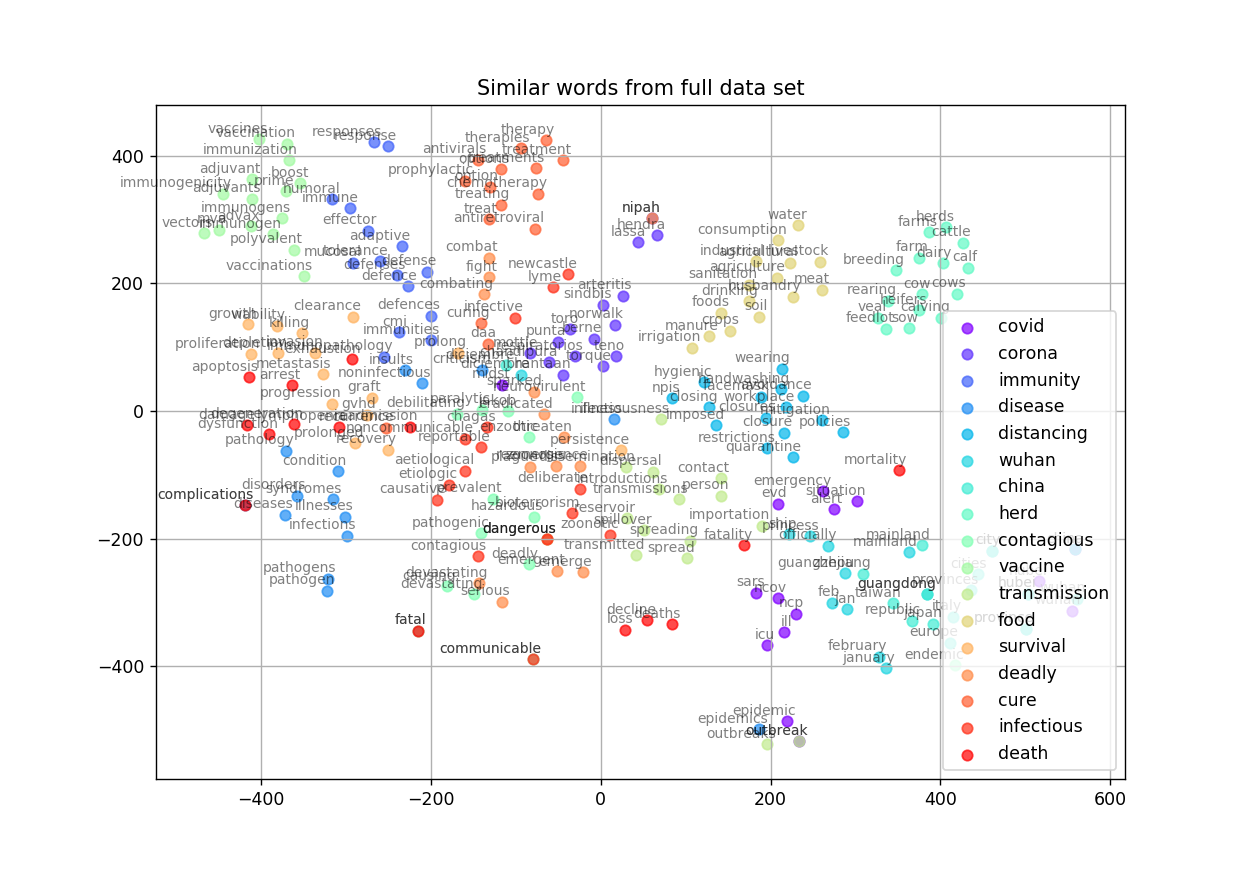

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [99]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    fig = plt.figure(figsize=(10,7))
    
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)

    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    
    mplcursors.cursor(hover=True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

    
tsne_plot_similar_words('Similar words from full data set', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

This plot further shows

# Doc2Vec
In this section we train a Doc2Vec model on the abstracts of all documents.  
Our goal is to use document embeddings to find the best document match for a given query. 

In [67]:
# create documents
documents = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for key in paper_dict:
    abstract = paper_dict[key]['abstract']
    tags = [key]
    
    sentences = nltk.sent_tokenize(abstract)

    preprocessed_sentences = []
    for sentence in sentences:
        preprocessed_sentences.extend(preprocessing(sentence))

    documents.append(analyzedDocument(preprocessed_sentences, tags))

# train the model
doc2Vec_model = doc2vec.Doc2Vec(documents, size=200, window=10, min_count=10, workers=10)

doc2Vec_model.save('models/doc2Vec_model')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
doc2Vec_model = Doc2Vec.load('models/doc2Vec_model')

## What is known about transmission, incubation, and environmental stability?

In [68]:
# query the model
query = "known about transmission, incubation, and environmental stability, CINVID-19".split()

query_vector = doc2Vec_model.infer_vector(query)
similar_abstracts = doc2Vec_model.docvecs.most_similar([query_vector])

for doc_tags in similar_abstracts:
    print(doc_tags[1])
    print_result_from_dict(doc_tags[0])

0.7603039741516113
Title: Viral Diversity, Prey Preference, and Bartonella Prevalence in Desmodus rotundus in Guatemala
Published on '2016-09-22' by 'Wray, Amy K.; Olival, Kevin J.; Morán, David; Lopez, Maria Renee; Alvarez, Danilo; Navarrete-Macias, Isamara; Liang, Eliza; Simmons, Nancy B.; Lipkin, W. Ian; Daszak, Peter; Anthony, Simon J.' in 'Ecohealth'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5164864/
Abstract: Certain bat species serve as natural reservoirs for pathogens in several key viral families including henipa-, lyssa-, corona-, and filoviruses, which may pose serious threats to human health. The Common Vampire Bat (Desmodus rotundus), due to its abundance, sanguivorous feeding habit involving humans and domestic animals, and highly social behavioral ecology, may have an unusually high potential for interspecies disease transmission. Previous studies have investigated rabies dynamics in D. rotundus, yet the diversity of other viruses, bacteria, and other microbes th

Abstract: Although human coronavirus OC43-OC43 (HCoV-OC43) is the coronavirus most commonly associated with human infections, little is known about its molecular epidemiology and evolution. We conducted a molecular epidemiology study to investigate different genotypes and potential recombination in HCoV-OC43. Twenty-nine HCoV-OC43 strains from nasopharyngeal aspirates, collected from 2004 to 2011, were subjected to RNA-dependent RNA polymerase (RdRp), spike, and nucleocapsid gene analysis. Phylogenetic analysis showed at least three distinct clusters of HCoV-OC43, although 10 unusual strains displayed incongruent phylogenetic positions between RdRp and spike genes. This suggested the presence of four HCoV-OC43 genotypes (A to D), with genotype D most likely arising from recombination. The complete genome sequencing of two genotype C and D strains and bootscan analysis showed recombination events between genotypes B and C in the generation of genotype D. Of the 29 strains, none belonged

# BM25 Index
Train a BM25 model on the abstract of all papers.

In [69]:
# create documents
documents = []
for key in paper_dict:
    abstract = paper_dict[key]['abstract']
    
    sentences = nltk.sent_tokenize(abstract)

    preprocessed_sentences = []
    for sentence in sentences:
        preprocessed_sentences.extend(preprocessing(sentence))

    documents.append(preprocessed_sentences)

# train the model
bm25_model = BM25Okapi(documents)

# save model to binary file
save_obj(bm25_model, 'models/bm25_model')

In [ ]:
bm25_model = load_obj('models/bm25_model')

## What is known about transmission, incubation, and environmental stability?

In [70]:
def search(search_query, num_results=10):
    preprocessed_search_query = preprocessing(search_query)
    scores = bm25_model.get_scores(preprocessed_search_query)
    top_indexes = np.argsort(scores)[::-1][0:num_results]
    return top_indexes

In [71]:
query = "known about transmission, incubation, and environmental stability, CINVID-19"

top_indexes = search(query)
dict_keys = list(paper_dict.keys())
for index in top_indexes:
    dict_key = dict_keys[index]
    print_result_from_dict(dict_key)

Title: Chaos in a nonautonomous eco-epidemiological model with delay
Published on '2020-03-31' by 'Samanta, Sudip; Tiwari, Pankaj Kumar; Alzahrani, Abdullah K.; Alshomrani, Ali Saleh' in 'Applied Mathematical Modelling'
Url: https://doi.org/10.1016/j.apm.2019.11.006
Abstract: Abstract In this paper, we propose and analyze a nonautonomous predator-prey model with disease in prey, and a discrete time delay for the incubation period in disease transmission. Employing the theory of differential inequalities, we find sufficient conditions for the permanence of the system. Further, we use Lyapunov’s functional method to obtain sufficient conditions for global asymptotic stability of the system. We observe that the permanence of the system is unaffected due to presence of incubation delay. However, incubation delay affects the global stability of the positive periodic solution of the system. To reinforce the analytical results and to get more insight into the system’s behavior, we perform som

# Implement a BERT search engine 

Ref: https://www.kaggle.com/zoupet/covid-19-search-engine-with-bert by Julien Heiduk

In [26]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

ImportError: cannot import name 'AlbertModel' from 'transformers' (C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\transformers\__init__.py)

In [ ]:
question_embedding = model.encode(['What is known about transmission, incubation, and environmental stability?'])

queries = [       "Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",
                  "How long is the incubation period for the virus?",
                  "Can the virus be transmitted asymptomatically or during the incubation period?",
                  "How does weather, heat, and humidity affect the tramsmission of 2019-nCoV?"
              ]
query_embeddings = model.encode(queries)

In [ ]:
df_noncomm = create_df(noncomm_json_files, filepath_noncomm)

In [ ]:
abstract_embeddings = model.encode(df_noncomm.text.values)

# Implement a BERT summarizer

Bidirectional Encoder Representations from Transformers (originally published here  https://arxiv.org/pdf/1810.04805.pdf)  is a technique for NLP pre-training developed by Google. In the paper it was showed that a language model which is bidirectionally trained can have a deeper understanding of language context and flow than single-direction language models. Since this is valued properties when building a Q&A model or summarizing a text BERT was implemented here.

In [2]:
from sentence_transformers import SentenceTransformer
summary_model = Summarizer()

In [0]:
closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = sc.spatial.distance.cdist([query_embedding], abstract_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        result = summary_model(df_noncomm['text'][idx])
        full = ''.join(result)
        print(df_noncomm['text'][idx].strip(), "\n(Score: %.4f)" % (1-distance),"\n")
        print("\nSummary of the paper containing the sentence: ", full, "\n")





Query: Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?

Top 5 most similar sentences in corpus:
Porcine Epidemic Diarrhea Virus (PEDV), Porcine Delta Corona Virus (PDCoV), and Transmissible Gastroenteritis Virus (TGEV) are major threats to swine health and contaminated feed plays a role in virus transmission. The objective of our study was to characterize inactivation of PEDV, PDCoV, and TGEV in various feed ingredient matrices. Samples of complete feed, spray dried porcine plasma, meat meal, meat and bone meal, blood meal, corn, soybean meal, and corn dried distillers grains with solubles were weighed (5 g/sample) into scintillation vials and inoculated with 1 mL of PEDV, PDCoV, or TGEV. Samples were incubated at room temperature for up to 56 days. Aliquots were removed at various time points followed by preparing serial 10-fold dilutions and inoculating in cell cultures to determine the amount of surviving virus. Inactivation kinetics w

In [0]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

BERT_SQUAD = 'bert-large-uncased-whole-word-masking-finetuned-squad'

model = BertForQuestionAnswering.from_pretrained(BERT_SQUAD)
tokenizer = BertTokenizer.from_pretrained(BERT_SQUAD)

model = model.to(torch_device)

Those Who Are Resilient Stay In The Game Longer
“On the mountains of truth you can never climb in vain: either you will reach a point higher up today, or you will be training your powers so that you will be able to climb higher tomorrow.” I can’t tell you what the right course of action is; only you will know. Each person has a different mindset that decides their outcome. Those who are resilient stay in the game longer and draw on their inner means to succeed. No one knows what the future holds, so your only guide is whether you can endure repeated defeats and disappointments and still pursue your dream. “Two people on a precipice over Yosemite Valley” by Nathan Shipps on Unsplash
Develop A Powerful Vision Of What You Want
“Your problem is to bridge the gap which exists between where you are now and the goal you intend to reach.” Gnaw away at your problems until you solve them or find a solution. Nurture it daily and give it life by taking purposeful action towards it. Because I assur

In [ ]:
question, text = "Can the virus be transmitted asymptomatically or during the incubation period?", df_noncomm['text'][0]

input_ids = tokenizer.encode(question, text)
token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([token_type_ids]))

all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
answer = ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1])

print(answer)

# Conclusions 

We implemented four of the most commonly used techniques for NLP: Word2Vec, Doc2Vec, BM25 and BERT.  
Using the Word2Vec embedding we aimed to extract some useful information out of the large data set and maybe gain new information about COVID-19. The results for the query to find potential treatments showed the potential of this approach. We were able to identify some drugs that appeared in the context of 'COVID treatment'. It is important to mention at this point that these outputs contain no information about the actual potential for a treatment. However we believe that this approach could help scientists to search large database and find potential candidates for such drugs.  

Our main goal of this notebook was to build a search engine that is able to find the best matches for a given query. For this we compared Doc2Vec, BM25 and BERT. We consider the BM25 as the best model from these choices. Not only does it train faster but it also prduces better results in the sense that the matched documents seem to be more relevant than those found by DOC2Vec and BERT. Most likely this is due to the fact that BM25 requires a smaller data set to produce reasonable results.  

However our approach with using BERT to find specific sentences or facts in the documents also prduced some good results. In this context, the BERT implementation provides further insight into the research questions encoded into the model by providing reasonable answers to most questions, although it suffers from computational issues.